In [43]:
import pandas as pd
import json
import random
from collections import defaultdict
import os
import pprint
import matplotlib.pyplot as plt
import seaborn as sns


## Generating dummy json files

In [ ]:
# with open('/Users/surajkwork/Documents/Projects/ProteinLigand/protein-ligand/protein-ligand/jsonfiles/1_4eiy.json') as f:
#     original_data = json.load(f)


In [40]:
# Helper function to generate random values similar to the original
def generate_similar_value(original_value, variation=0.1):
    if isinstance(original_value, (int, float)):
        # Add random variation, up to ±10% of the original value
        return original_value * (1 + random.uniform(-variation, variation))
    return original_value

In [ ]:
# Function to create dummy data
def create_dummy_json(original_data, num_files=5, output_dir='./'):
    for file_num in range(num_files):
        dummy_data = []

        for entry in original_data:
            dummy_entry = {}

            # Keep 'residues' the same
            dummy_entry['residues'] = entry['residues']

            # Generate new values for 'hotspots'
            dummy_entry['hotspots'] = []
            for hotspot in entry['hotspots']:
                dummy_hotspot = {
                    'center': [generate_similar_value(coord, 0.1) for coord in hotspot['center']],
                    'scores': {key: generate_similar_value(value, 0.2) for key, value in hotspot['scores'].items()}
                }
                dummy_entry['hotspots'].append(dummy_hotspot)

            # Generate new values for 'properties'
            dummy_entry['properties'] = {key: generate_similar_value(value, 0.1) for key, value in entry['properties'].items()}

            # Generate new values for 'residue_properties'
            dummy_entry['residue_properties'] = {}
            for residue, properties in entry['residue_properties'].items():
                dummy_entry['residue_properties'][residue] = {key: generate_similar_value(value, 0.1) for key, value in properties.items()}

            dummy_data.append(dummy_entry)

        # Save to a new JSON file
        output_path = f"{output_dir}/dummy_file_{file_num + 1}.json"
        with open(output_path, 'w') as outfile:
            json.dump(dummy_data, outfile, indent=4)

        #print(f"Dummy JSON file created: {output_path}")

In [ ]:
# create_dummy_json(original_data, num_files=499, output_dir='/Users/surajkwork/Documents/Projects/ProteinLigand/protein-ligand/protein-ligand/jsonfiles')

## Calculating statistics across json files

In [28]:
# Function to load and parse all JSON files
def load_json_files(folder_path):
    data = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.json'):
            with open(os.path.join(folder_path, file_name)) as f:
                data.extend(json.load(f))
    return data

In [29]:
# Function to collect and compute statistics
def compute_statistics_for_residue_set(data, residue_set):
    # Initialize dictionaries to collect values for hotspots and properties
    combined_hotspots = defaultdict(list)
    combined_properties = defaultdict(list)
    
    # Loop through each entry in the data
    for entry in data:
        # Check if the current entry's residues match the desired set
        if set(entry['residues']) == set(residue_set):
            # Collect 'hotspots' data
            for hotspot in entry['hotspots']:
                # Collect 'center' coordinates separately
                combined_hotspots['center_x'].append(hotspot['center'][0])
                combined_hotspots['center_y'].append(hotspot['center'][1])
                combined_hotspots['center_z'].append(hotspot['center'][2])
                
                # Collect 'scores' data
                for score_type, score_value in hotspot['scores'].items():
                    combined_hotspots[score_type].append(score_value)
            
            # Collect 'properties' data
            for prop, value in entry['properties'].items():
                combined_properties[prop].append(value)
    
    # Compute statistics
    statistics = {
        'hotspots': {
            metric: {
                'mean': pd.Series(values).mean(),
                'median': pd.Series(values).median(),
                'quantiles': pd.Series(values).quantile([0.25, 0.5, 0.75]).to_dict()
            }
            for metric, values in combined_hotspots.items()
        },
        'properties': {
            prop: {
                'mean': pd.Series(values).mean(),
                'median': pd.Series(values).median(),
                'quantiles': pd.Series(values).quantile([0.25, 0.5, 0.75]).to_dict()
            }
            for prop, values in combined_properties.items()
        }
    }
    
    return statistics

In [30]:
folder_path = '/Users/surajkwork/Documents/Projects/ProteinLigand/protein-ligand/protein-ligand/jsonfiles'
data = load_json_files(folder_path)
residue_set = ["A_81_ALA", "A_168_PHE", "A_249_LEU", "A_274_ILE"]
statistics = compute_statistics_for_residue_set(data, residue_set)


In [46]:
# Function to collect and compute statistics for the entire set of residues
def compute_statistics_and_plot_distributions(data, residue_set):
    # Initialize dictionaries to collect values for hotspots and properties
    combined_hotspots = defaultdict(list)
    combined_properties = defaultdict(list)
    
    # Loop through each entry in the data
    for entry in data:
        # Check if the current entry's residues match the desired set
        if set(entry['residues']) == set(residue_set):
            # Collect 'hotspots' data
            for hotspot in entry['hotspots']:
                # Collect 'center' coordinates separately
                combined_hotspots['center_x'].append(hotspot['center'][0])
                combined_hotspots['center_y'].append(hotspot['center'][1])
                combined_hotspots['center_z'].append(hotspot['center'][2])
                
                # Collect 'scores' data
                for score_type, score_value in hotspot['scores'].items():
                    combined_hotspots[score_type].append(score_value)
            
            # Collect 'properties' data
            for prop, value in entry['properties'].items():
                combined_properties[prop].append(value)
    
    # Compute statistics
    statistics = {
        'hotspots': {
            metric: {
                'mean': pd.Series(values).mean(),
                'median': pd.Series(values).median(),
                'quantiles': pd.Series(values).quantile([0.25, 0.5, 0.75]).to_dict()
            }
            for metric, values in combined_hotspots.items()
        },
        'properties': {
            prop: {
                'mean': pd.Series(values).mean(),
                'median': pd.Series(values).median(),
                'quantiles': pd.Series(values).quantile([0.25, 0.5, 0.75]).to_dict()
            }
            for prop, values in combined_properties.items()
        }
    }
    
    # Plot distributions using seaborn
    sns.set(style="whitegrid")  # Set seaborn style

    # Plot distributions for 'hotspots'
    for metric, values in combined_hotspots.items():
        plt.figure(figsize=(5, 3))
        sns.histplot(values, bins=30, kde=True, color='blue')
        plt.title(f'Distribution of {metric} (Hotspots)')
        plt.xlabel(metric)
        plt.ylabel('Frequency')
        plt.show()

    # Plot distributions for 'properties'
    for prop, values in combined_properties.items():
        plt.figure(figsize=(5, 3))
        sns.histplot(values, bins=30, kde=True, color='green')
        plt.title(f'Distribution of {prop} (Properties)')
        plt.xlabel(prop)
        plt.ylabel('Frequency')
        plt.show()
    
    return statistics

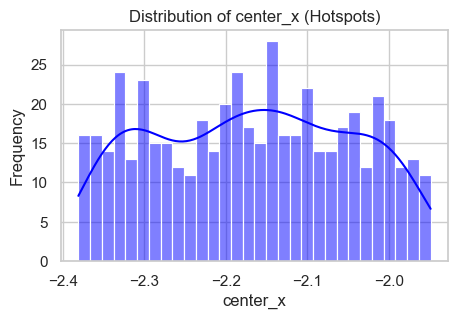

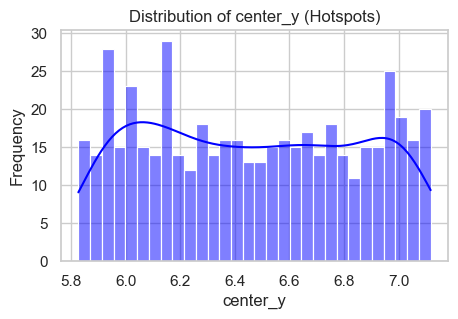

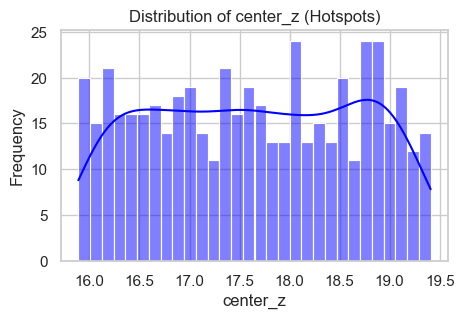

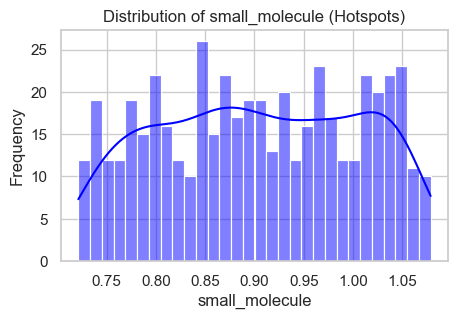

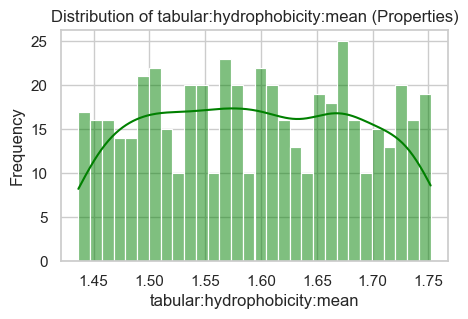

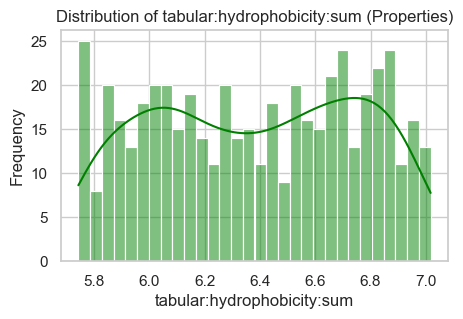

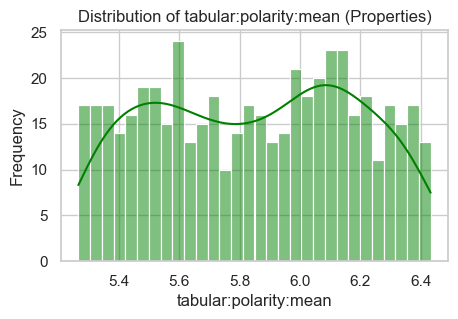

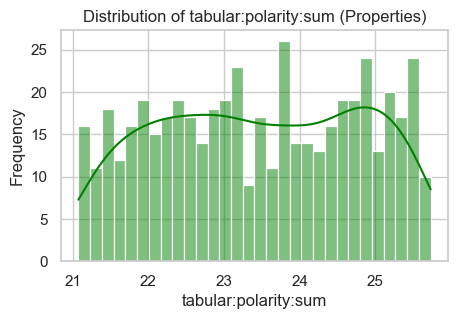

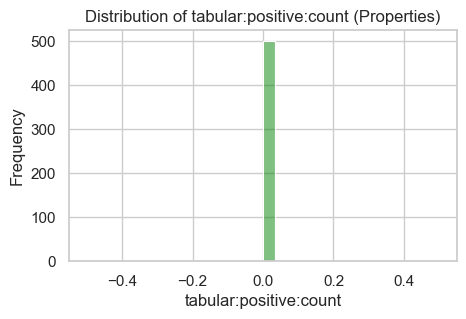

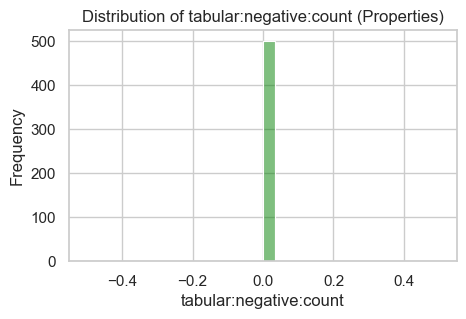

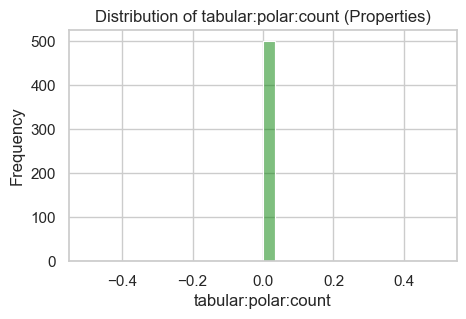

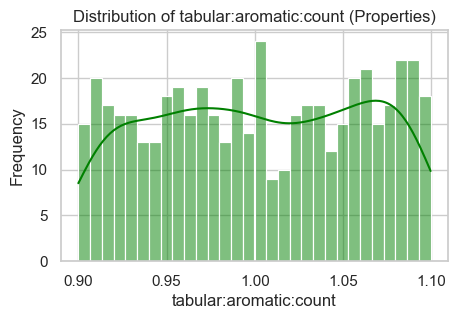

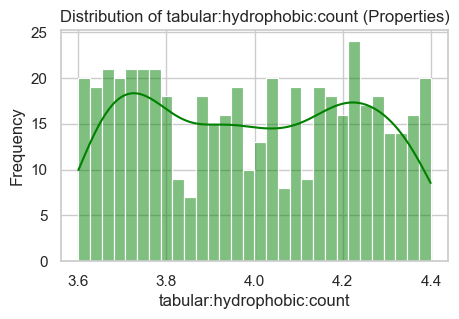

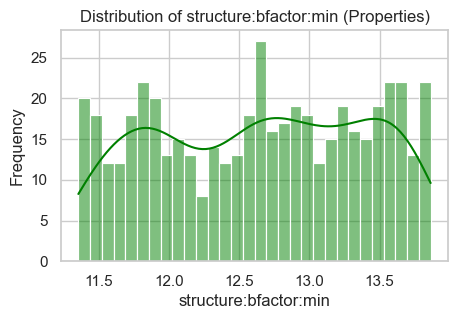

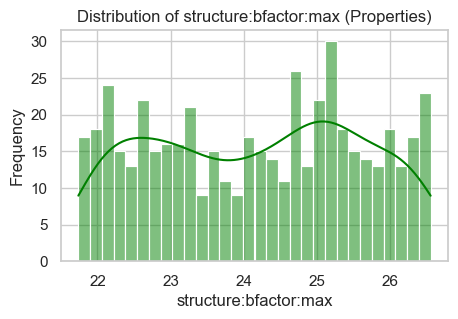

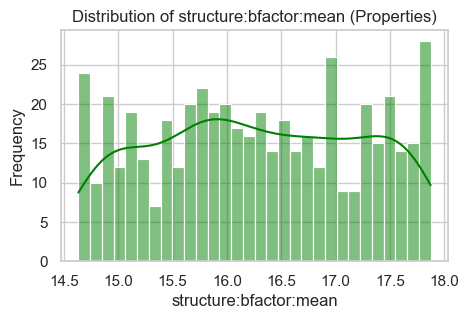

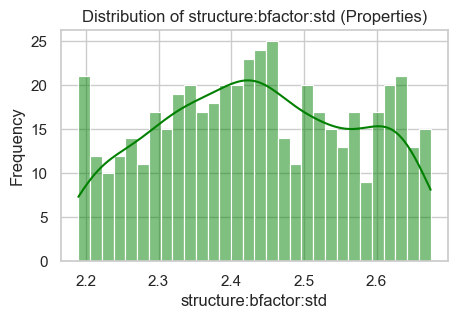

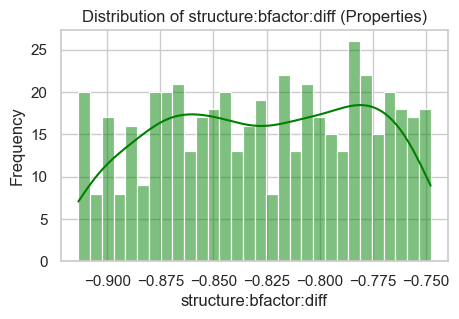

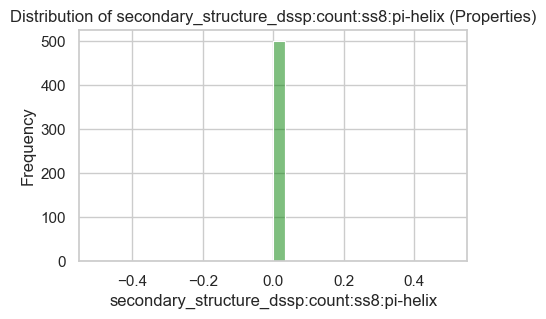

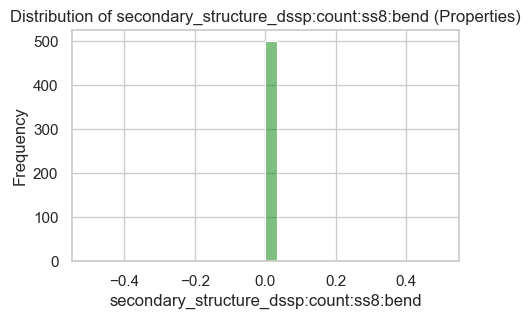

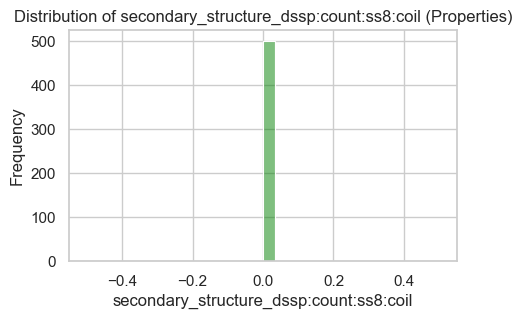

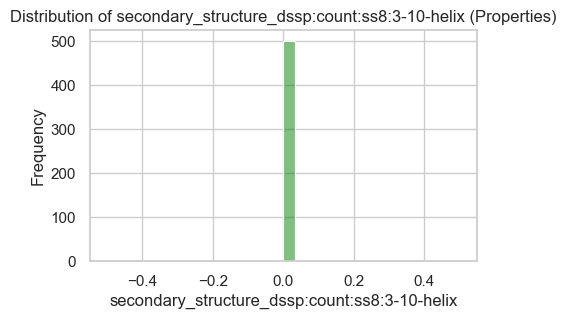

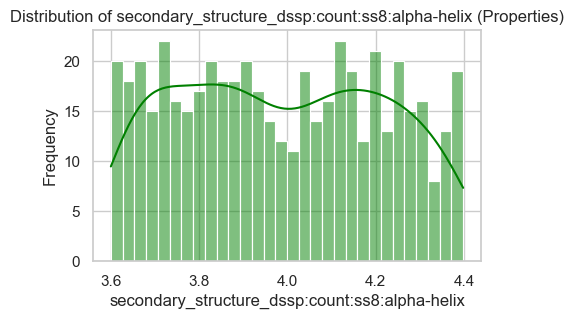

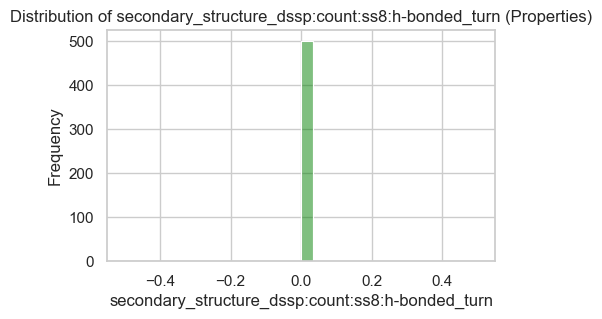

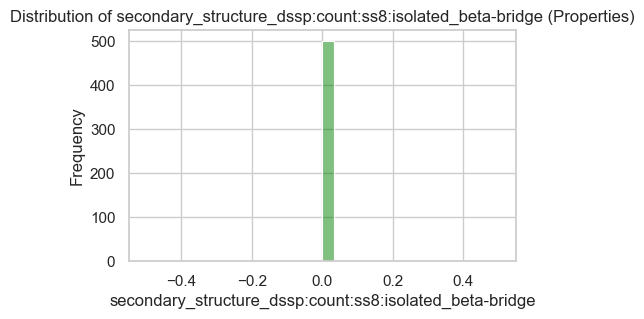

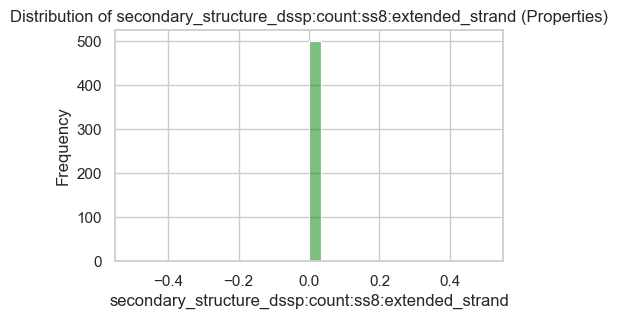

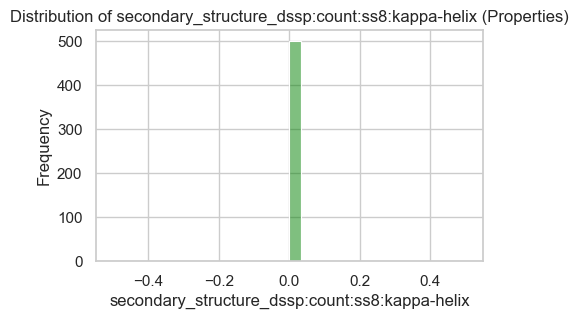

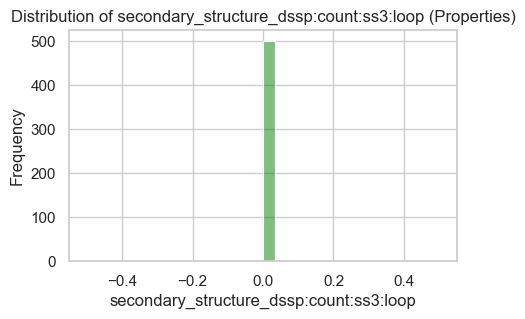

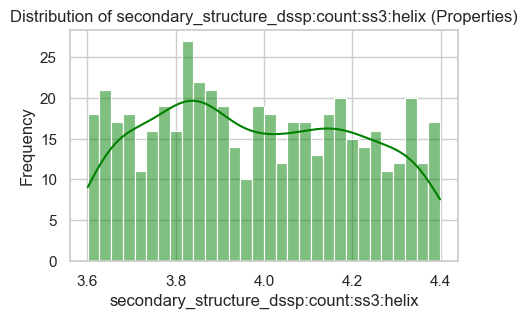

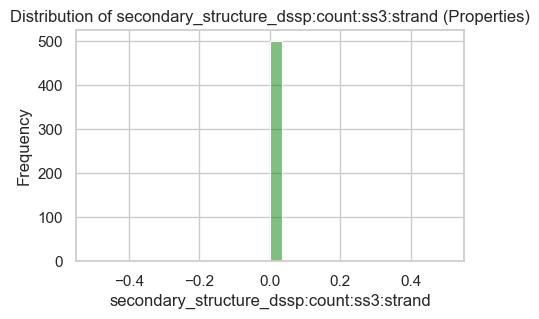

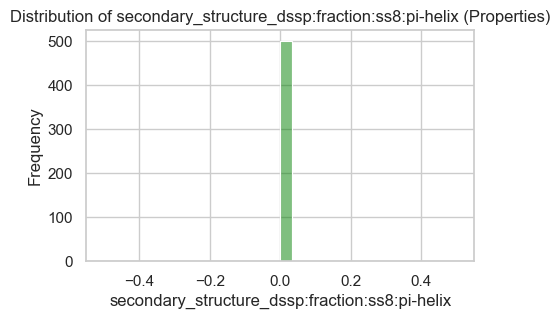

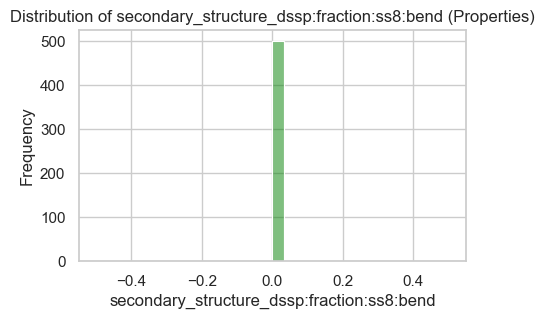

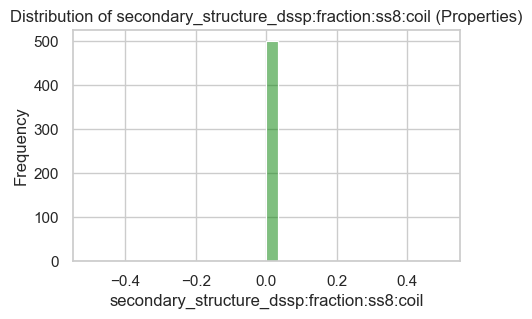

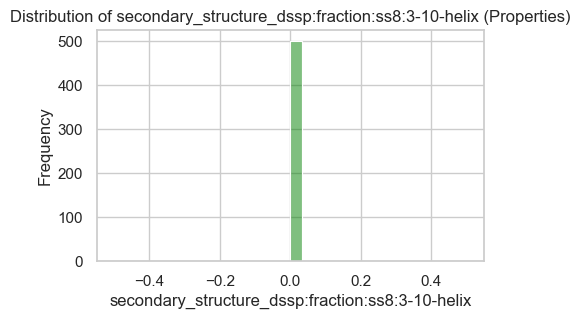

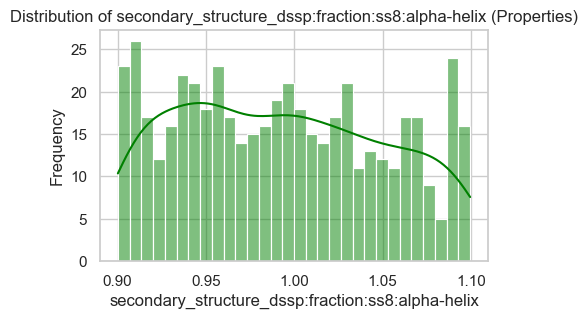

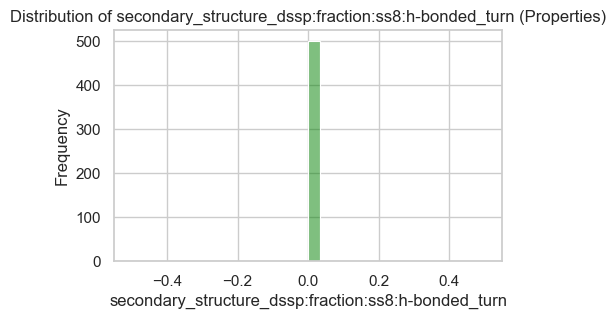

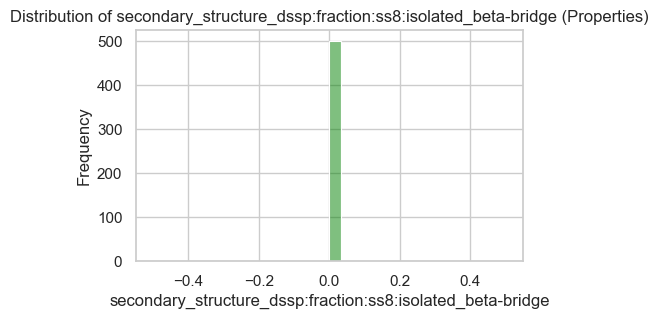

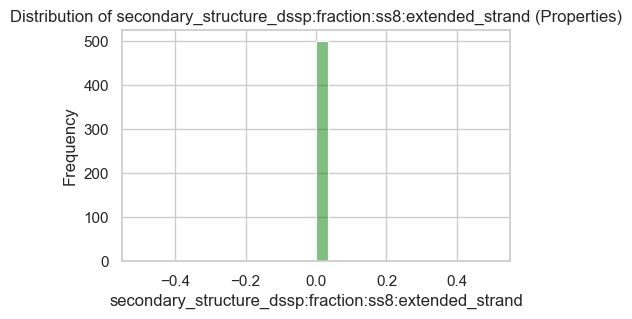

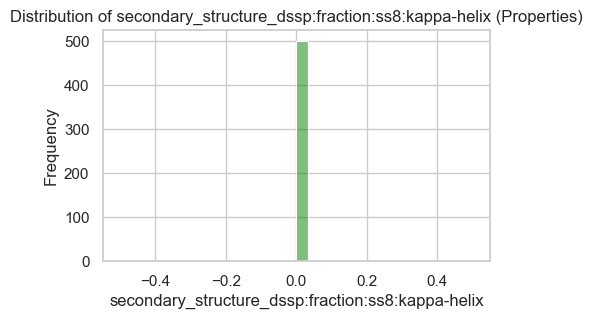

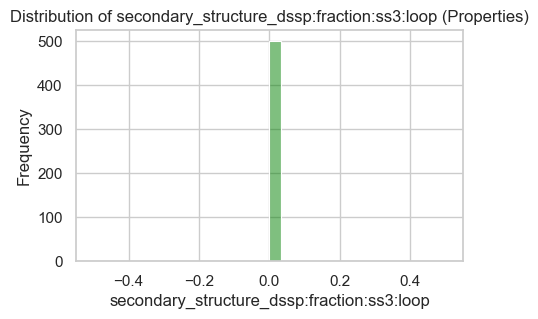

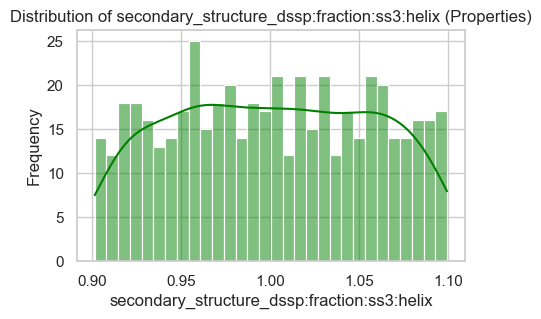

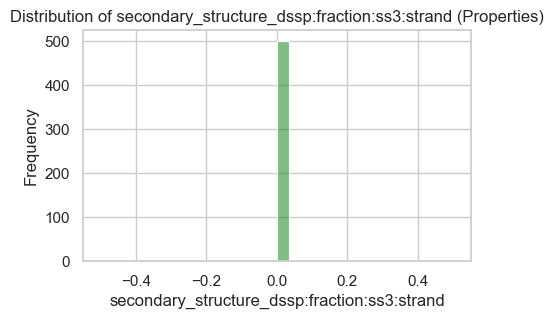

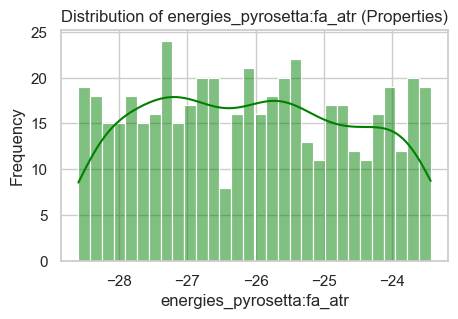

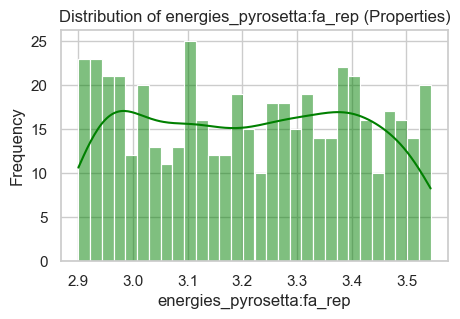

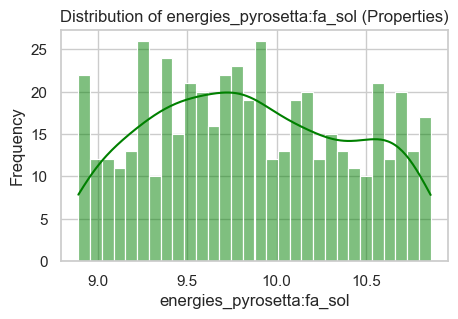

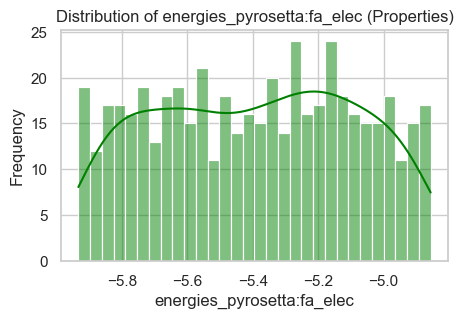

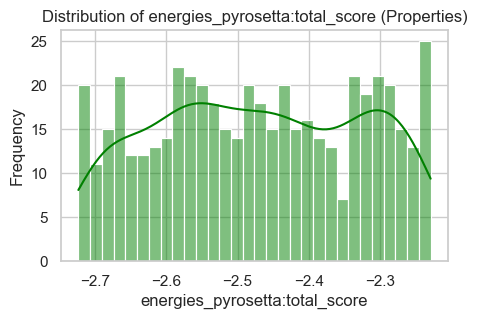

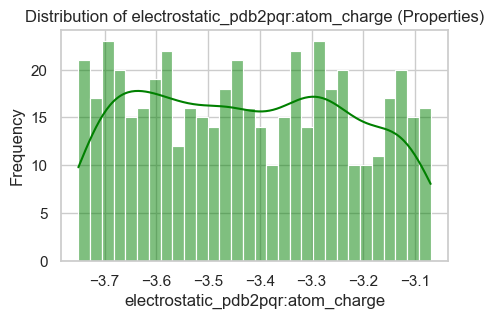

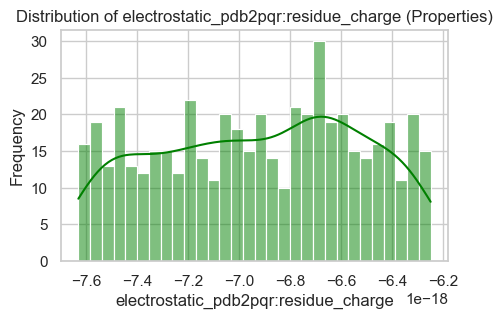

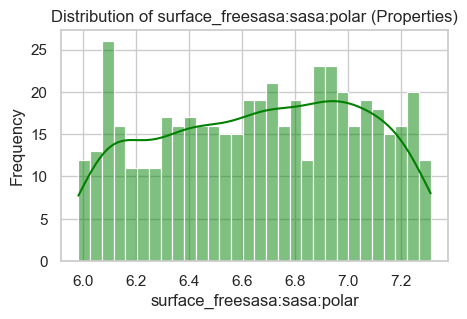

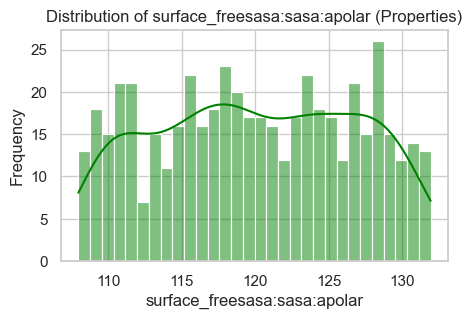

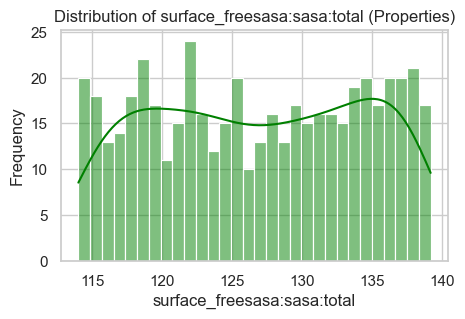

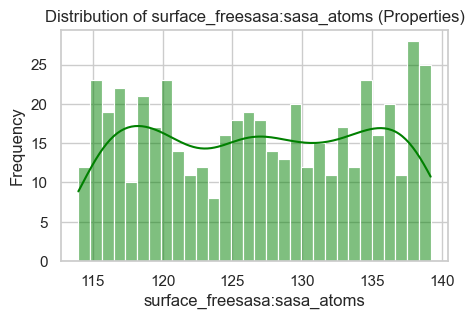

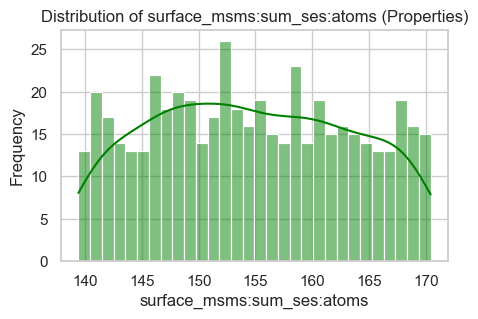

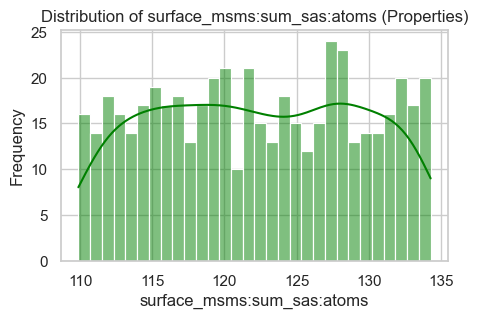

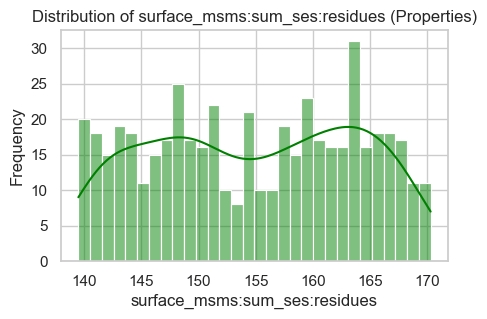

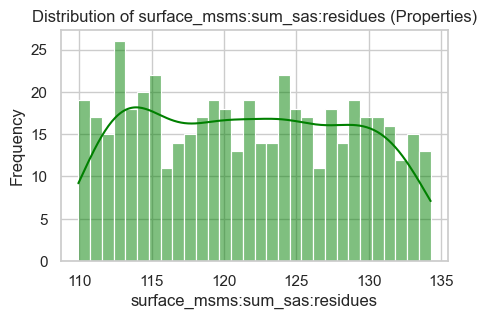

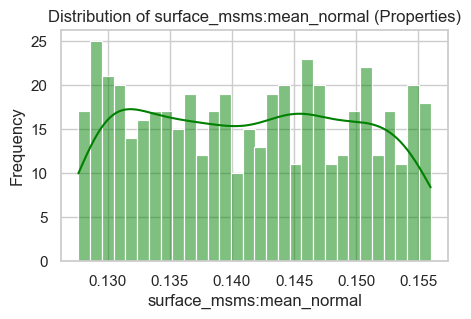

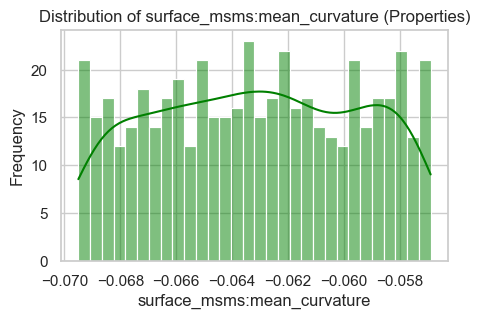

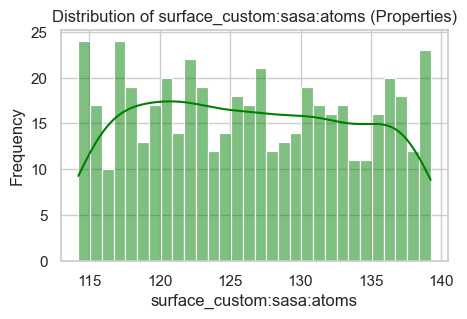

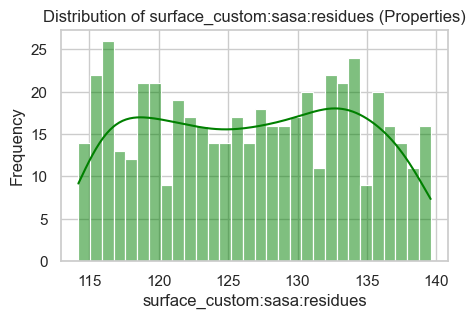

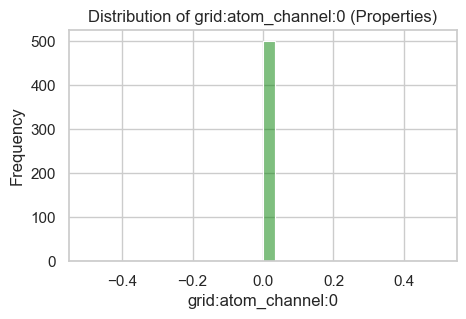

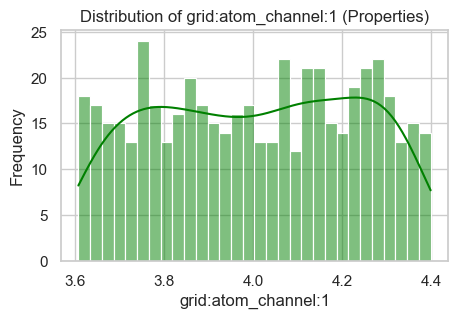

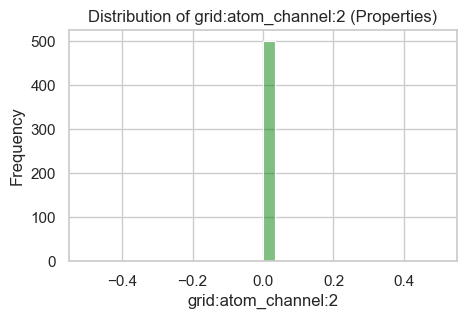

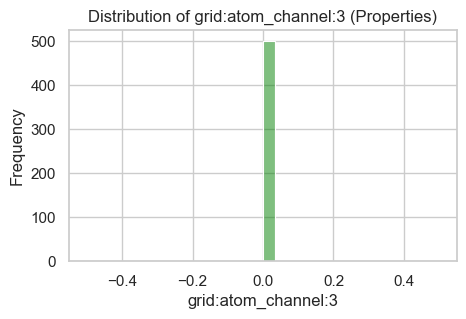

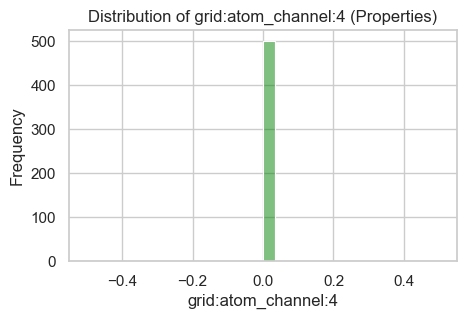

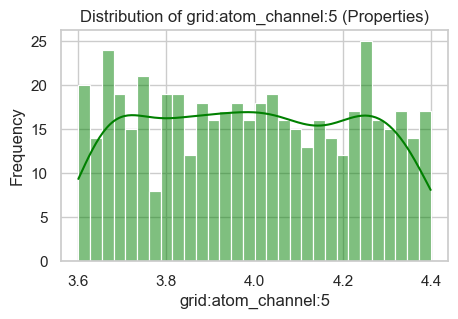

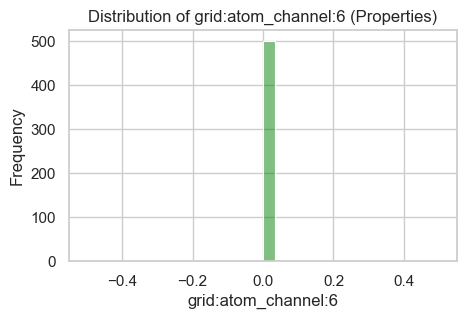

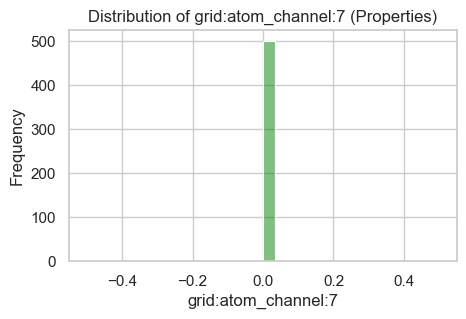

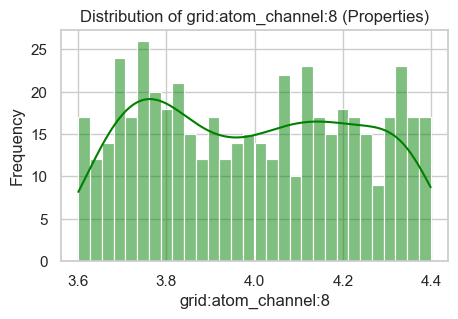

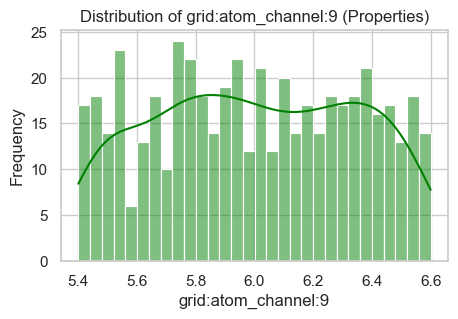

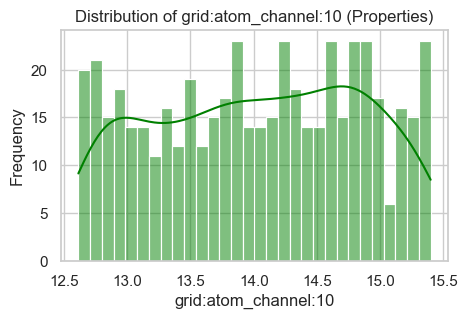

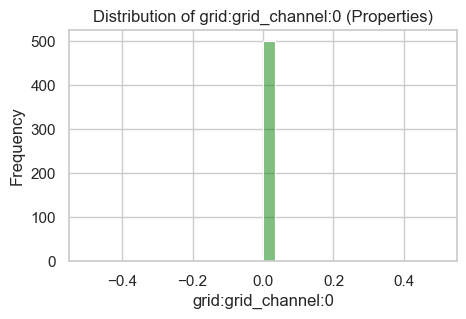

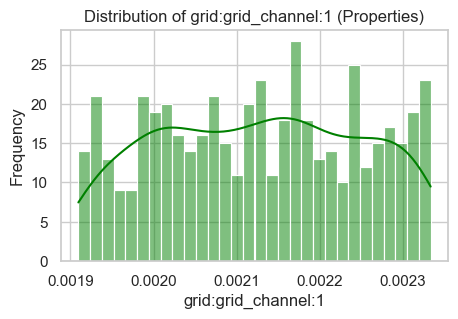

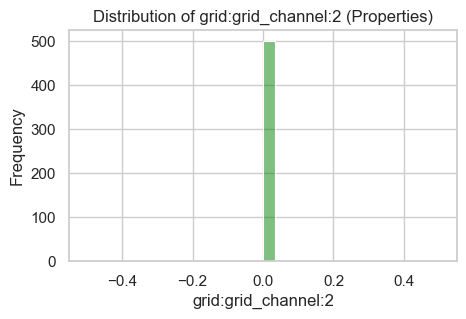

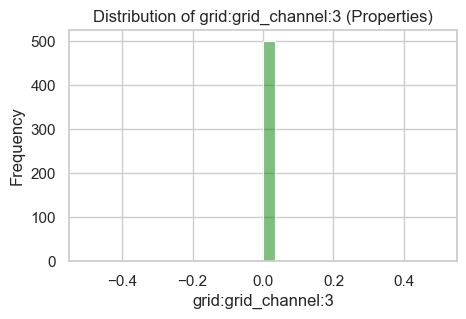

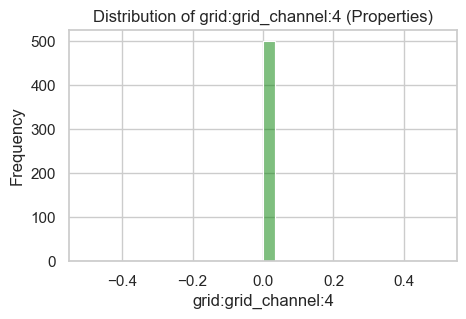

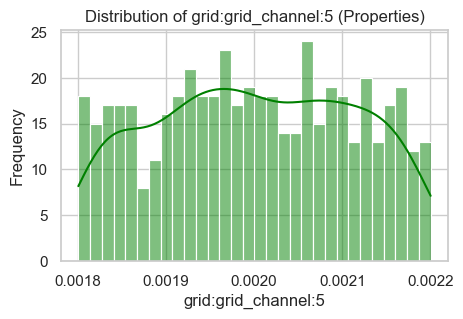

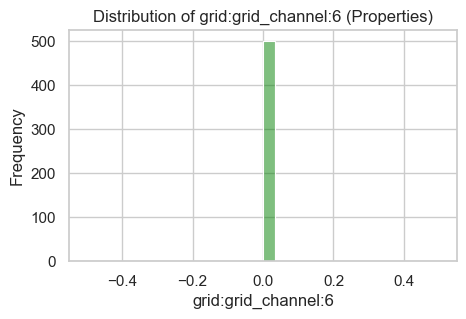

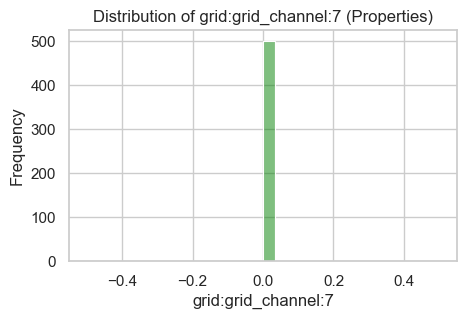

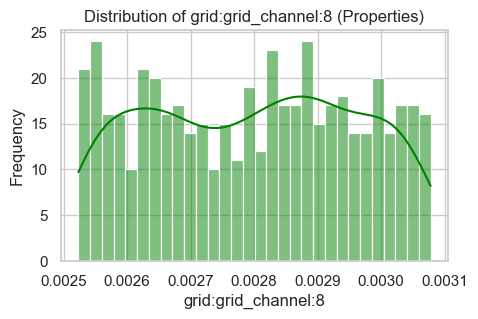

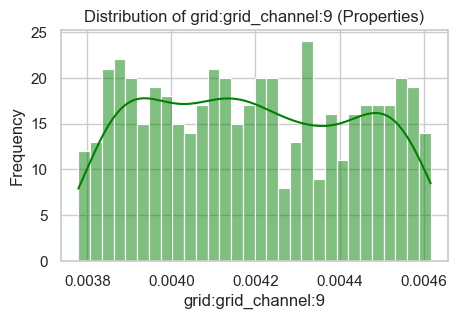

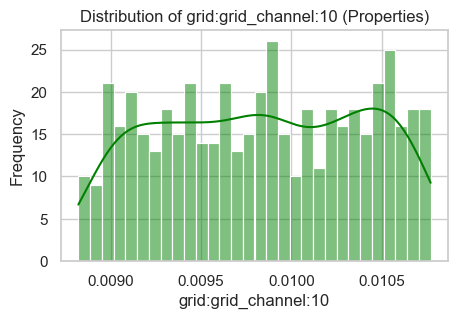

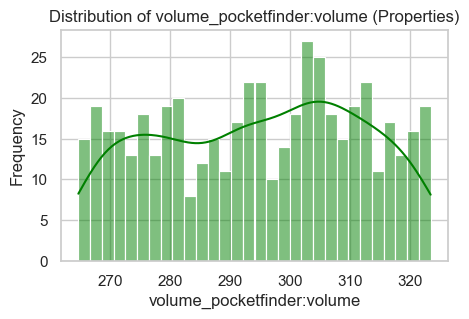

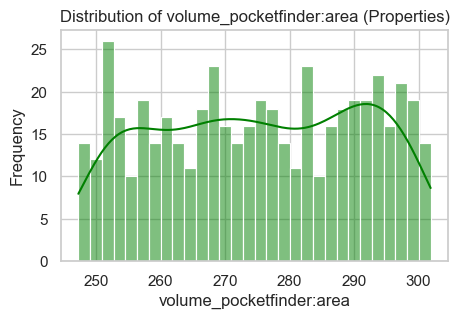

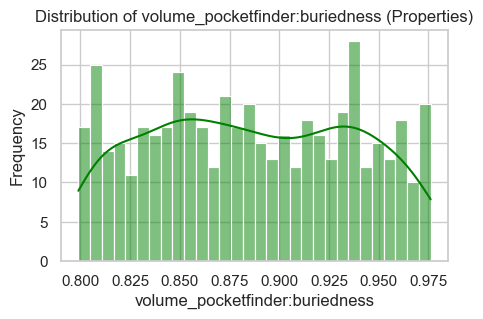

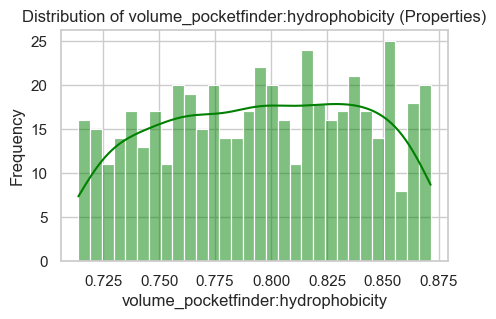

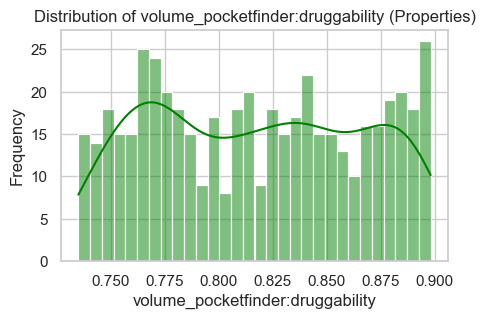

In [47]:
folder_path = '/Users/surajkwork/Documents/Projects/ProteinLigand/protein-ligand/protein-ligand/jsonfiles'
data = load_json_files(folder_path)
residue_set = ["A_81_ALA", "A_168_PHE", "A_249_LEU", "A_274_ILE"]
statistics = compute_statistics_and_plot_distributions(data, residue_set)

In [50]:
# Function to collect and compute statistics for multiple residue sets
def compute_statistics_for_residue_sets(data, residue_sets):
    # Initialize a dictionary to collect values grouped by residue sets
    aggregated_data = {str(residue_set): {'hotspots': defaultdict(list), 'properties': defaultdict(list)} for residue_set in residue_sets}
    
    # Loop through each entry in the data
    for entry in data:
        residues = entry['residues']
        
        # Check each residue set to see if it is fully contained within the residues in the current entry
        for residue_set in residue_sets:
            if all(res in residues for res in residue_set):
                # Aggregate 'hotspots' data
                for hotspot in entry['hotspots']:
                    aggregated_data[str(residue_set)]['hotspots']['center_x'].append(hotspot['center'][0])
                    aggregated_data[str(residue_set)]['hotspots']['center_y'].append(hotspot['center'][1])
                    aggregated_data[str(residue_set)]['hotspots']['center_z'].append(hotspot['center'][2])
                    
                    # Collect 'scores' data
                    for score_type, score_value in hotspot['scores'].items():
                        aggregated_data[str(residue_set)]['hotspots'][score_type].append(score_value)
                
                # Aggregate 'properties' data
                for prop, value in entry['properties'].items():
                    aggregated_data[str(residue_set)]['properties'][prop].append(value)
    
    # Compute statistics and plot distributions
    statistics_list = []  # List to hold statistics for the DataFrame
    for residue_set, metrics in aggregated_data.items():
        print(f"\nStatistics for Residue Set: {residue_set}")
        
        # Compute statistics for 'hotspots'
        for metric, values in metrics['hotspots'].items():
            mean_value = pd.Series(values).mean()
            median_value = pd.Series(values).median()
            quantiles = pd.Series(values).quantile([0.25, 0.5, 0.75]).to_dict()
            print(f"  Hotspot - {metric}: mean={mean_value}, median={median_value}, quantiles={quantiles}")
            
            # Collect statistics for the DataFrame
            statistics_list.append({
                'Residue Set': residue_set,
                'Metric': f"Hotspot - {metric}",
                'Mean': mean_value,
                'Median': median_value,
                'Quantile 25%': quantiles.get(0.25),
                'Quantile 50%': quantiles.get(0.5),
                'Quantile 75%': quantiles.get(0.75)
            })
            
            # Plot distribution
            plt.figure(figsize=(10, 6))
            sns.histplot(values, bins=30, kde=True, color='blue')
            plt.title(f'Distribution of {metric} (Hotspots) for {residue_set}')
            plt.xlabel(metric)
            plt.ylabel('Frequency')
            plt.show()
        
        # Compute statistics for 'properties'
        for prop, values in metrics['properties'].items():
            mean_value = pd.Series(values).mean()
            median_value = pd.Series(values).median()
            quantiles = pd.Series(values).quantile([0.25, 0.5, 0.75]).to_dict()
            print(f"  Property - {prop}: mean={mean_value}, median={median_value}, quantiles={quantiles}")
            
            # Collect statistics for the DataFrame
            statistics_list.append({
                'Residue Set': residue_set,
                'Metric': f"Property - {prop}",
                'Mean': mean_value,
                'Median': median_value,
                'Quantile 25%': quantiles.get(0.25),
                'Quantile 50%': quantiles.get(0.5),
                'Quantile 75%': quantiles.get(0.75)
            })
            
            # Plot distribution
            plt.figure(figsize=(10, 6))
            sns.histplot(values, bins=30, kde=True, color='green')
            plt.title(f'Distribution of {prop} (Properties) for {residue_set}')
            plt.xlabel(prop)
            plt.ylabel('Frequency')
            plt.show()
    
    # Convert the list of statistics to a DataFrame
    statistics_df = pd.DataFrame(statistics_list)
    return statistics_df


Statistics for Residue Set: ['A_81_ALA', 'A_168_PHE', 'A_249_LEU', 'A_274_ILE']
  Hotspot - center_x: mean=-2.1688877134471176, median=-2.165445902516467, quantiles={0.25: -2.2751293528390986, 0.5: -2.165445902516467, 0.75: -2.0681501630989305}


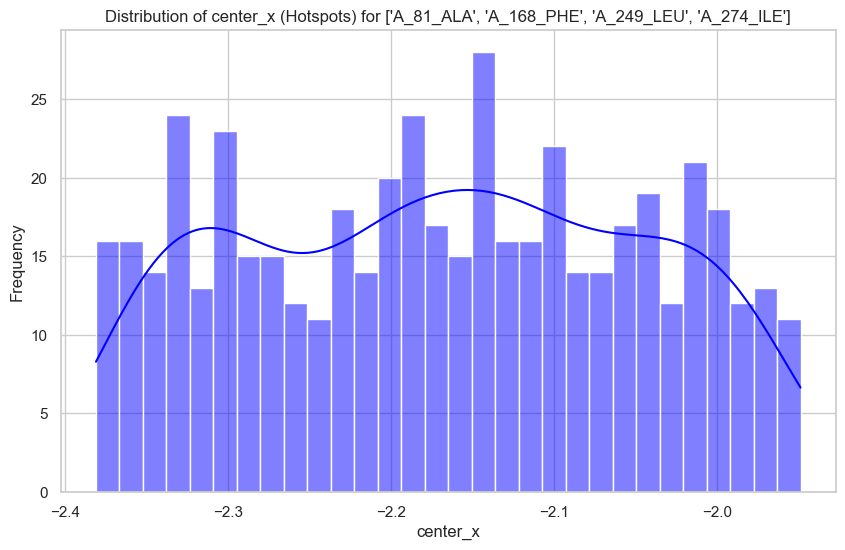

  Hotspot - center_y: mean=6.46290122962315, median=6.451569972525543, quantiles={0.25: 6.129507226315707, 0.5: 6.451569972525543, 0.75: 6.802489442004582}


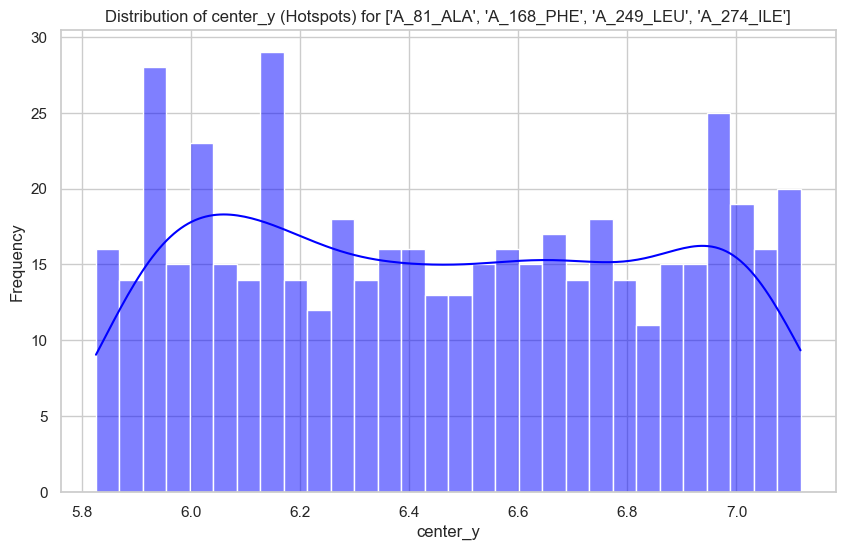

  Hotspot - center_z: mean=17.641007374945175, median=17.625730869980917, quantiles={0.25: 16.721926188711755, 0.5: 17.625730869980917, 0.75: 18.55968166632419}


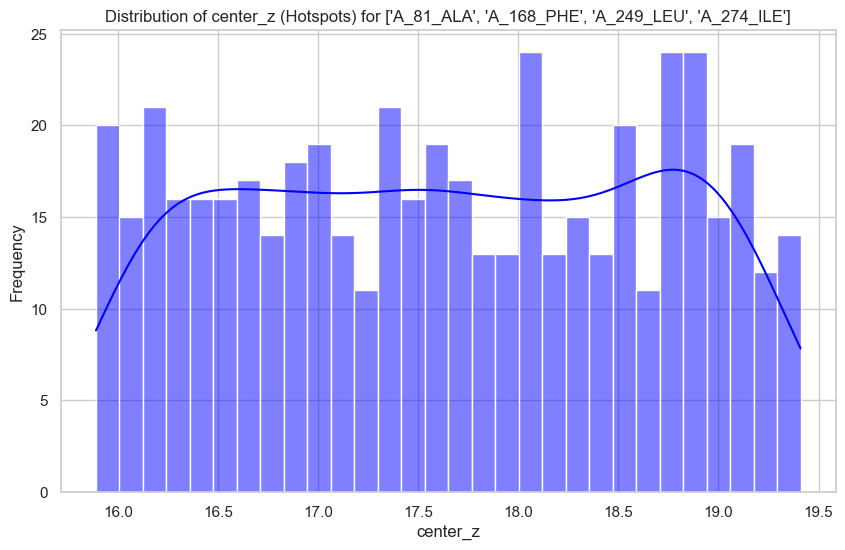

  Hotspot - small_molecule: mean=0.9030199264130607, median=0.9019665136296094, quantiles={0.25: 0.8162386666094495, 0.5: 0.9019665136296094, 0.75: 0.9893700663982801}


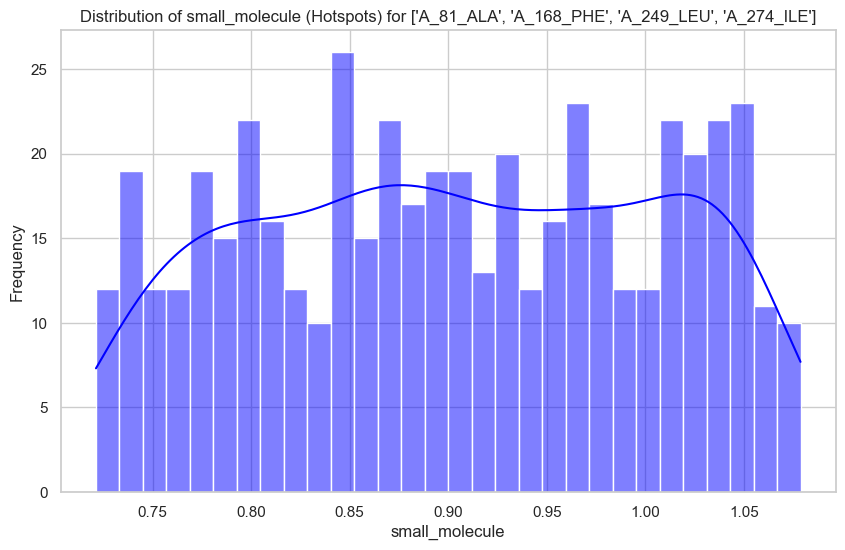

  Property - tabular:hydrophobicity:mean: mean=1.5939423022288952, median=1.5950629452375666, quantiles={0.25: 1.515358843848879, 0.5: 1.5950629452375666, 0.75: 1.6727168039092362}


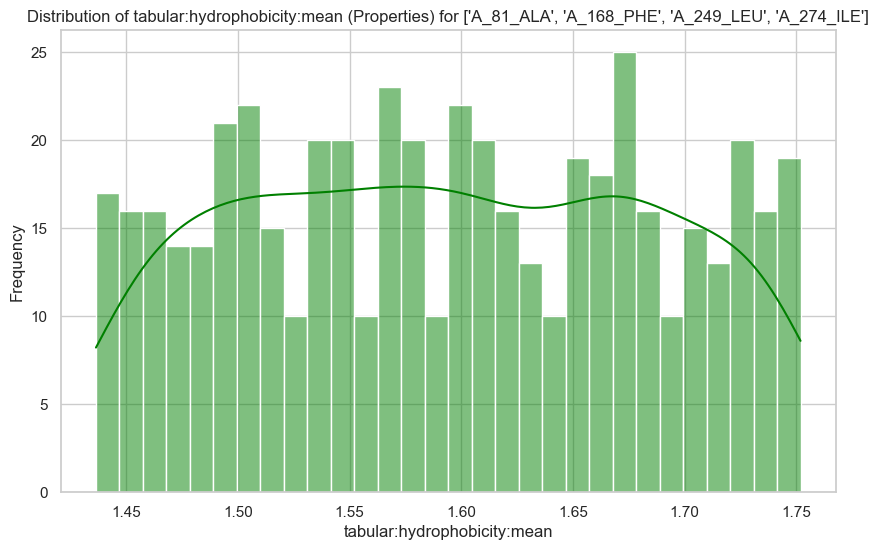

  Property - tabular:hydrophobicity:sum: mean=6.381952962666088, median=6.396029935948263, quantiles={0.25: 6.058134487175711, 0.5: 6.396029935948263, 0.75: 6.707663188870515}


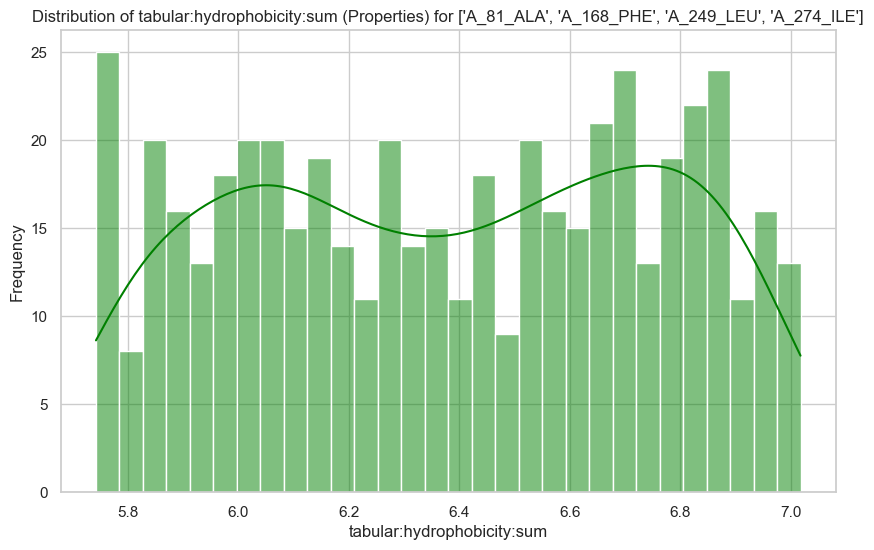

  Property - tabular:polarity:mean: mean=5.848383566744202, median=5.863588845410753, quantiles={0.25: 5.549076986897856, 0.5: 5.863588845410753, 0.75: 6.131252474110713}


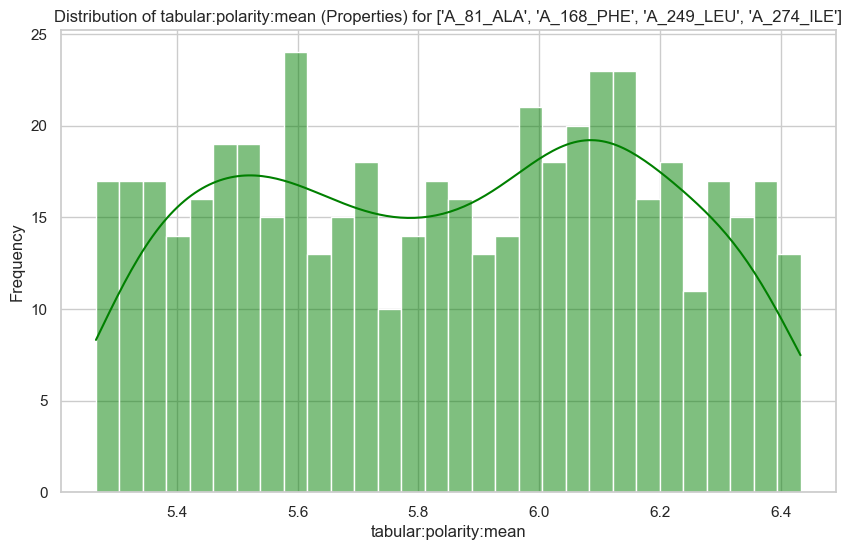

  Property - tabular:polarity:sum: mean=23.46146795753474, median=23.447375638049166, quantiles={0.25: 22.327220606990995, 0.5: 23.447375638049166, 0.75: 24.657306788128096}


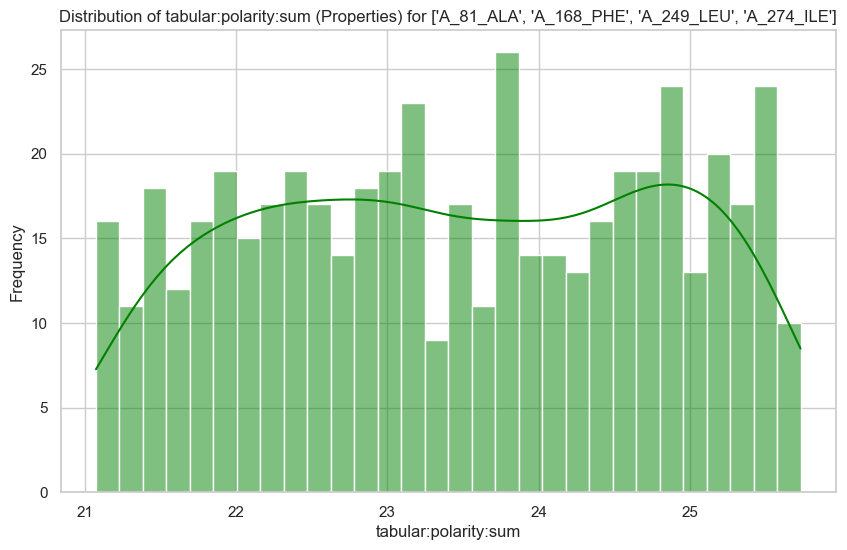

  Property - tabular:positive:count: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


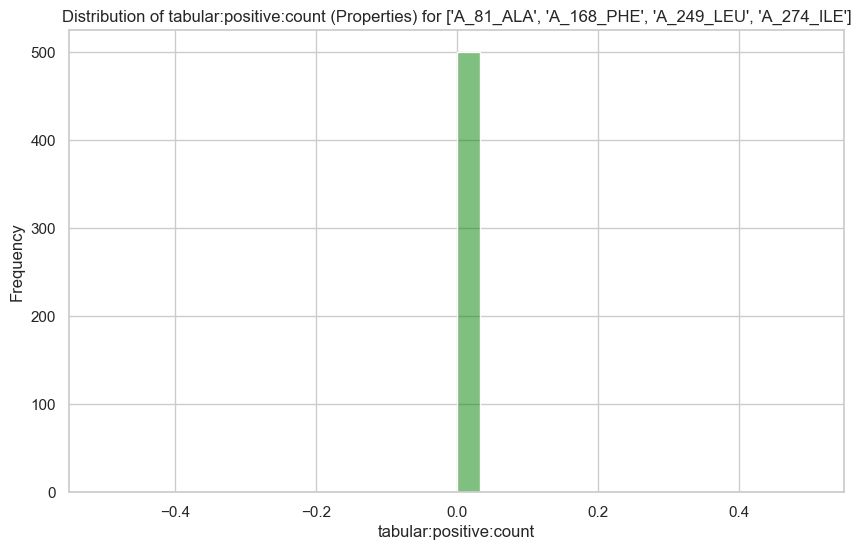

  Property - tabular:negative:count: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


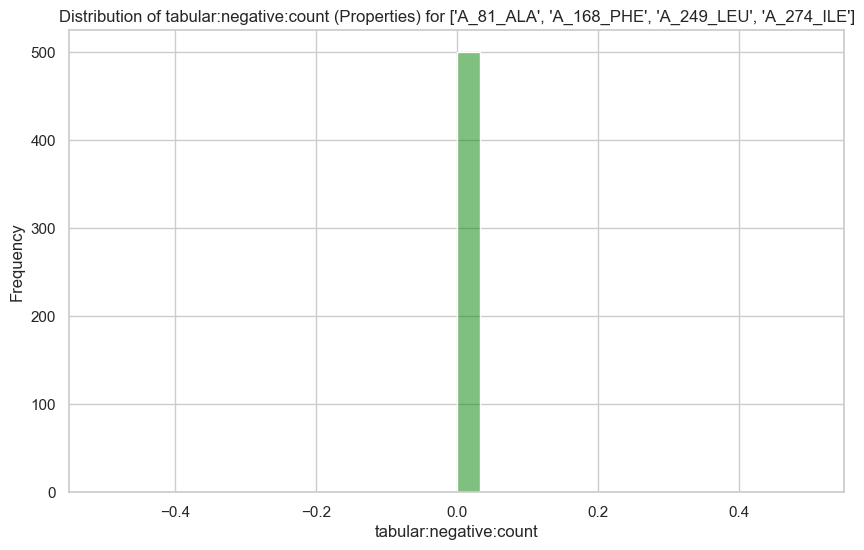

  Property - tabular:polar:count: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


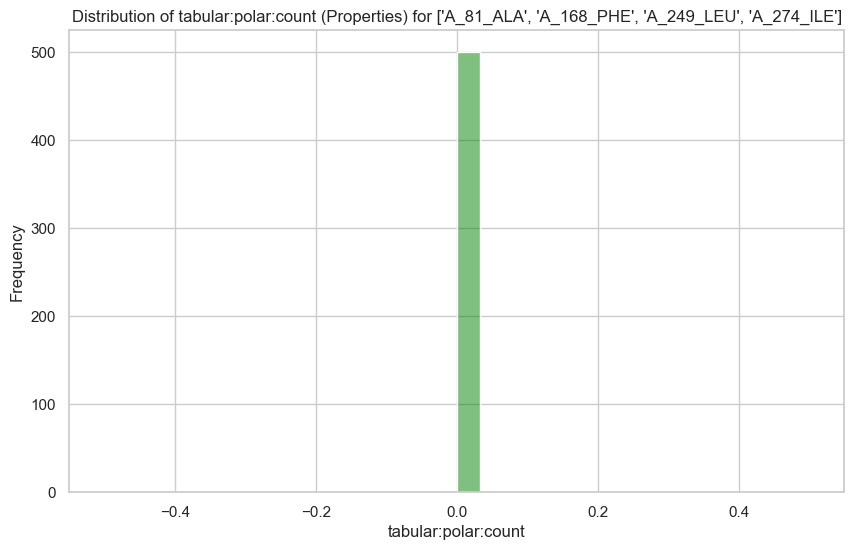

  Property - tabular:aromatic:count: mean=1.002271815890539, median=1.00175603724362, quantiles={0.25: 0.9522446833252574, 0.5: 1.00175603724362, 0.75: 1.0550304259547394}


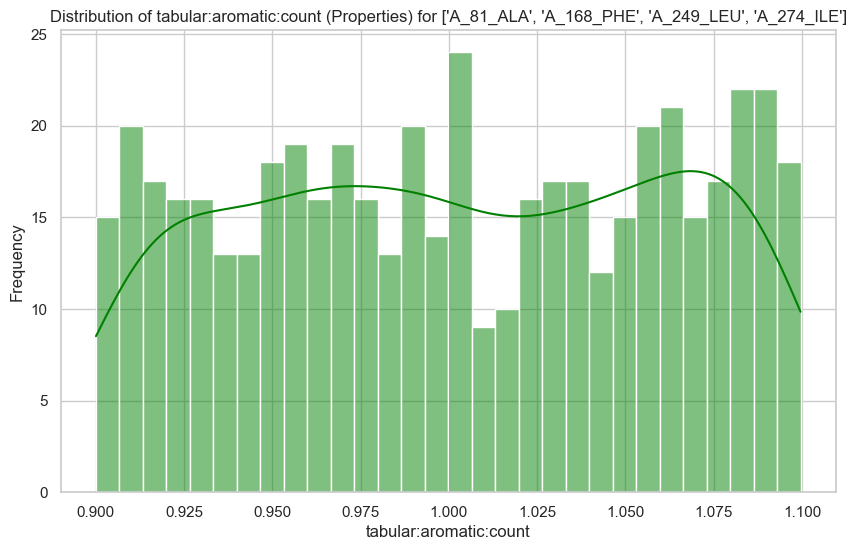

  Property - tabular:hydrophobic:count: mean=3.9911610533638386, median=3.9835944074757568, quantiles={0.25: 3.770264048766169, 0.5: 3.9835944074757568, 0.75: 4.2063105079267356}


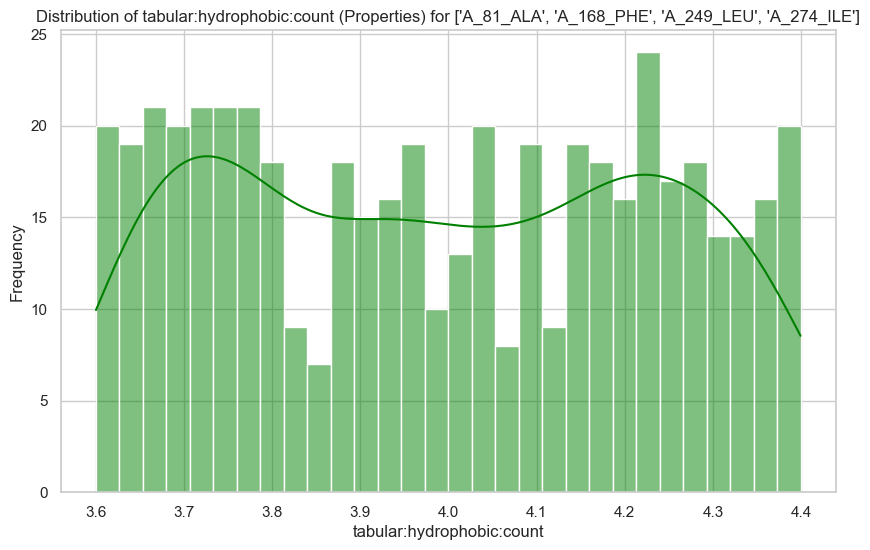

  Property - structure:bfactor:min: mean=12.64917813552832, median=12.675583409615921, quantiles={0.25: 11.961310908559906, 0.5: 12.675583409615921, 0.75: 13.30113148949831}


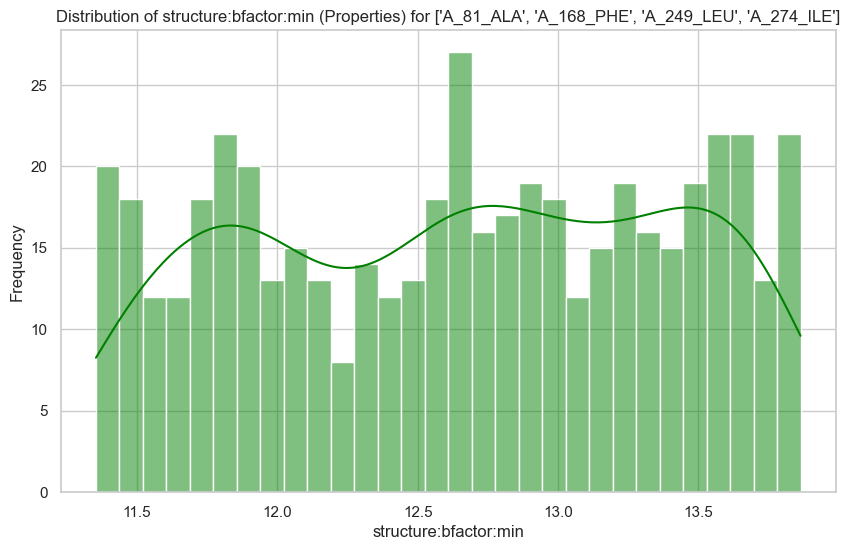

  Property - structure:bfactor:max: mean=24.169893063745942, median=24.256563633869895, quantiles={0.25: 22.890694631858665, 0.5: 24.256563633869895, 0.75: 25.33111789981104}


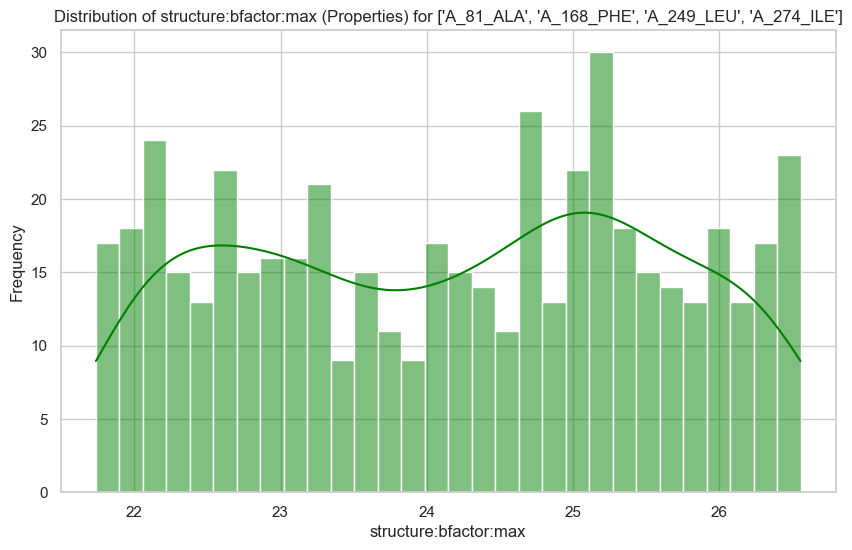

  Property - structure:bfactor:mean: mean=16.275679268213686, median=16.257046208247182, quantiles={0.25: 15.516682940697656, 0.5: 16.257046208247182, 0.75: 17.07284895768263}


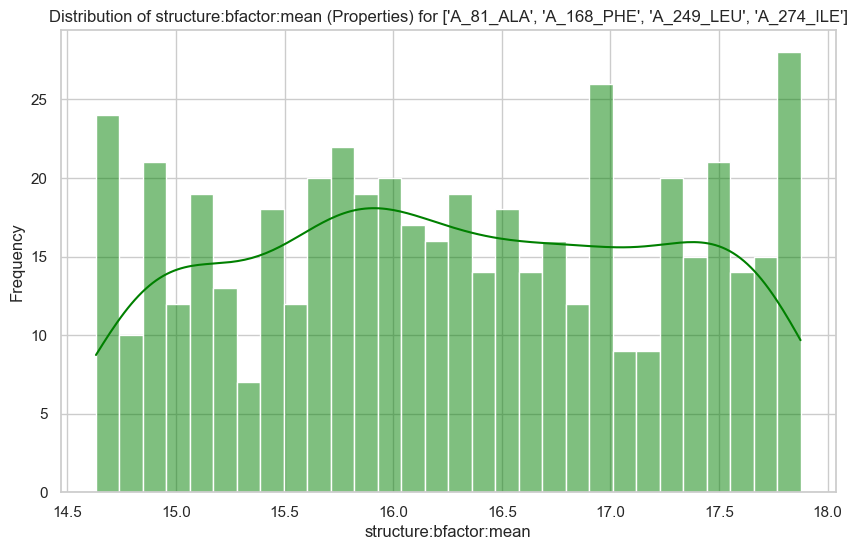

  Property - structure:bfactor:std: mean=2.435028852794973, median=2.4335430562706923, quantiles={0.25: 2.3301489232873904, 0.5: 2.4335430562706923, 0.75: 2.542595018243026}


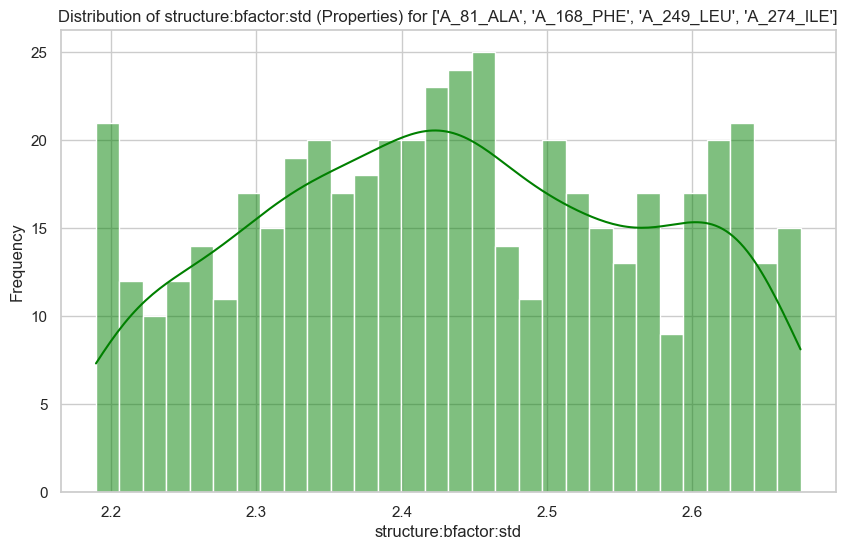

  Property - structure:bfactor:diff: mean=-0.8270379584715288, median=-0.8262931521564064, quantiles={0.25: -0.8675885439613646, 0.5: -0.8262931521564064, 0.75: -0.7843493425255996}


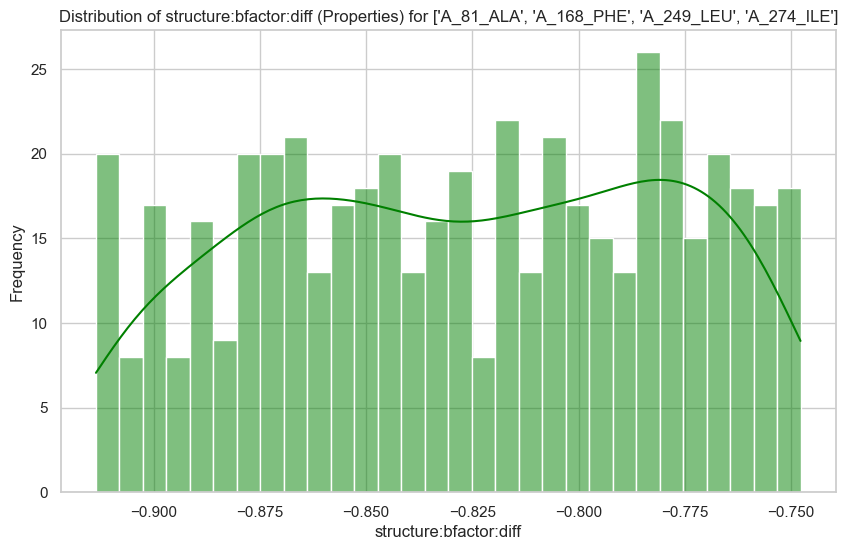

  Property - secondary_structure_dssp:count:ss8:pi-helix: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


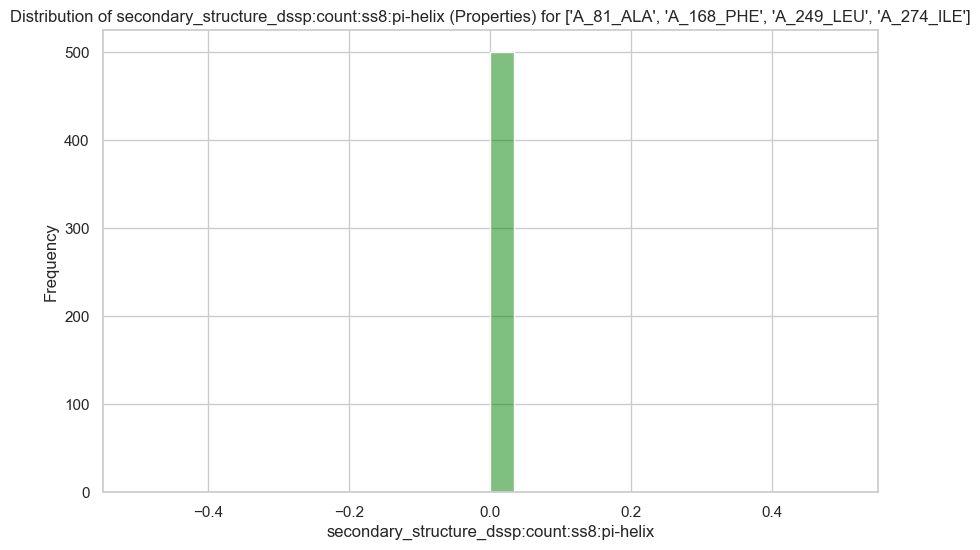

  Property - secondary_structure_dssp:count:ss8:bend: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


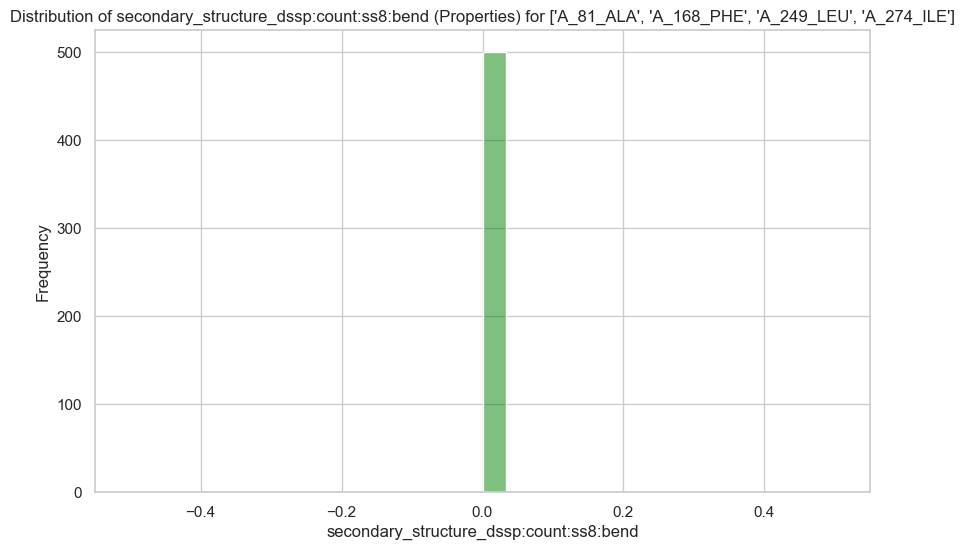

  Property - secondary_structure_dssp:count:ss8:coil: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


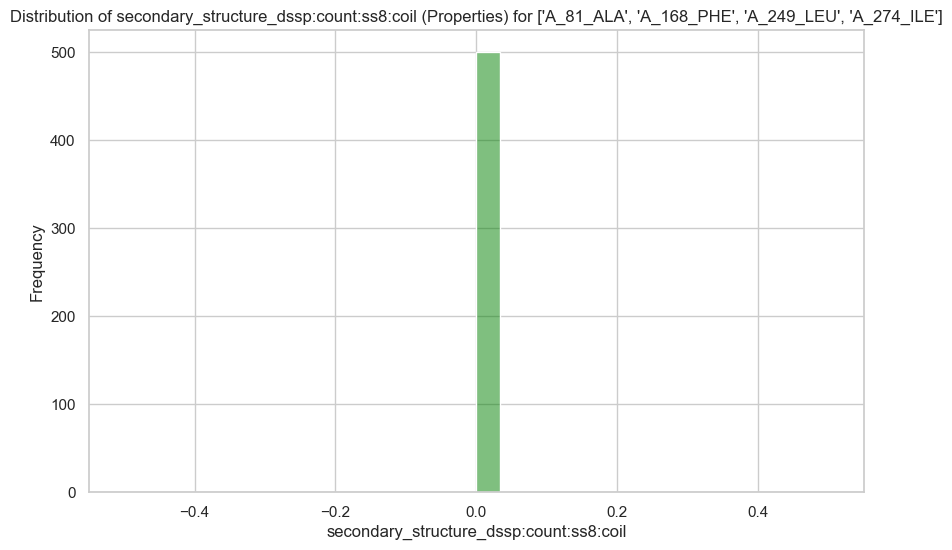

  Property - secondary_structure_dssp:count:ss8:3-10-helix: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


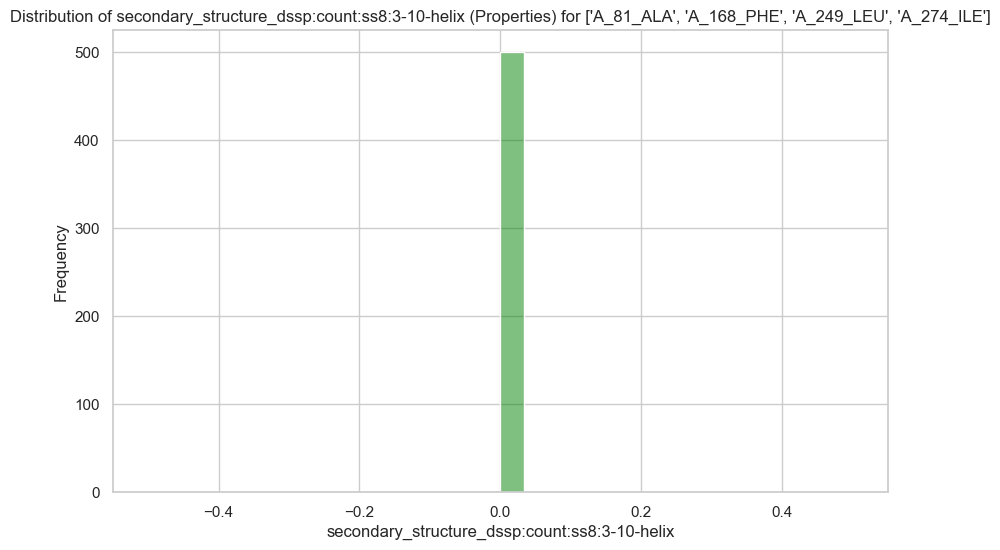

  Property - secondary_structure_dssp:count:ss8:alpha-helix: mean=3.983788215998066, median=3.9724877922904156, quantiles={0.25: 3.7828813192762816, 0.5: 3.9724877922904156, 0.75: 4.184983385590428}


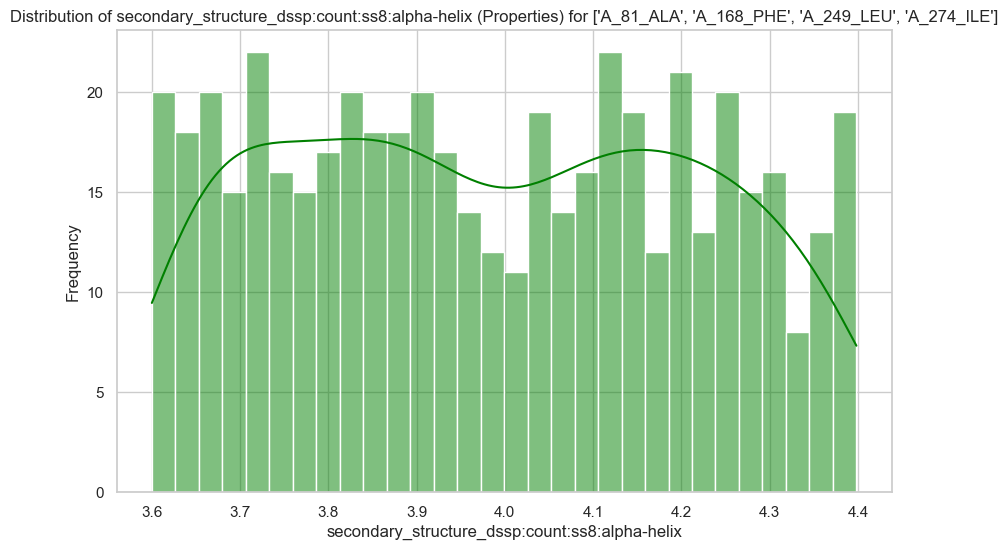

  Property - secondary_structure_dssp:count:ss8:h-bonded_turn: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


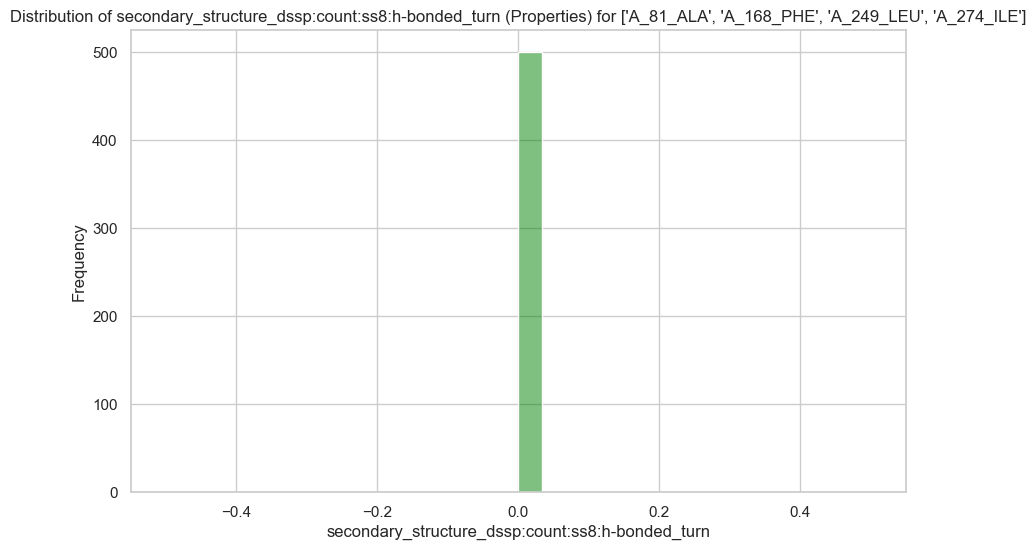

  Property - secondary_structure_dssp:count:ss8:isolated_beta-bridge: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


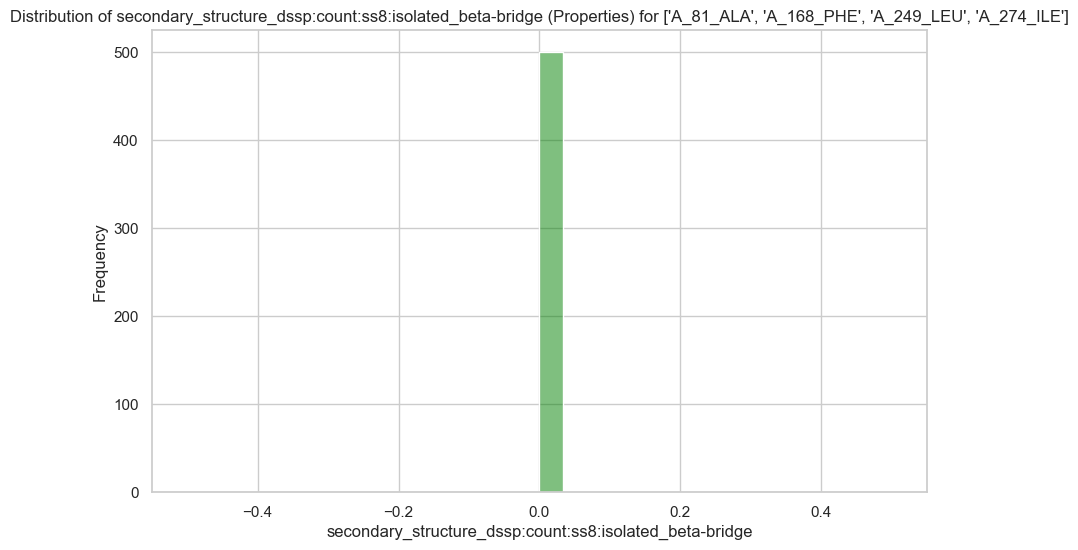

  Property - secondary_structure_dssp:count:ss8:extended_strand: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


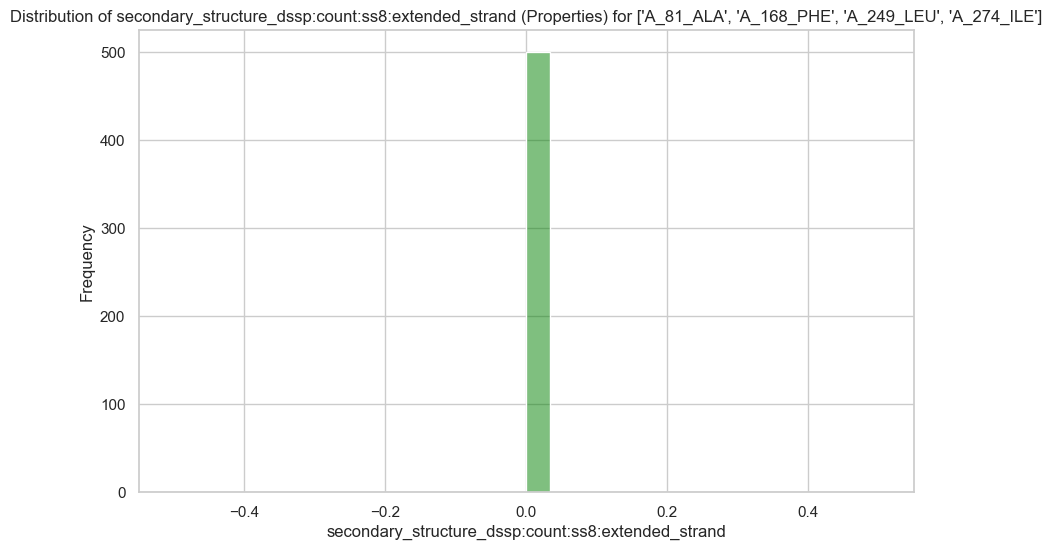

  Property - secondary_structure_dssp:count:ss8:kappa-helix: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


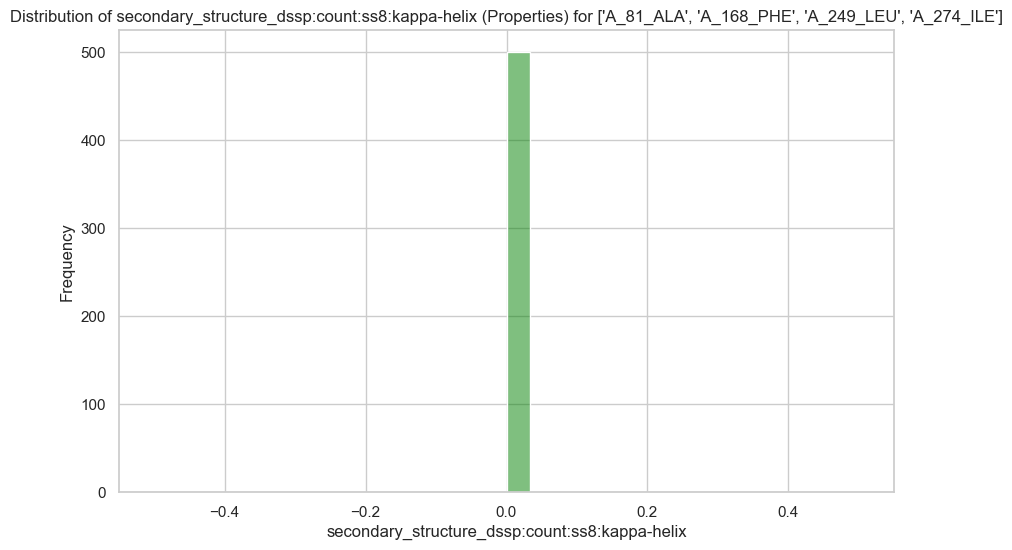

  Property - secondary_structure_dssp:count:ss3:loop: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


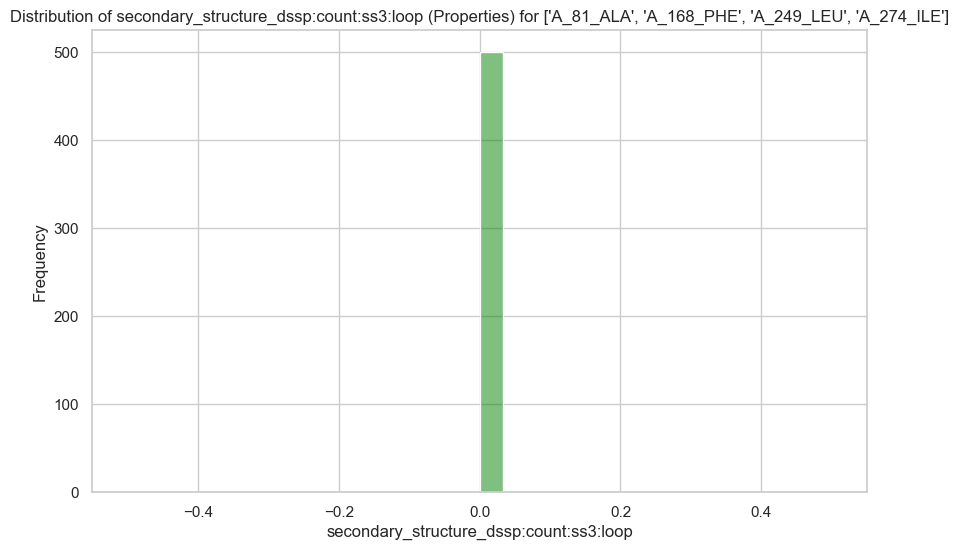

  Property - secondary_structure_dssp:count:ss3:helix: mean=3.982668889518568, median=3.9755955293741665, quantiles={0.25: 3.7965576965721275, 0.5: 3.9755955293741665, 0.75: 4.176463029681232}


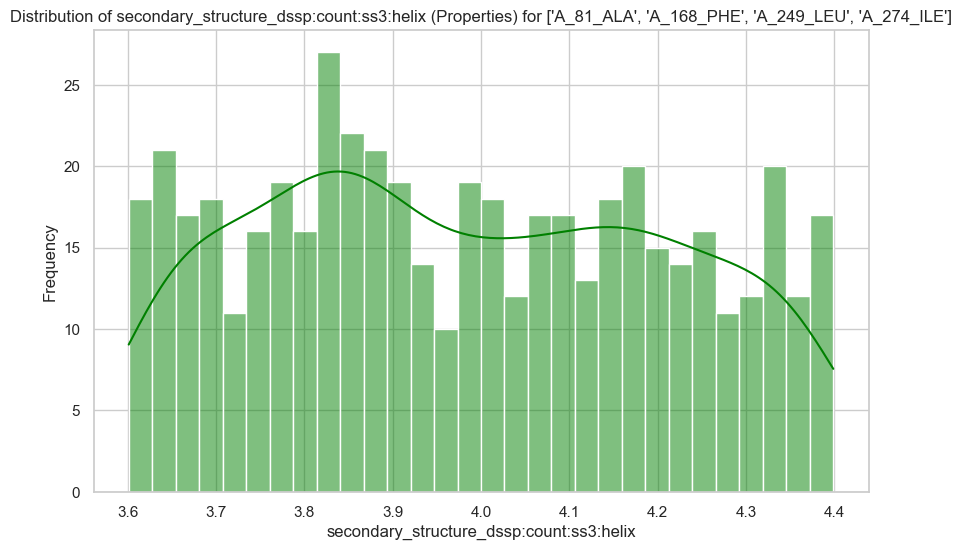

  Property - secondary_structure_dssp:count:ss3:strand: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


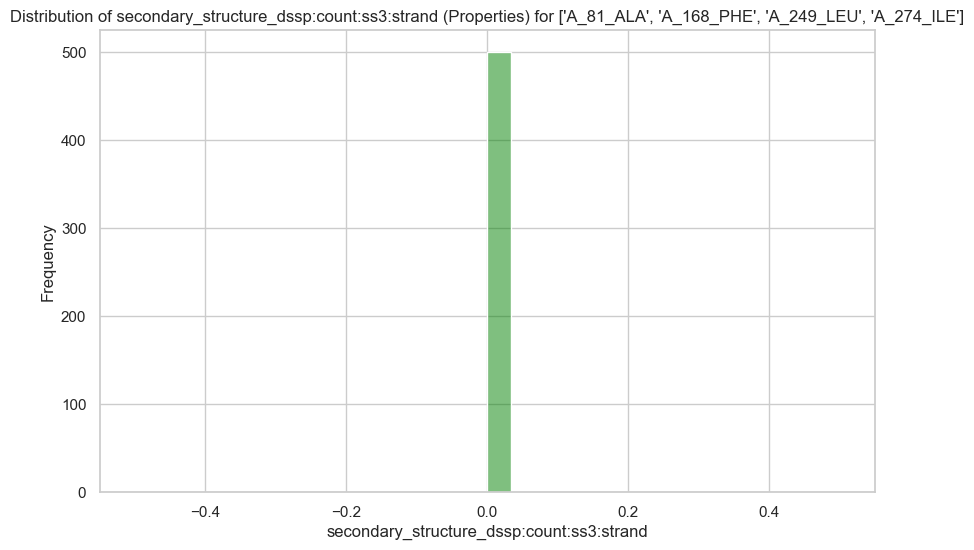

  Property - secondary_structure_dssp:fraction:ss8:pi-helix: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


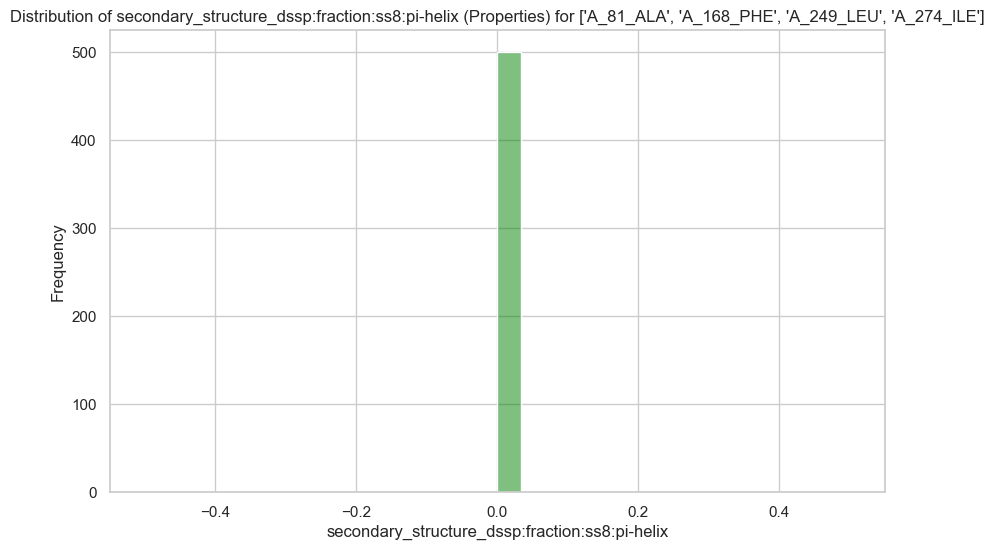

  Property - secondary_structure_dssp:fraction:ss8:bend: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


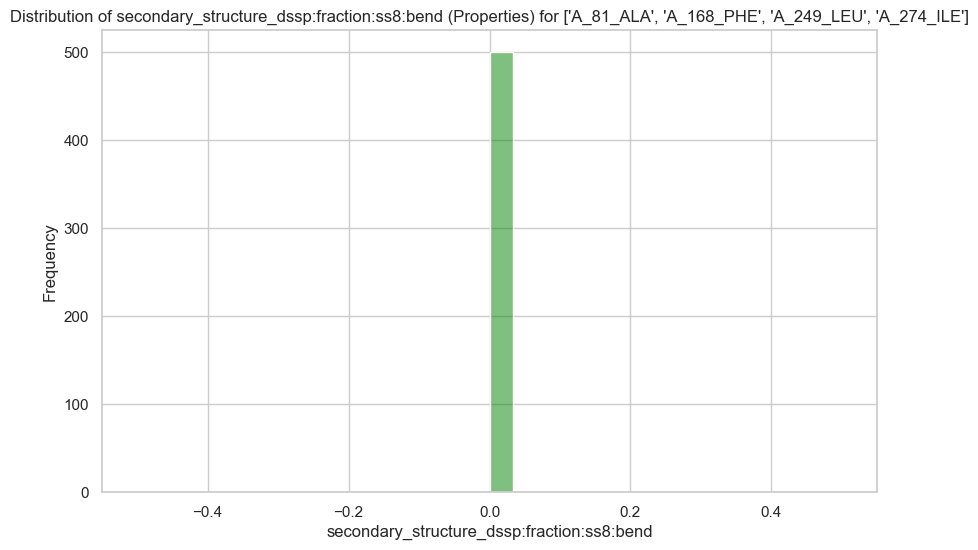

  Property - secondary_structure_dssp:fraction:ss8:coil: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


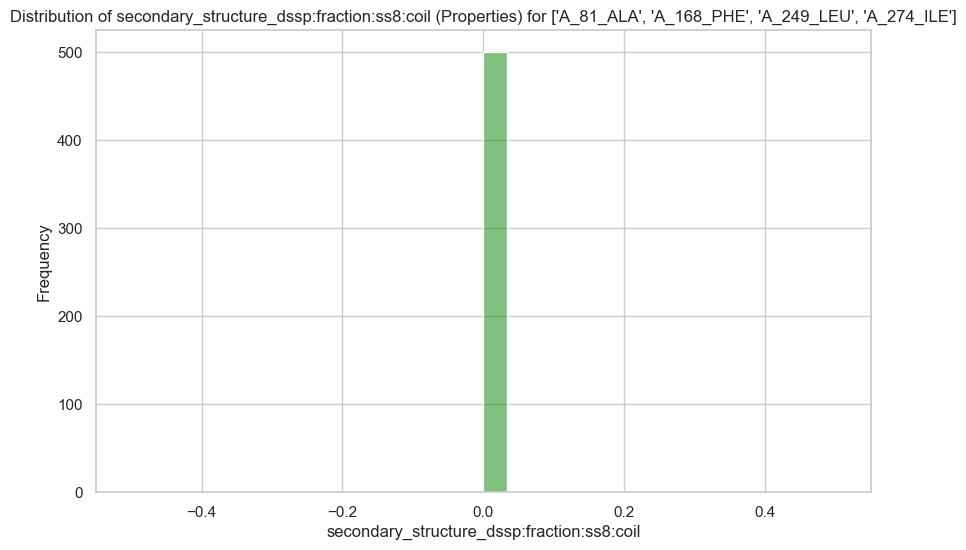

  Property - secondary_structure_dssp:fraction:ss8:3-10-helix: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


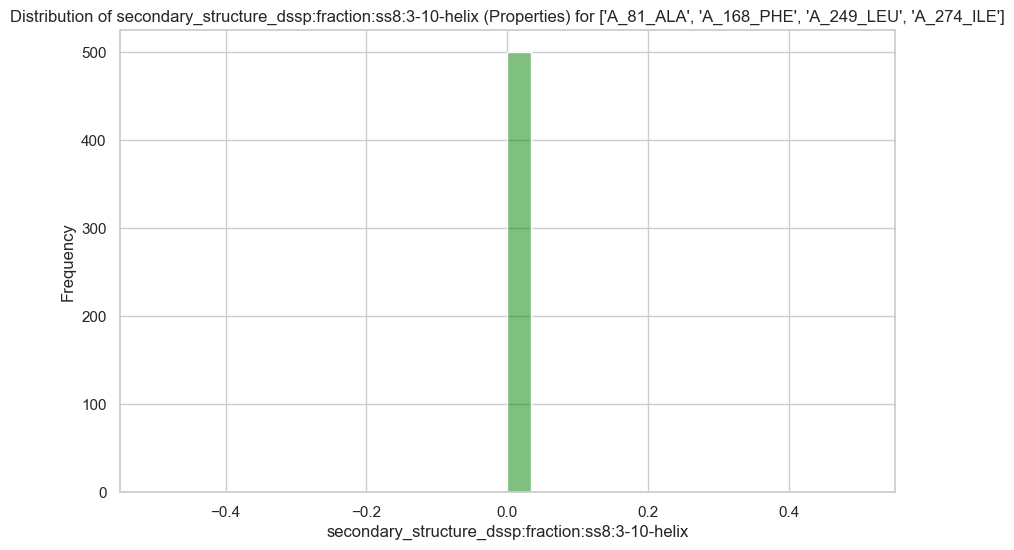

  Property - secondary_structure_dssp:fraction:ss8:alpha-helix: mean=0.9926564105199529, median=0.9908939806734359, quantiles={0.25: 0.9435067614894005, 0.5: 0.9908939806734359, 0.75: 1.0392645535985607}


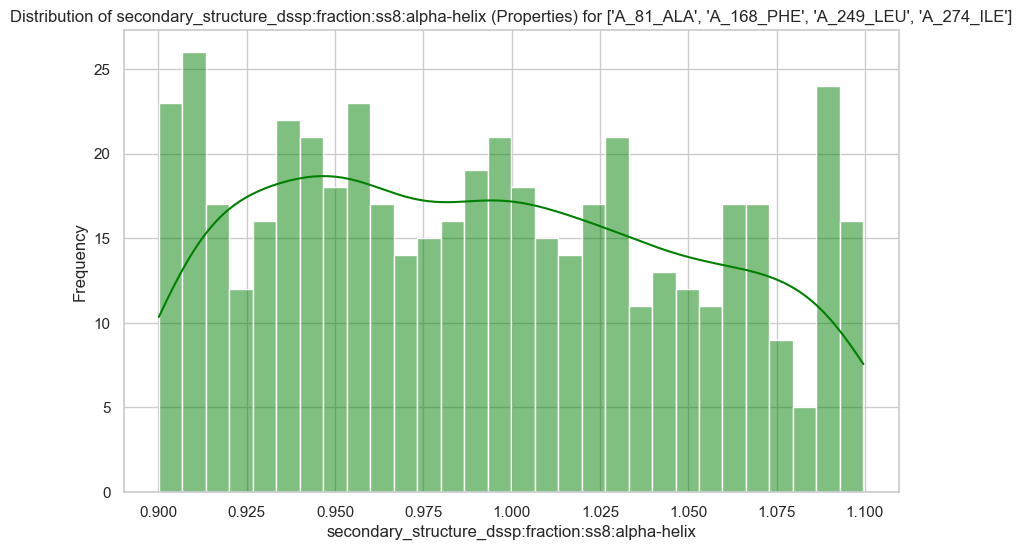

  Property - secondary_structure_dssp:fraction:ss8:h-bonded_turn: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


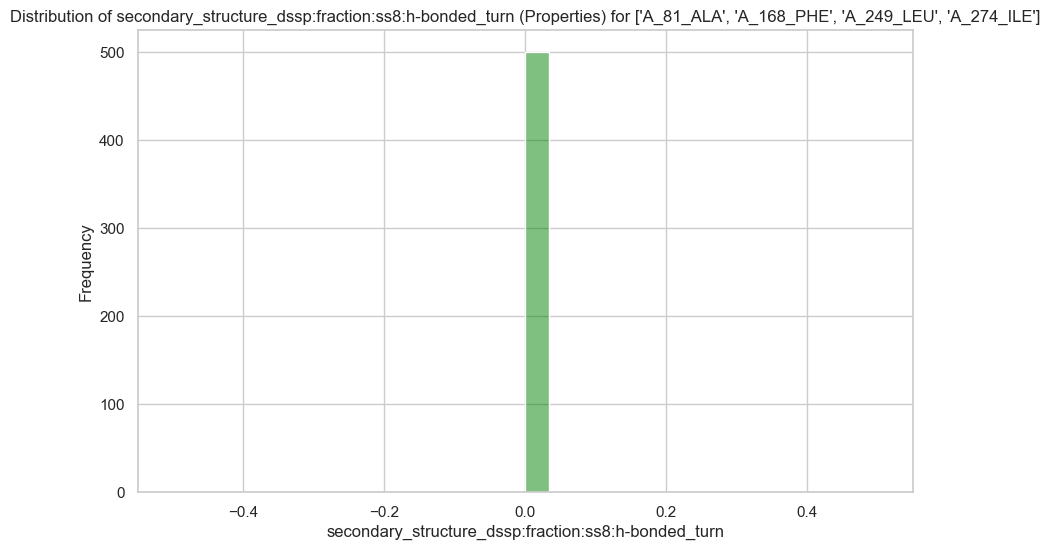

  Property - secondary_structure_dssp:fraction:ss8:isolated_beta-bridge: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


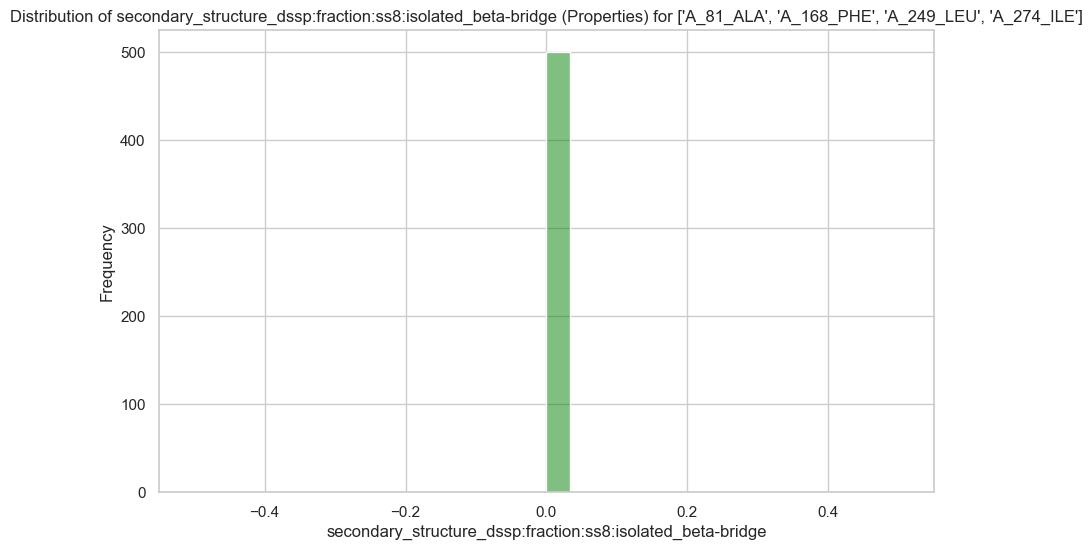

  Property - secondary_structure_dssp:fraction:ss8:extended_strand: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


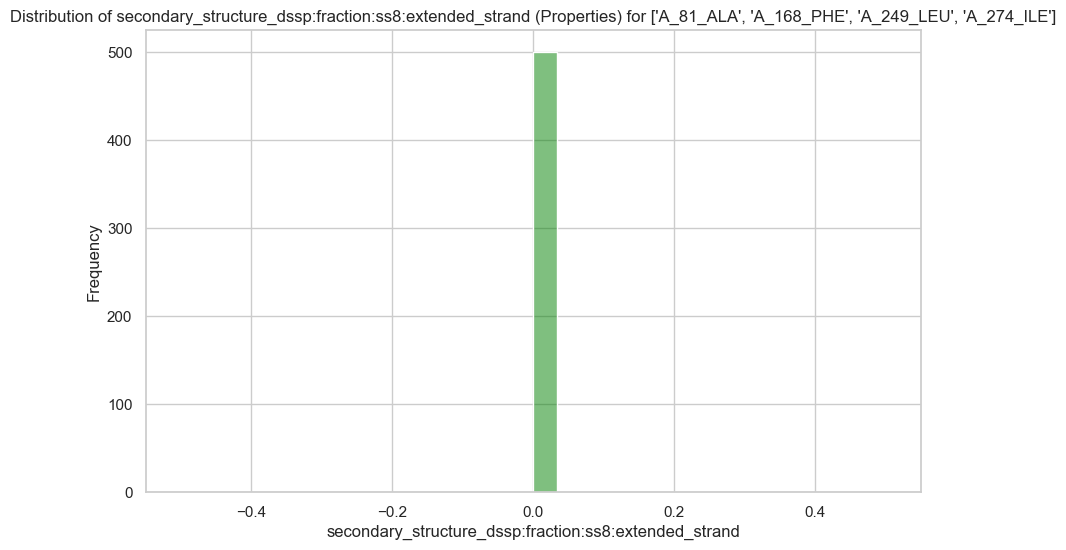

  Property - secondary_structure_dssp:fraction:ss8:kappa-helix: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


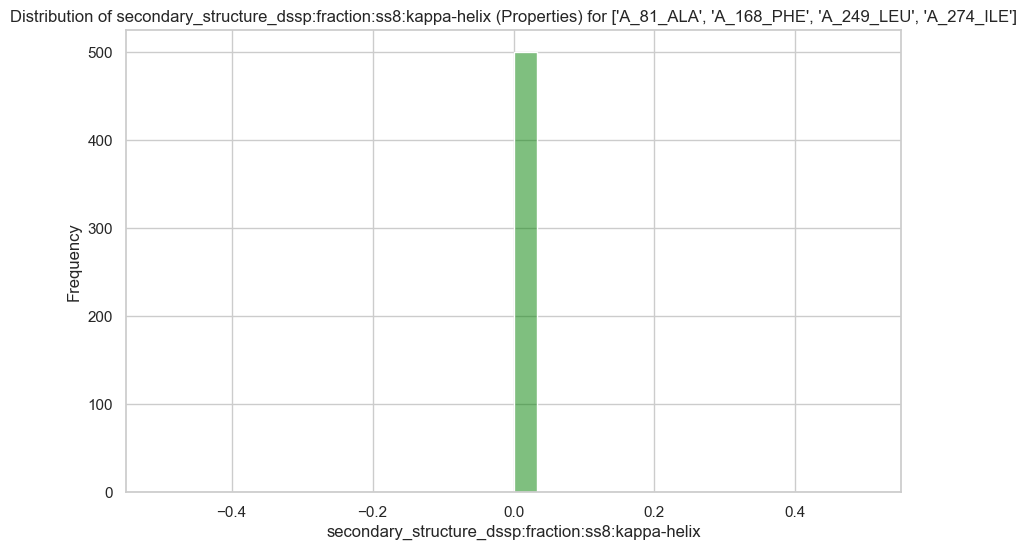

  Property - secondary_structure_dssp:fraction:ss3:loop: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


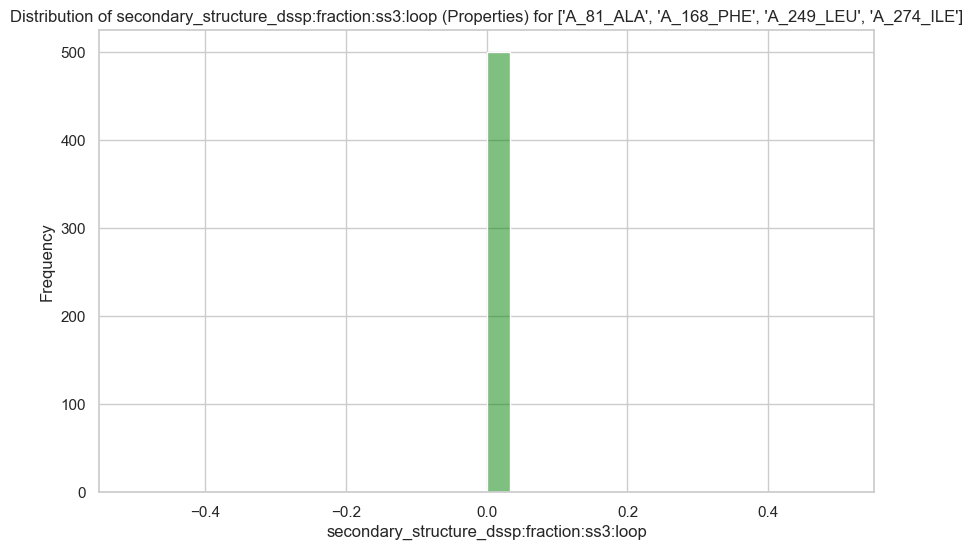

  Property - secondary_structure_dssp:fraction:ss3:helix: mean=1.0011065177339606, median=1.0010248919449158, quantiles={0.25: 0.9547328518252819, 0.5: 1.0010248919449158, 0.75: 1.0506105002155521}


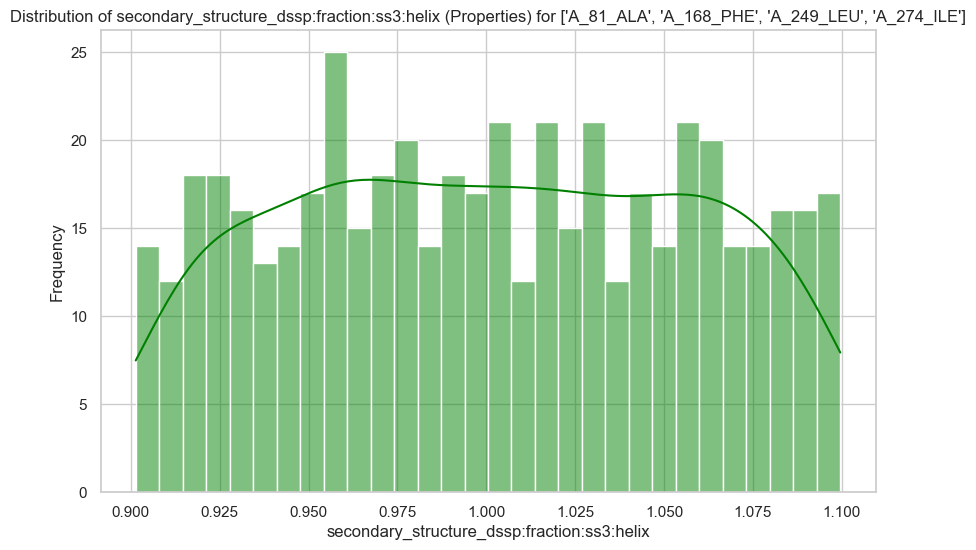

  Property - secondary_structure_dssp:fraction:ss3:strand: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


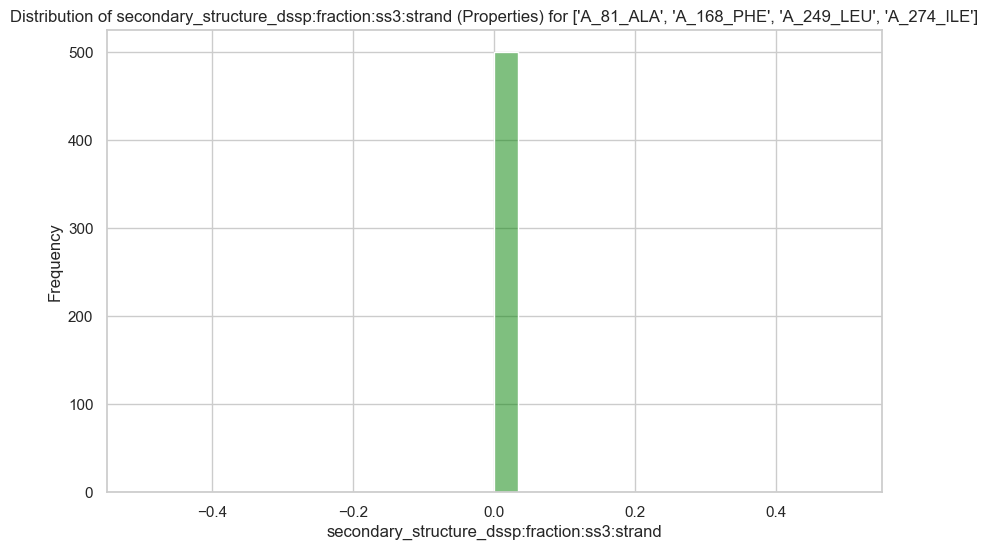

  Property - energies_pyrosetta:fa_atr: mean=-26.059203256955193, median=-26.072921851306198, quantiles={0.25: -27.31763309966943, 0.5: -26.072921851306198, 0.75: -24.777169870824903}


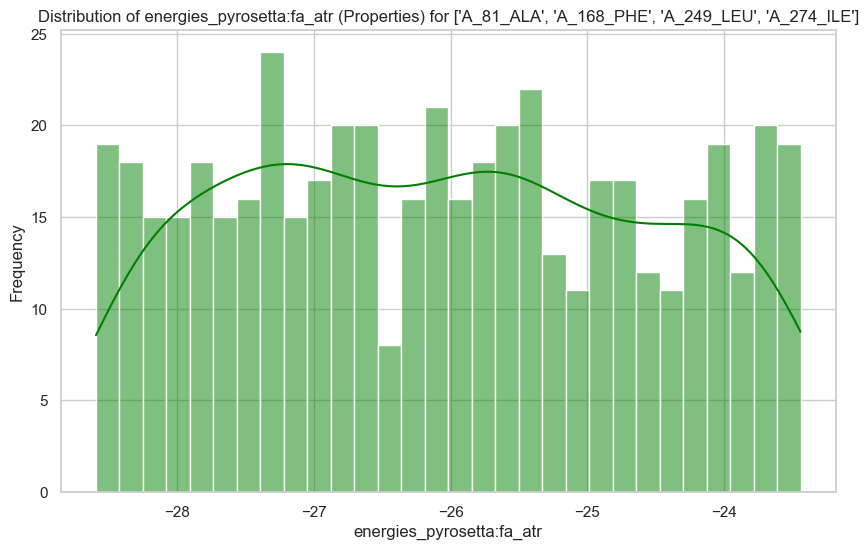

  Property - energies_pyrosetta:fa_rep: mean=3.213483536142996, median=3.2119259250892656, quantiles={0.25: 3.0318243686102484, 0.5: 3.2119259250892656, 0.75: 3.3820352349182707}


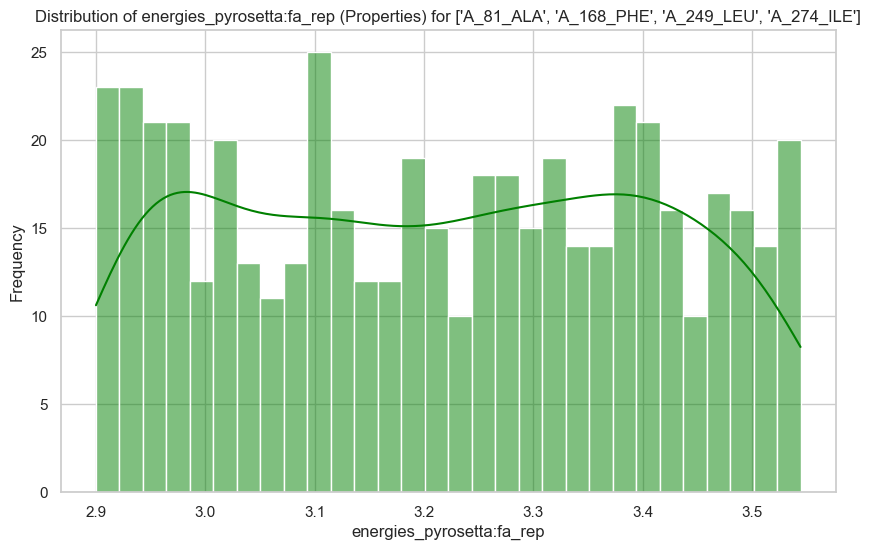

  Property - energies_pyrosetta:fa_sol: mean=9.853304870557883, median=9.822042486755947, quantiles={0.25: 9.409722288973603, 0.5: 9.822042486755947, 0.75: 10.310196916764323}


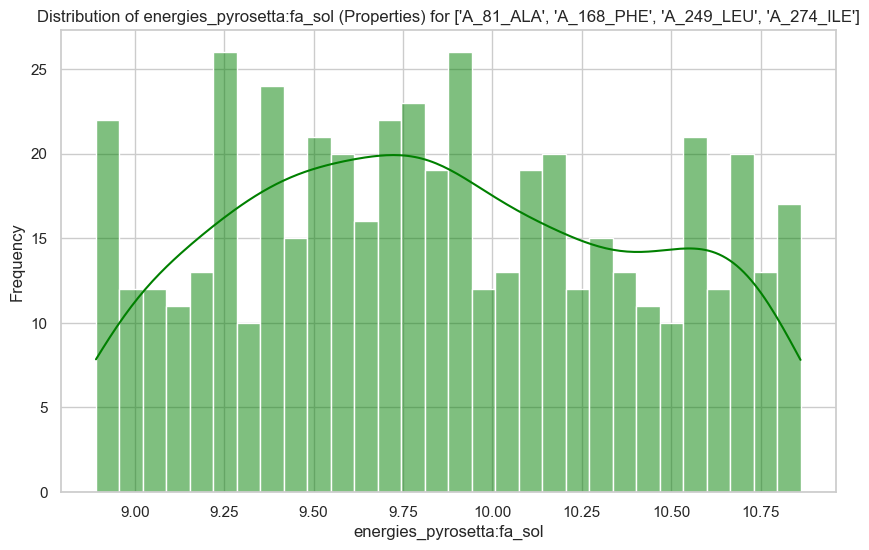

  Property - energies_pyrosetta:fa_elec: mean=-5.394861726039826, median=-5.392372743894608, quantiles={0.25: -5.656870707172633, 0.5: -5.392372743894608, 0.75: -5.142582528655664}


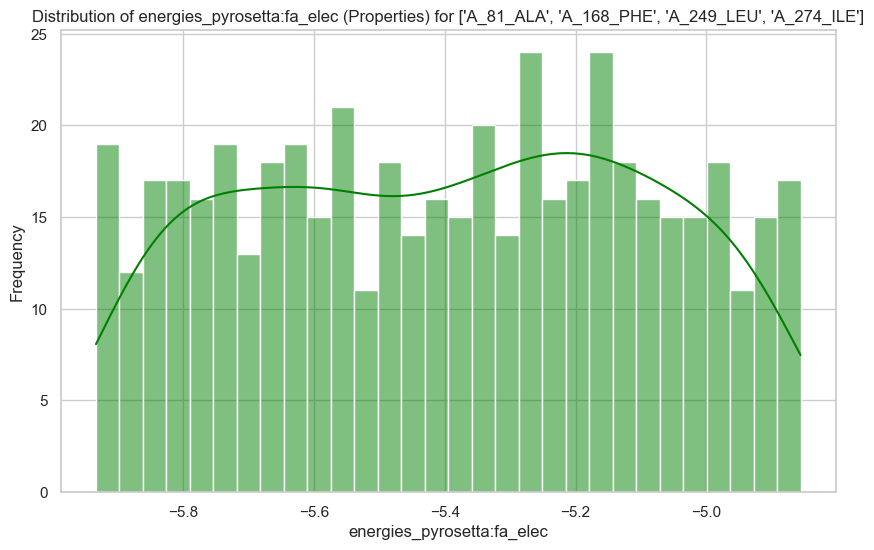

  Property - energies_pyrosetta:total_score: mean=-2.47132002762755, median=-2.4746812016983997, quantiles={0.25: -2.5869491709207804, 0.5: -2.4746812016983997, 0.75: -2.3378305726476025}


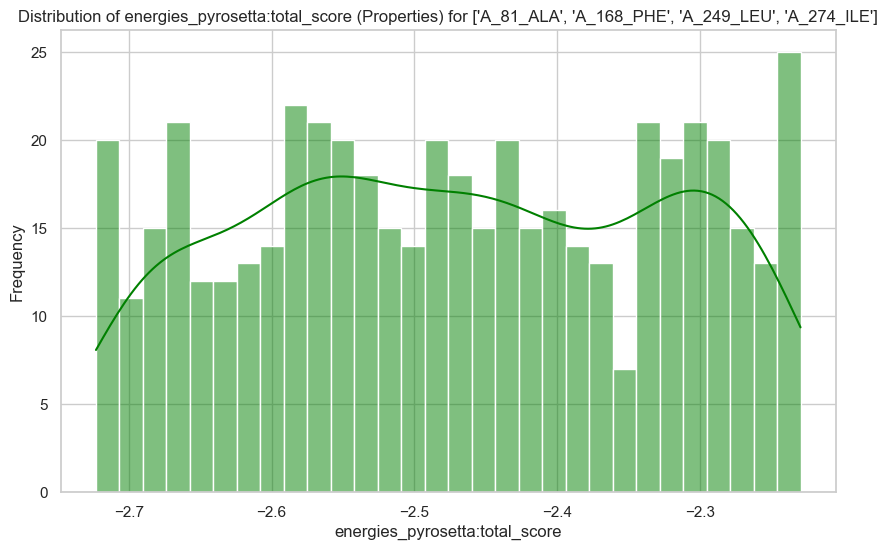

  Property - electrostatic_pdb2pqr:atom_charge: mean=-3.4238691823996654, median=-3.431319691980991, quantiles={0.25: -3.600582776132779, 0.5: -3.431319691980991, 0.75: -3.259211717478848}


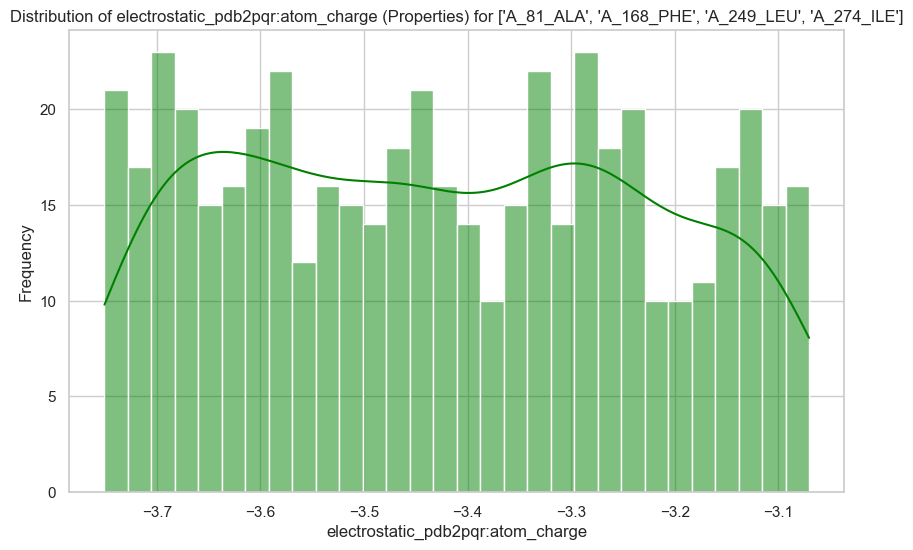

  Property - electrostatic_pdb2pqr:residue_charge: mean=-6.925631400437877e-18, median=-6.908727591203673e-18, quantiles={0.25: -7.259708639602995e-18, 0.5: -6.908727591203673e-18, 0.75: -6.60851861362312e-18}


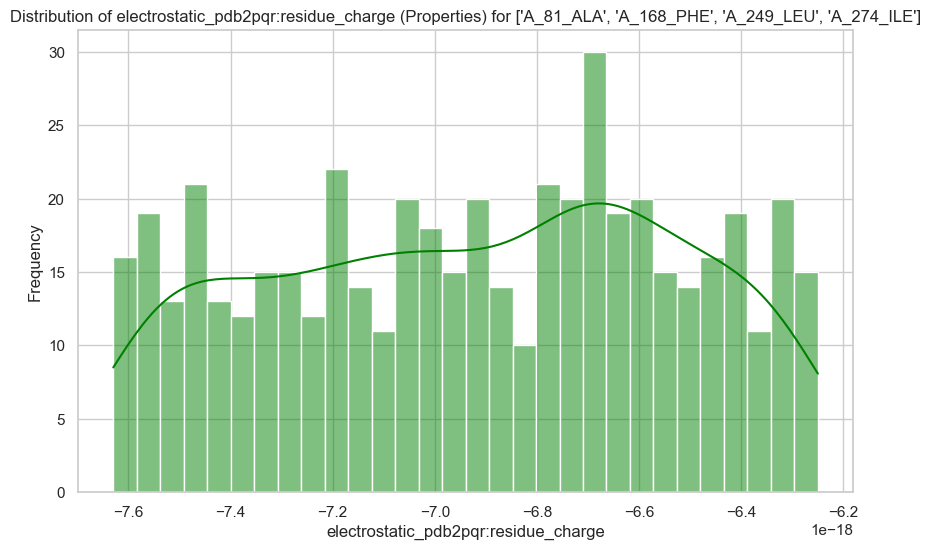

  Property - surface_freesasa:sasa:polar: mean=6.668360371957299, median=6.6846647254146525, quantiles={0.25: 6.361579436205484, 0.5: 6.6846647254146525, 0.75: 6.97643566407086}


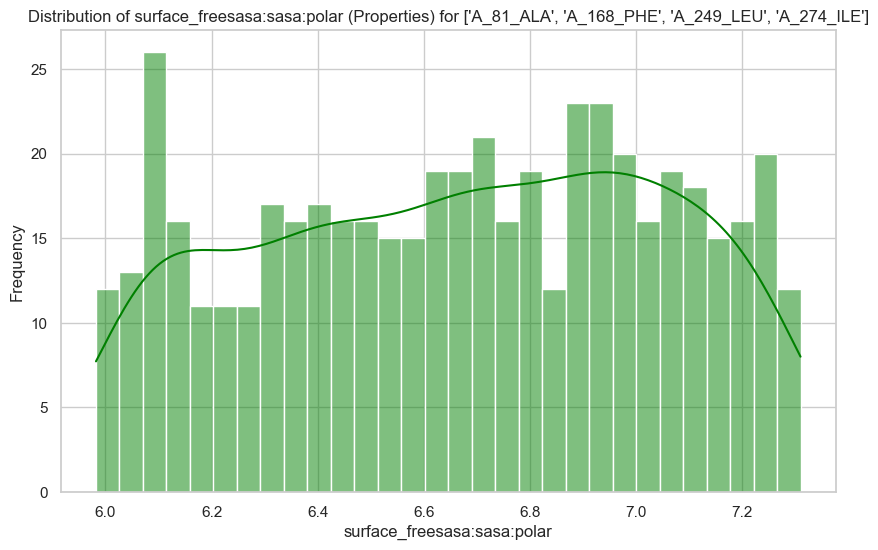

  Property - surface_freesasa:sasa:apolar: mean=119.95824391505916, median=119.73284373057474, quantiles={0.25: 114.59686810535143, 0.5: 119.73284373057474, 0.75: 125.7109503185626}


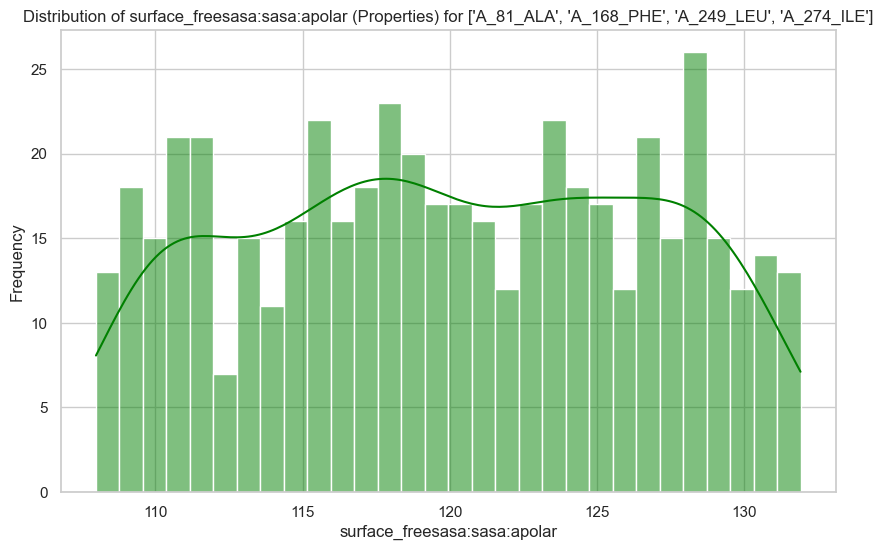

  Property - surface_freesasa:sasa:total: mean=126.82227420451949, median=126.86650445278883, quantiles={0.25: 120.00960975862805, 0.5: 126.86650445278883, 0.75: 133.53205334605002}


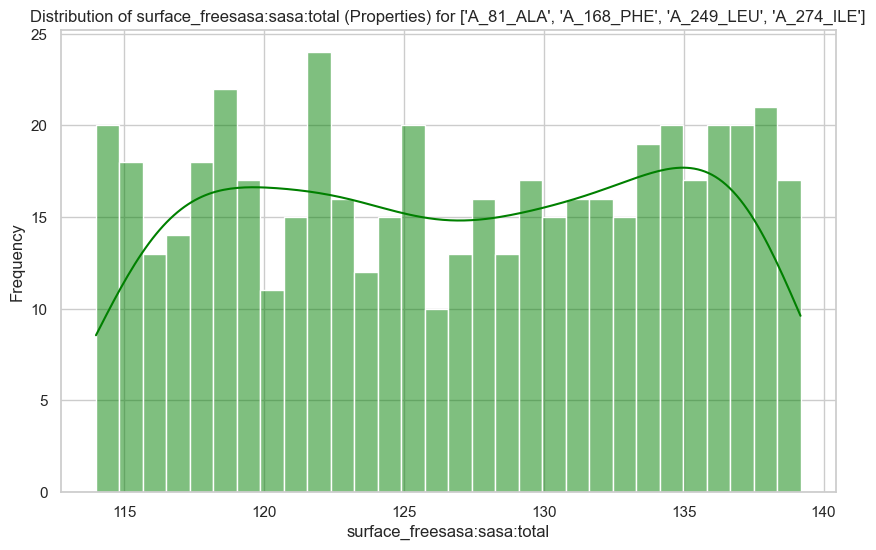

  Property - surface_freesasa:sasa_atoms: mean=126.85031274255614, median=126.89529051576432, quantiles={0.25: 119.93322912647679, 0.5: 126.89529051576432, 0.75: 134.1028929555905}


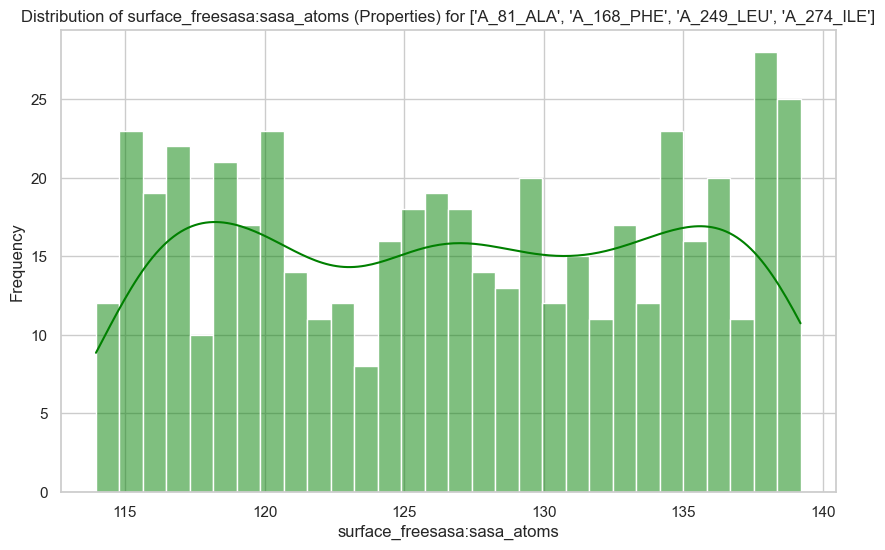

  Property - surface_msms:sum_ses:atoms: mean=154.6797747745655, median=154.13263680462424, quantiles={0.25: 147.40782273068555, 0.5: 154.13263680462424, 0.75: 161.61194555019117}


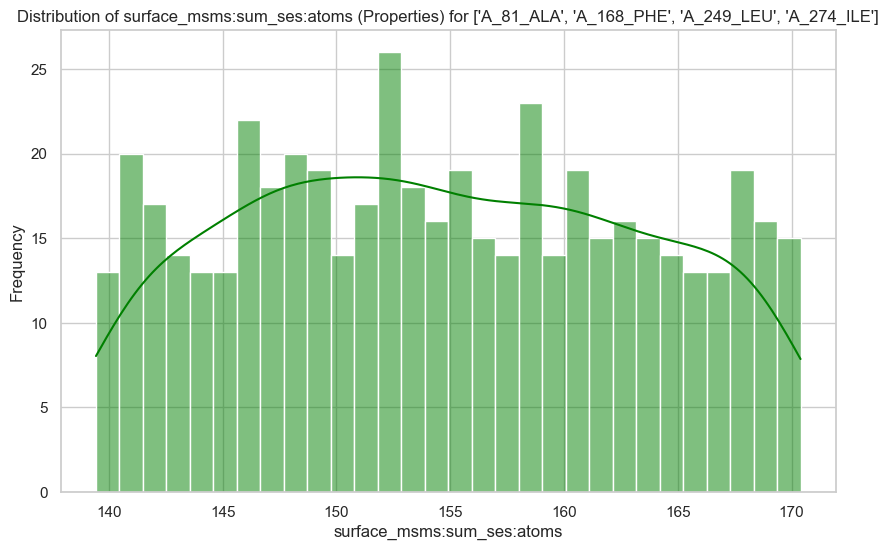

  Property - surface_msms:sum_sas:atoms: mean=122.2185171690705, median=122.05211653490318, quantiles={0.25: 116.01942915103905, 0.5: 122.05211653490318, 0.75: 128.194598757944}


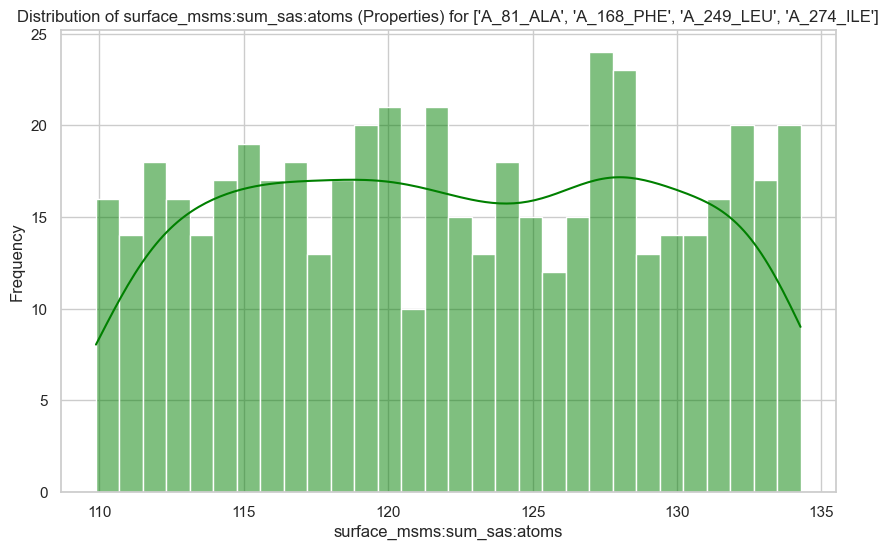

  Property - surface_msms:sum_ses:residues: mean=154.74749310416917, median=154.87550010503918, quantiles={0.25: 147.29292553832917, 0.5: 154.87550010503918, 0.75: 162.94952439142895}


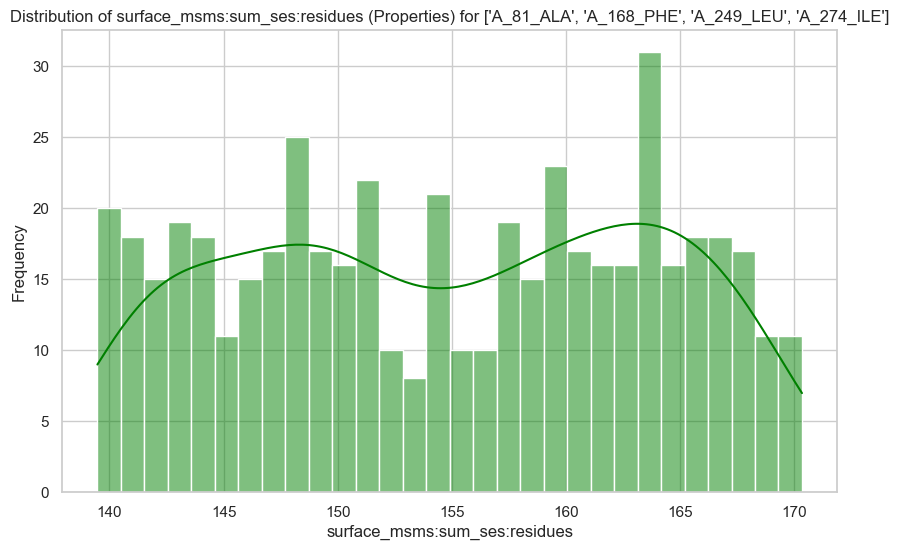

  Property - surface_msms:sum_sas:residues: mean=121.63294293434338, median=121.53979165134281, quantiles={0.25: 115.11586435823548, 0.5: 121.53979165134281, 0.75: 127.75173148307707}


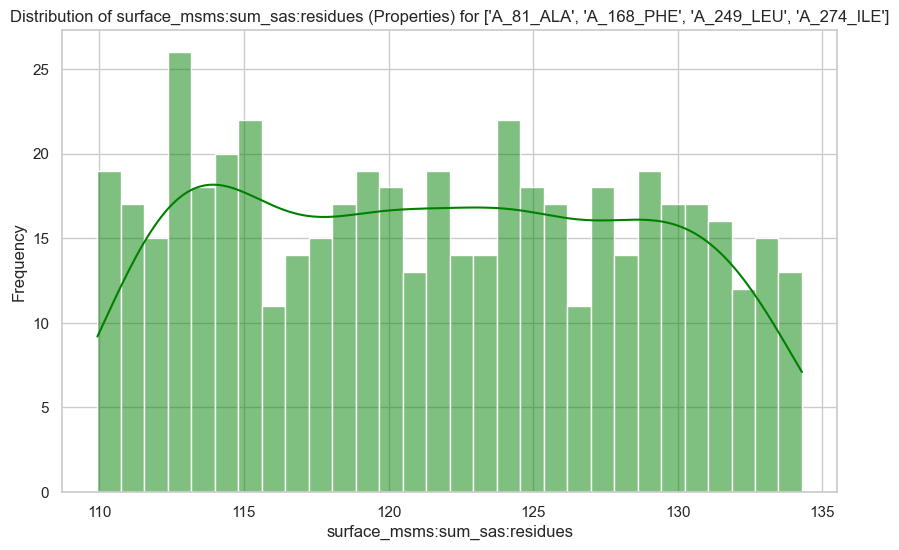

  Property - surface_msms:mean_normal: mean=0.14147117555201913, median=0.14145751466606832, quantiles={0.25: 0.13394663043093424, 0.5: 0.14145751466606832, 0.75: 0.14879982965152483}


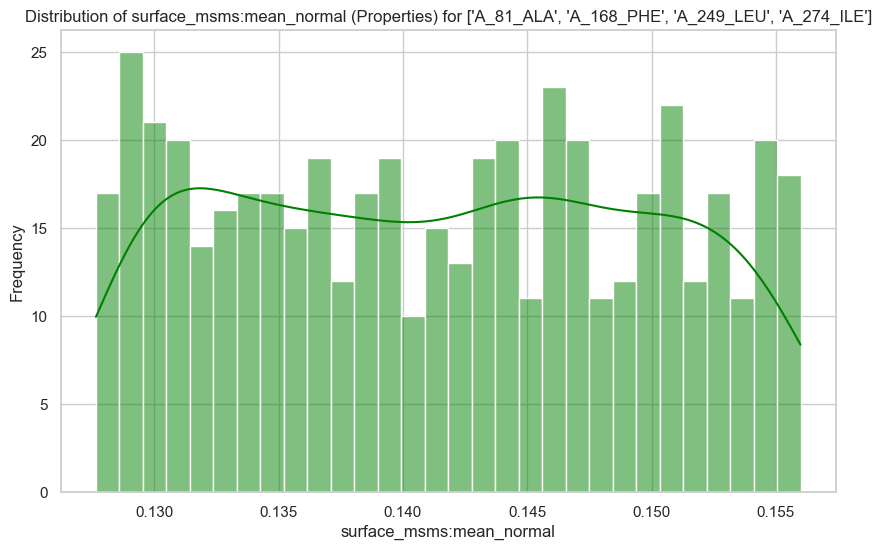

  Property - surface_msms:mean_curvature: mean=-0.06313178489801193, median=-0.06314962661300447, quantiles={0.25: -0.06620180148574976, 0.5: -0.06314962661300447, 0.75: -0.05984209836846625}


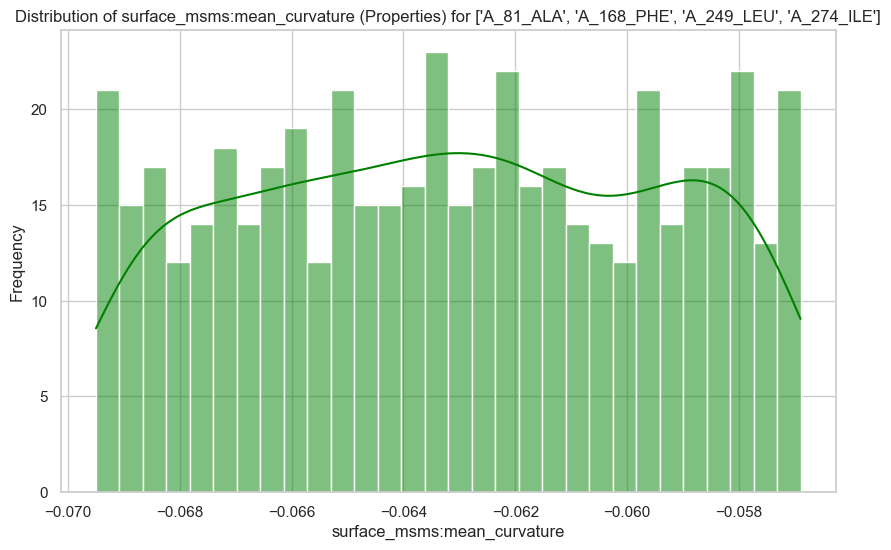

  Property - surface_custom:sasa:atoms: mean=126.45096427606578, median=126.18902593435935, quantiles={0.25: 120.10600325328402, 0.5: 126.18902593435935, 0.75: 132.73338815921463}


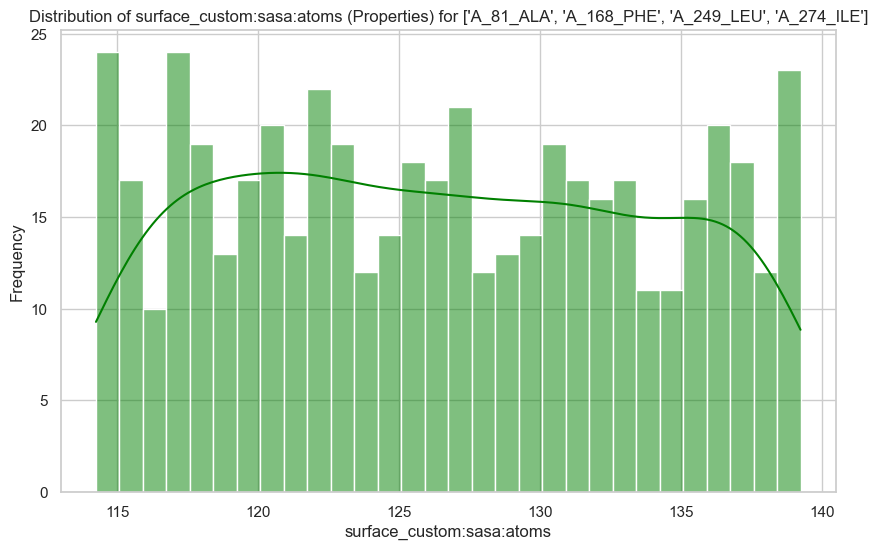

  Property - surface_custom:sasa:residues: mean=126.69249926430967, median=126.91390132727699, quantiles={0.25: 119.89644612386633, 0.5: 126.91390132727699, 0.75: 133.0578469592524}


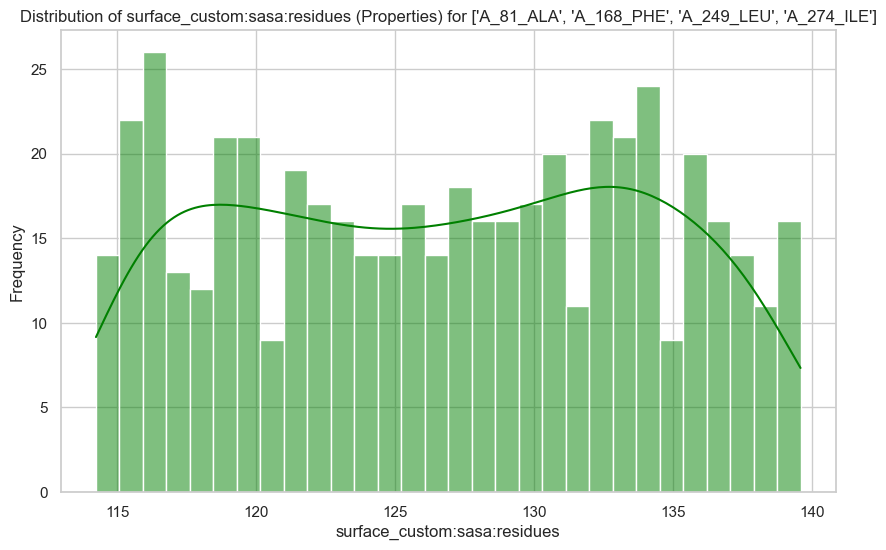

  Property - grid:atom_channel:0: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


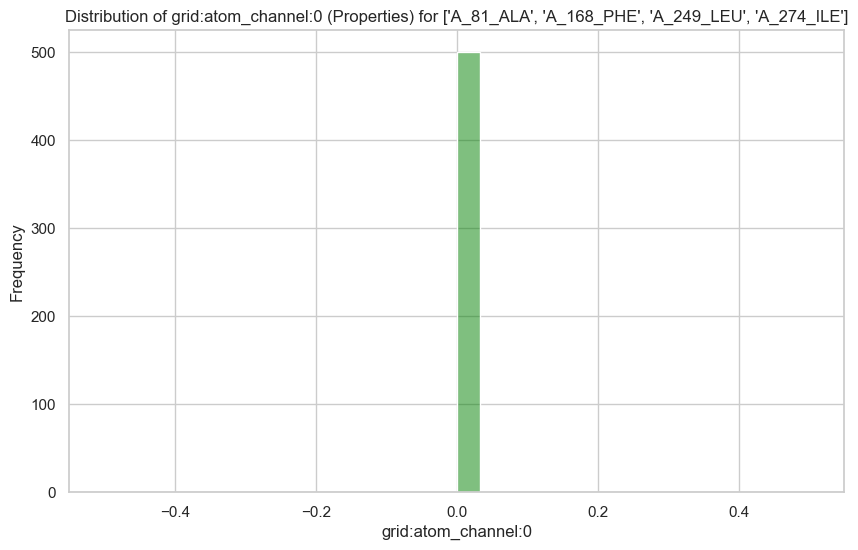

  Property - grid:atom_channel:1: mean=4.005187404387133, median=4.011426052558905, quantiles={0.25: 3.8049973803393695, 0.5: 4.011426052558905, 0.75: 4.204414387232088}


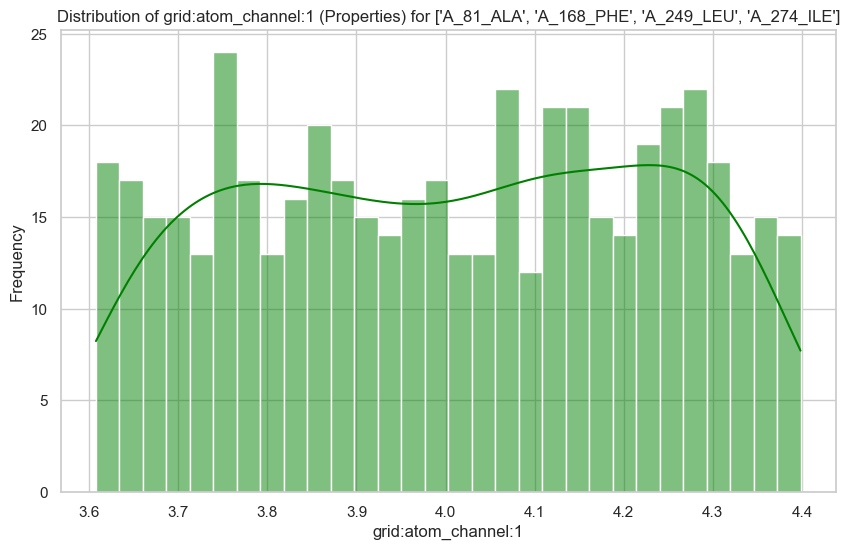

  Property - grid:atom_channel:2: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


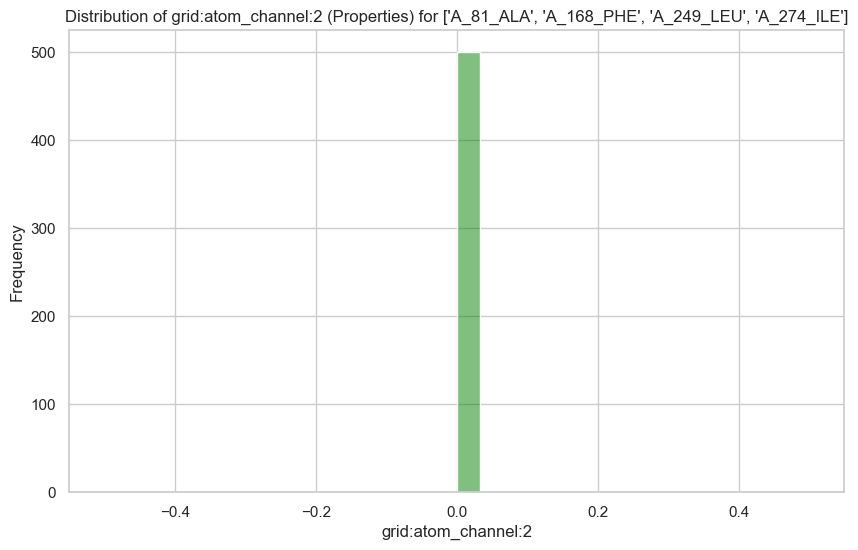

  Property - grid:atom_channel:3: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


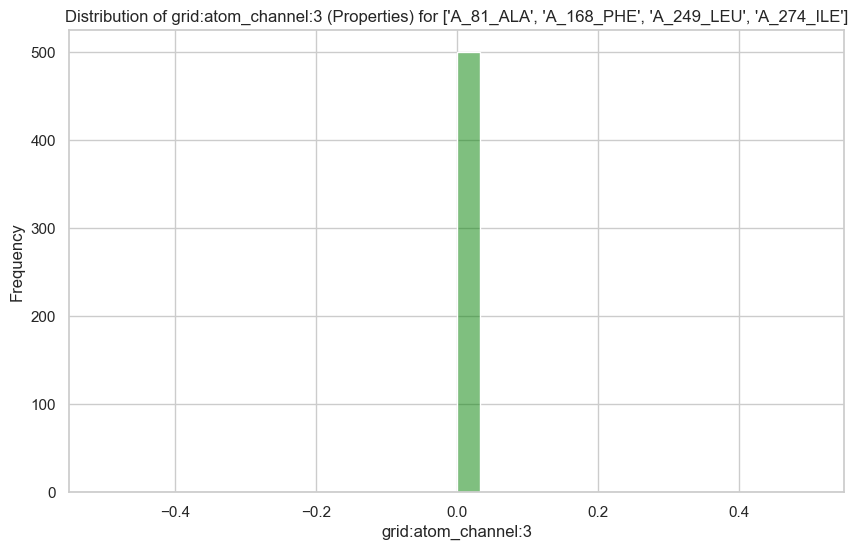

  Property - grid:atom_channel:4: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


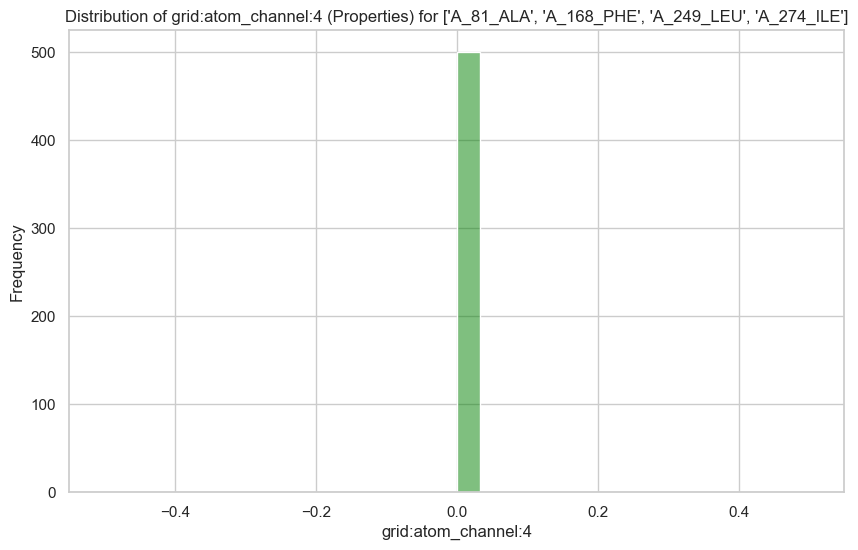

  Property - grid:atom_channel:5: mean=3.9924859211329955, median=3.995255029652758, quantiles={0.25: 3.7915560464701885, 0.5: 3.995255029652758, 0.75: 4.199985182414002}


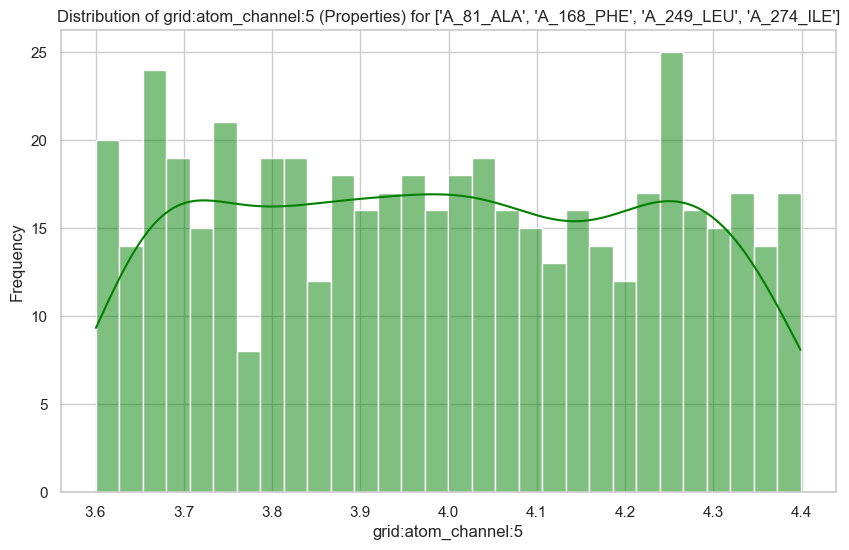

  Property - grid:atom_channel:6: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


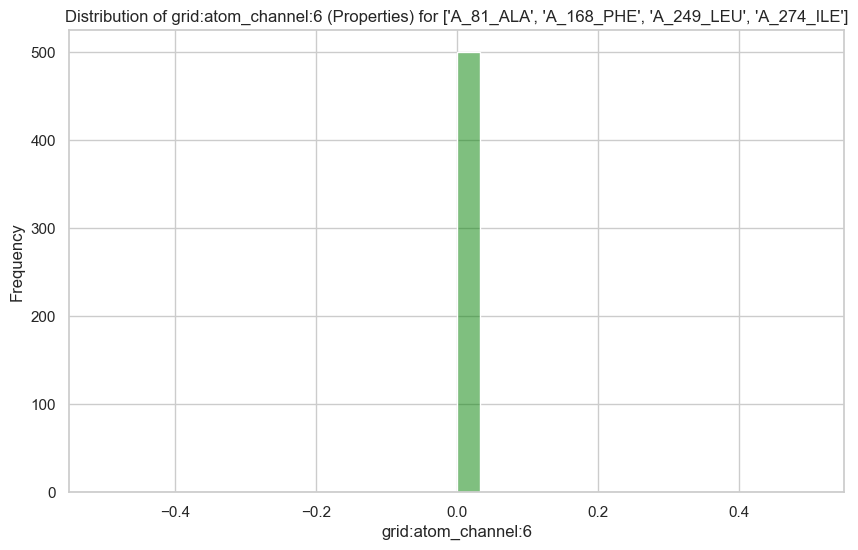

  Property - grid:atom_channel:7: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


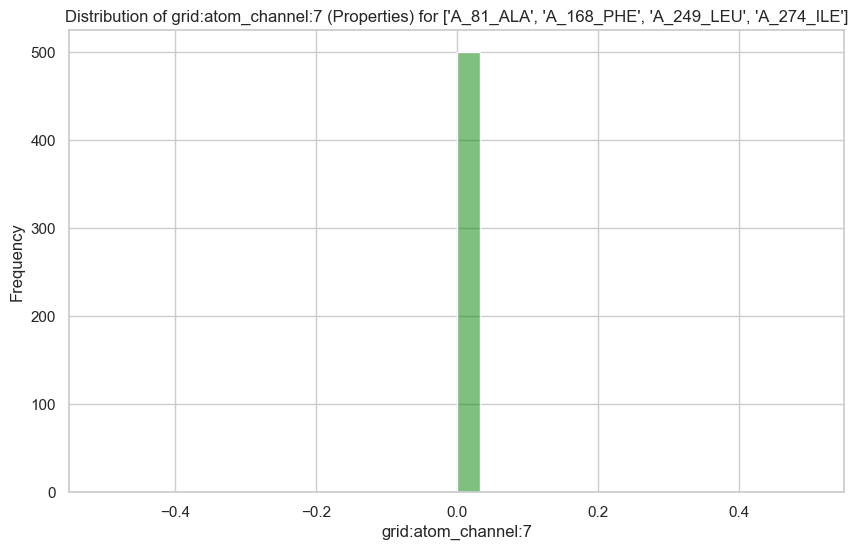

  Property - grid:atom_channel:8: mean=3.9946801442674857, median=3.994428062898666, quantiles={0.25: 3.7821875171513866, 0.5: 3.994428062898666, 0.75: 4.197529403636413}


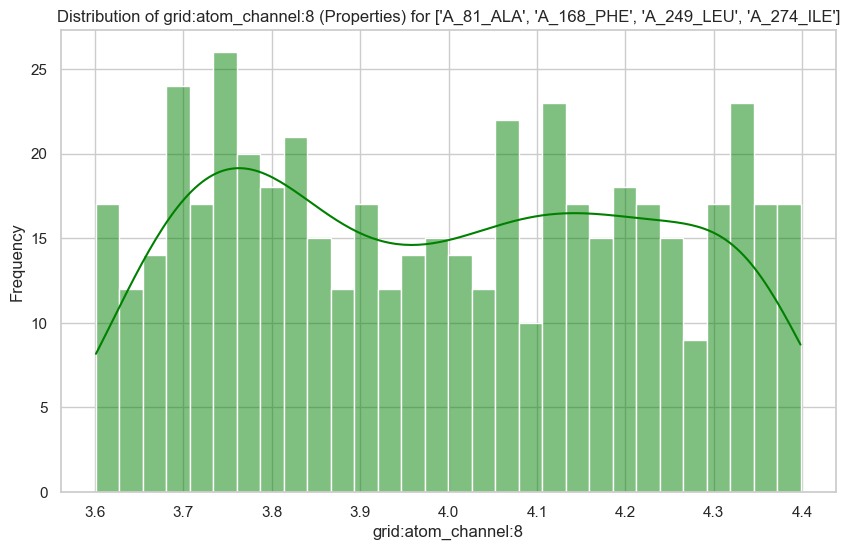

  Property - grid:atom_channel:9: mean=6.000883364188145, median=6.000406653403909, quantiles={0.25: 5.728198171751153, 0.5: 6.000406653403909, 0.75: 6.30146190061159}


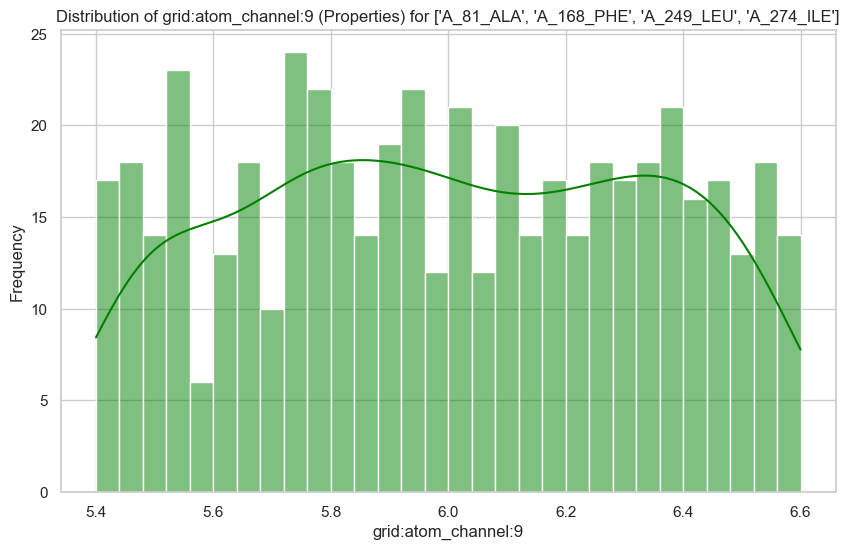

  Property - grid:atom_channel:10: mean=14.026925882007289, median=14.072723095779958, quantiles={0.25: 13.337433220060257, 0.5: 14.072723095779958, 0.75: 14.721890428886354}


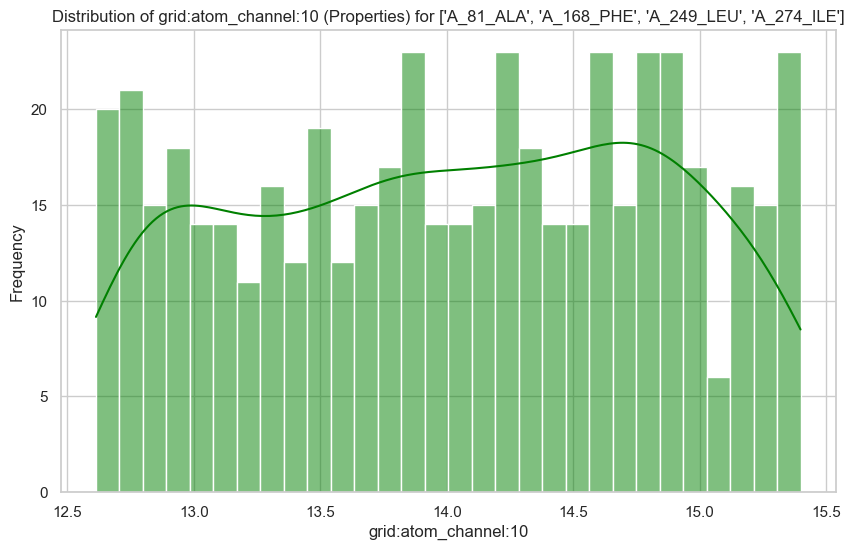

  Property - grid:grid_channel:0: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


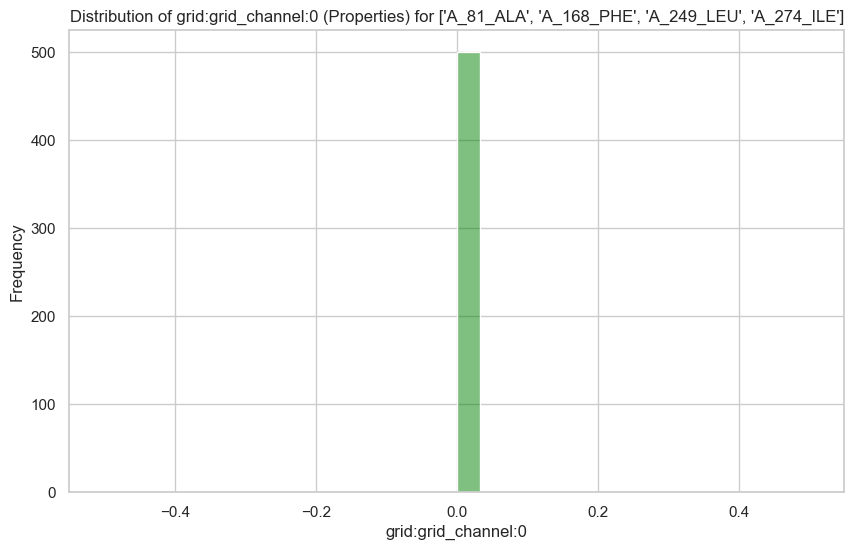

  Property - grid:grid_channel:1: mean=0.002126848162009826, median=0.002127338252938421, quantiles={0.25: 0.002020882244926003, 0.5: 0.002127338252938421, 0.75: 0.002234943164258142}


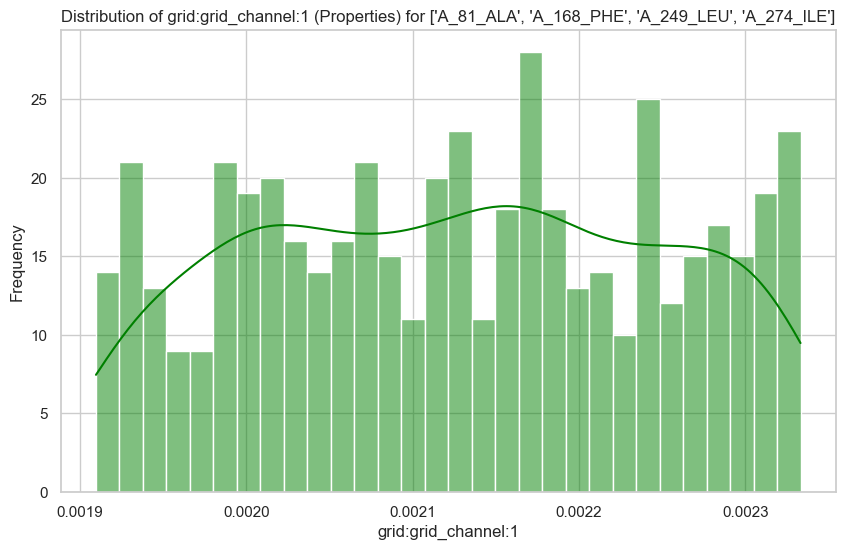

  Property - grid:grid_channel:2: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


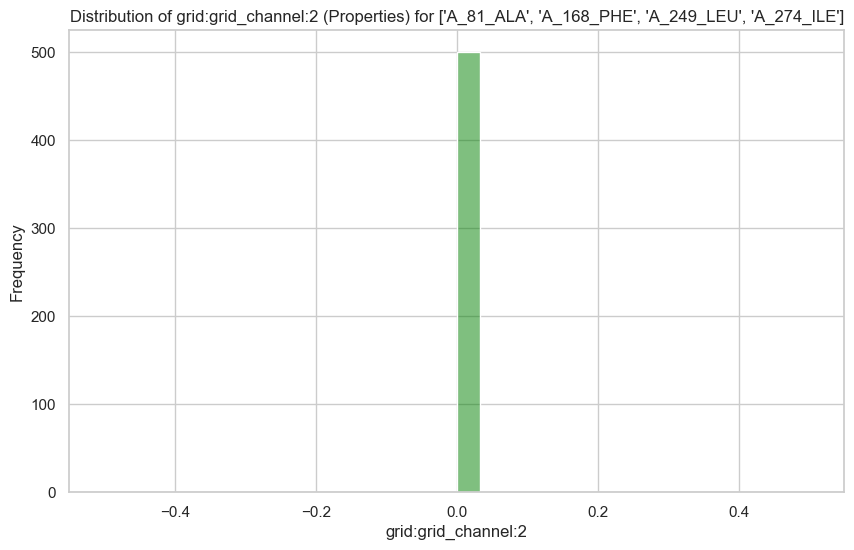

  Property - grid:grid_channel:3: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


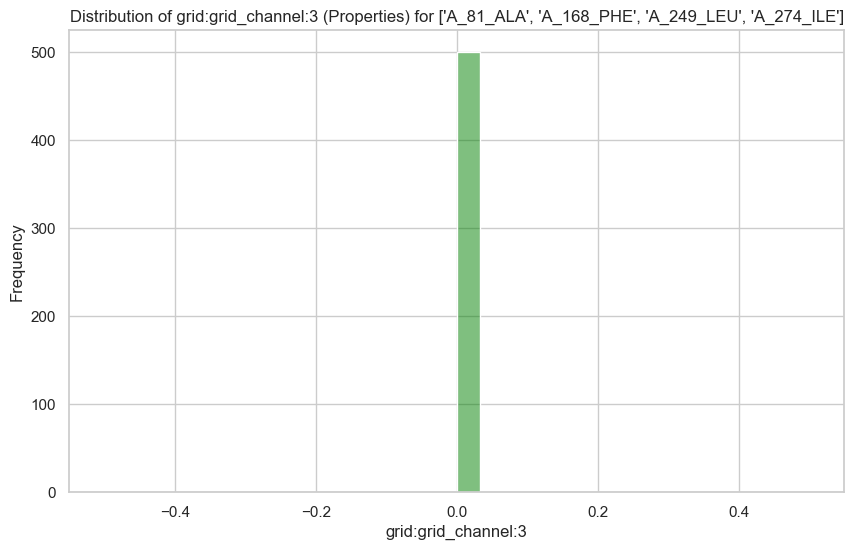

  Property - grid:grid_channel:4: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


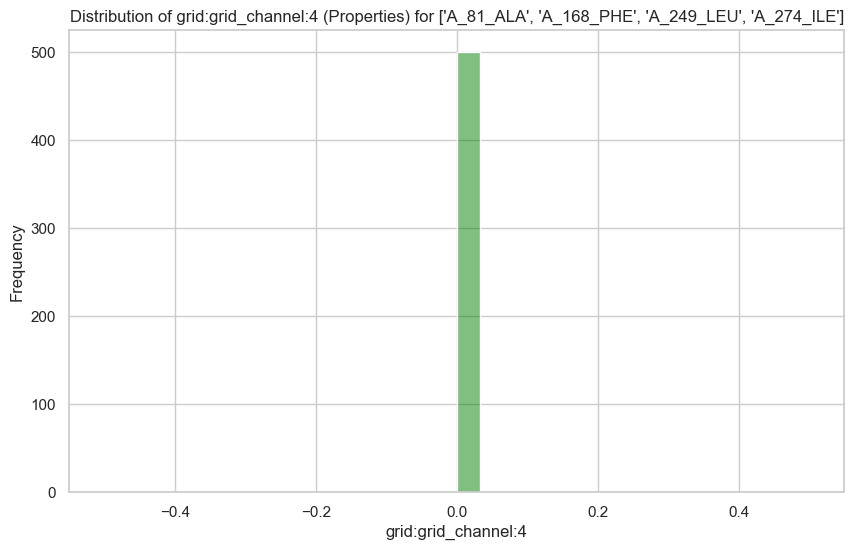

  Property - grid:grid_channel:5: mean=0.0020001765345858515, median=0.0019987514357304105, quantiles={0.25: 0.0019108316618402402, 0.5: 0.0019987514357304105, 0.75: 0.002093826059241042}


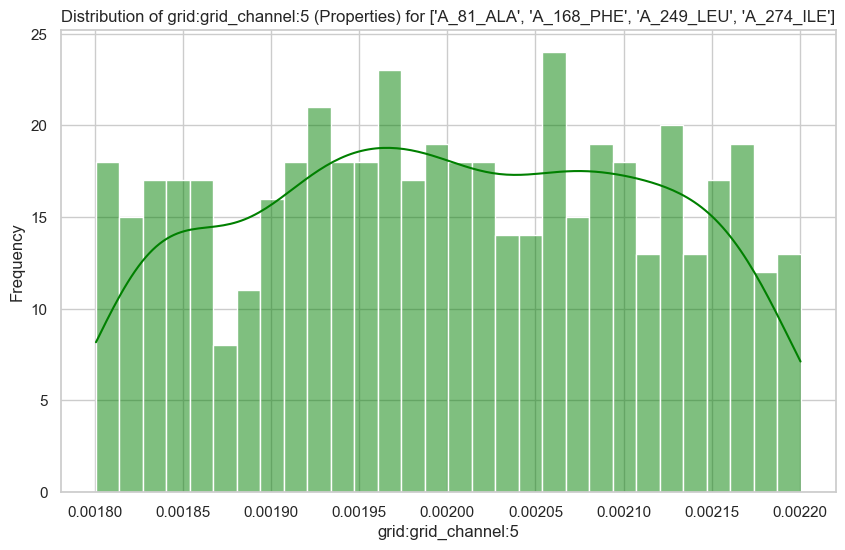

  Property - grid:grid_channel:6: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


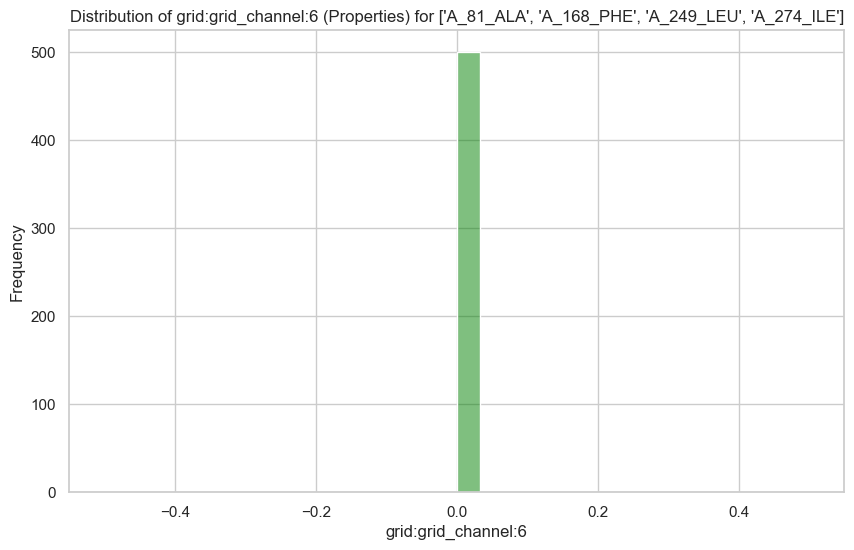

  Property - grid:grid_channel:7: mean=0.0, median=0.0, quantiles={0.25: 0.0, 0.5: 0.0, 0.75: 0.0}


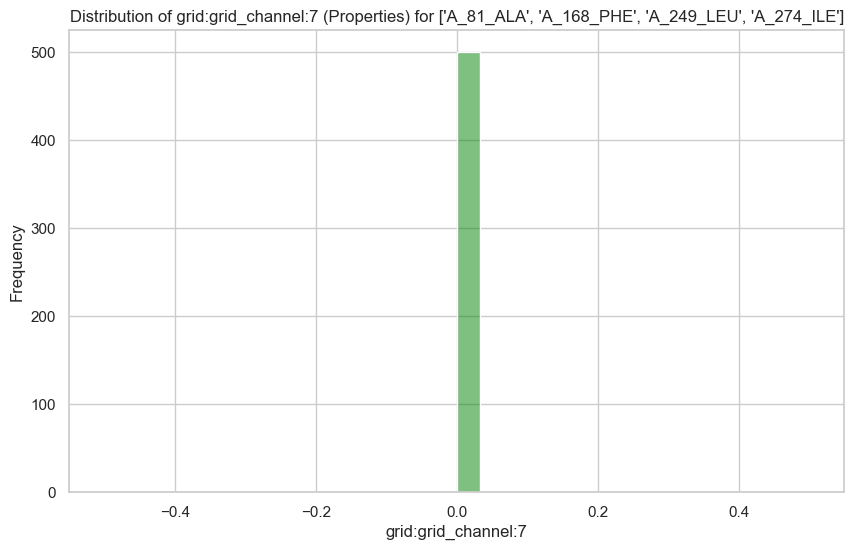

  Property - grid:grid_channel:8: mean=0.002797185550685726, median=0.002806211753744571, quantiles={0.25: 0.0026480546203569493, 0.5: 0.002806211753744571, 0.75: 0.0029352400959107563}


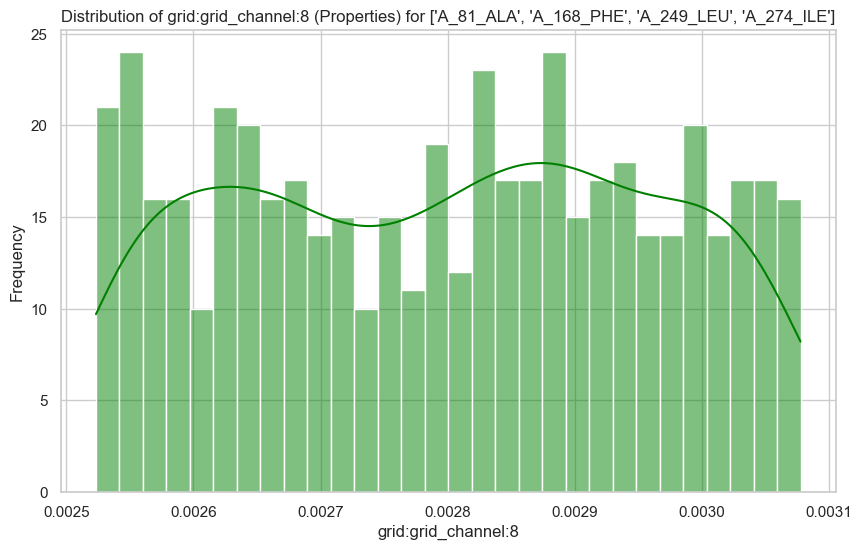

  Property - grid:grid_channel:9: mean=0.004192680481368935, median=0.00418333285474213, quantiles={0.25: 0.003978154971701237, 0.5: 0.00418333285474213, 0.75: 0.004414125012381952}


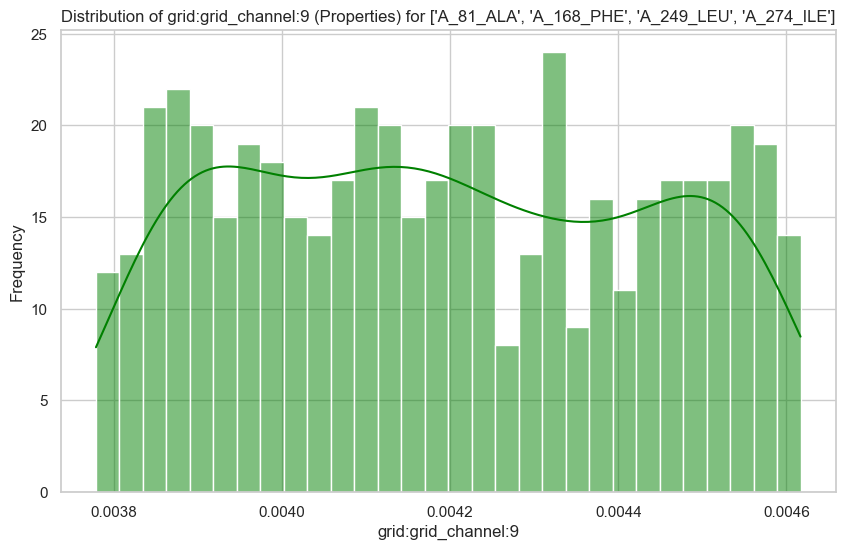

  Property - grid:grid_channel:10: mean=0.00983471920903084, median=0.00984538733177166, quantiles={0.25: 0.009349206108395899, 0.5: 0.00984538733177166, 0.75: 0.01033333460275873}


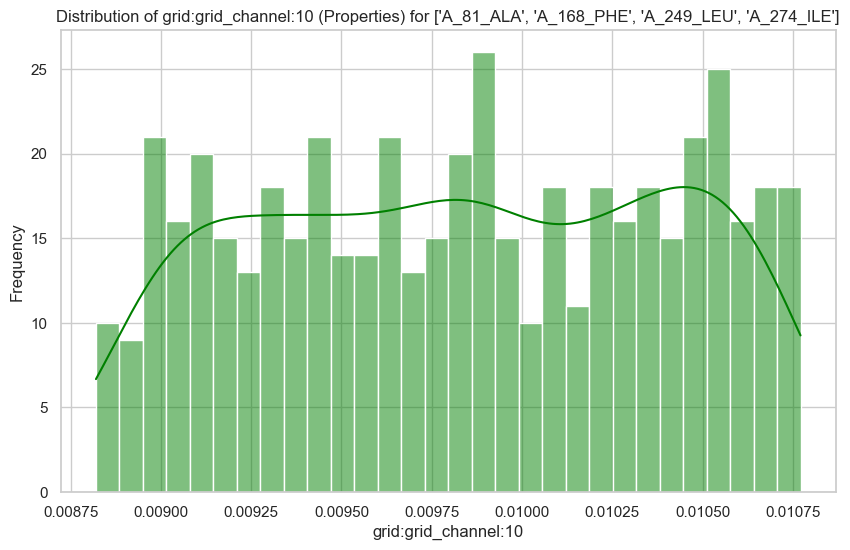

  Property - volume_pocketfinder:volume: mean=294.6802806214909, median=294.95933818888426, quantiles={0.25: 279.84139032878835, 0.5: 294.95933818888426, 0.75: 308.40051314086514}


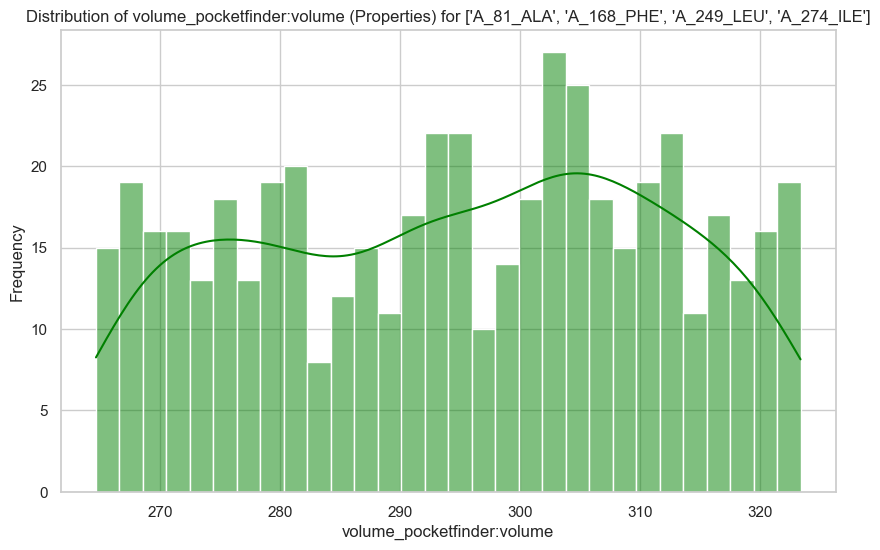

  Property - volume_pocketfinder:area: mean=275.2395908803196, median=275.34270531667363, quantiles={0.25: 261.4597495135796, 0.5: 275.34270531667363, 0.75: 289.6148751324678}


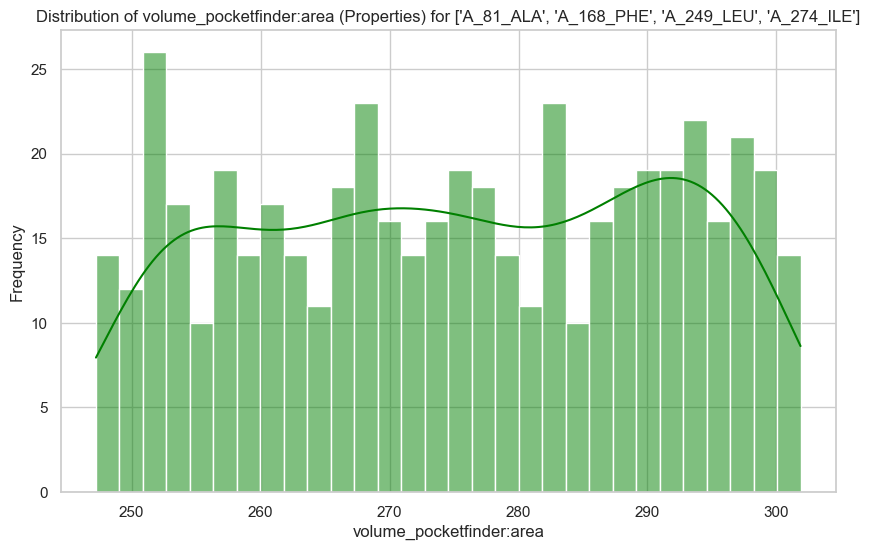

  Property - volume_pocketfinder:buriedness: mean=0.8860668619413081, median=0.88459714459873, quantiles={0.25: 0.8445732865081939, 0.5: 0.88459714459873, 0.75: 0.9310527930526433}


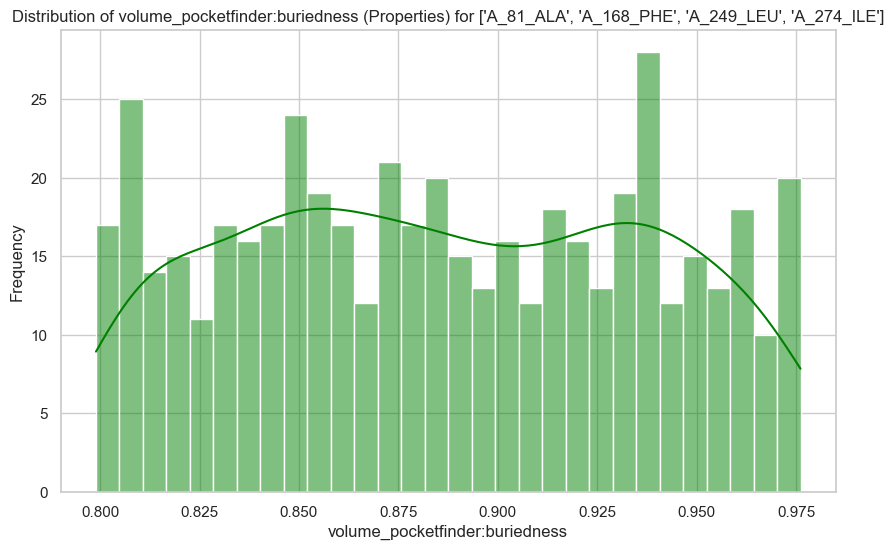

  Property - volume_pocketfinder:hydrophobicity: mean=0.7953610036233881, median=0.7961409862890189, quantiles={0.25: 0.7586837765289391, 0.5: 0.7961409862890189, 0.75: 0.8338706987364572}


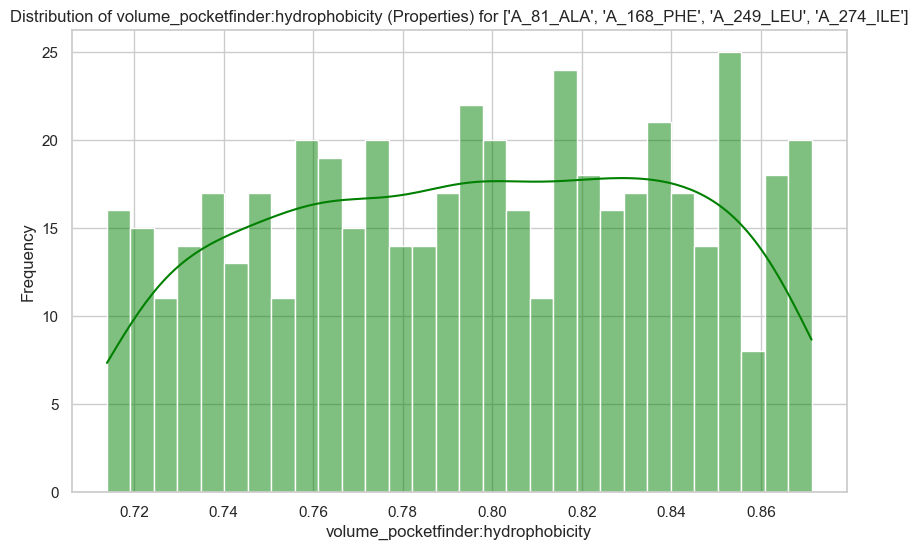

  Property - volume_pocketfinder:druggability: mean=0.8174981439457923, median=0.816375964957944, quantiles={0.25: 0.7727349629535702, 0.5: 0.816375964957944, 0.75: 0.8597766939428791}


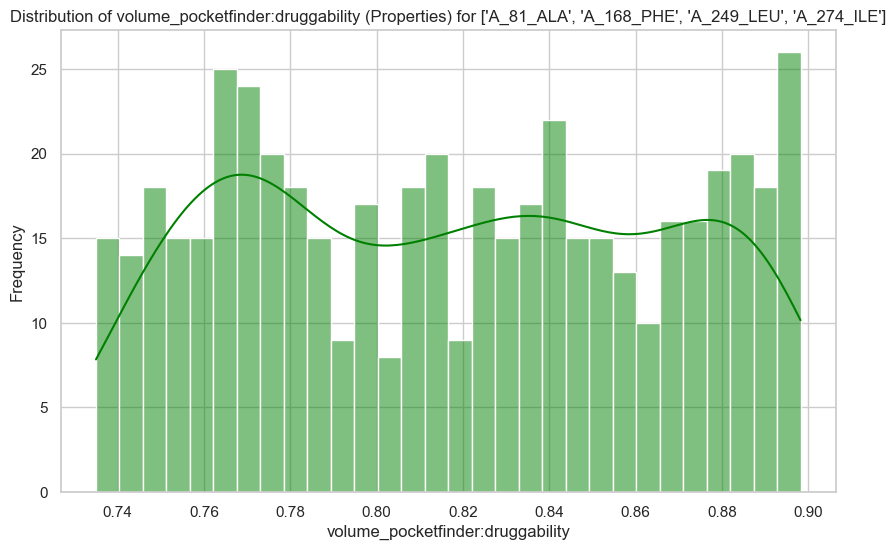


Statistics for Residue Set: ['B_100_ASP', 'B_105_GLU', 'B_120_LYS']


In [52]:
folder_path = '/Users/surajkwork/Documents/Projects/ProteinLigand/protein-ligand/protein-ligand/jsonfiles'
data = load_json_files(folder_path)
residue_sets = [
    ["A_81_ALA", "A_168_PHE", "A_249_LEU", "A_274_ILE"],
    ["B_100_ASP", "B_105_GLU", "B_120_LYS"]  # Add more residue sets as needed
]
statistics_df = compute_statistics_for_residue_sets(data, residue_sets)


In [48]:
# Display the statistics for the entire residue set
pprint.pprint(statistics)

{'hotspots': {'center_x': {'mean': -2.1688877134471176,
                           'median': -2.165445902516467,
                           'quantiles': {0.25: -2.2751293528390986,
                                         0.5: -2.165445902516467,
                                         0.75: -2.0681501630989305}},
              'center_y': {'mean': 6.46290122962315,
                           'median': 6.451569972525543,
                           'quantiles': {0.25: 6.129507226315707,
                                         0.5: 6.451569972525543,
                                         0.75: 6.802489442004582}},
              'center_z': {'mean': 17.641007374945175,
                           'median': 17.625730869980917,
                           'quantiles': {0.25: 16.721926188711755,
                                         0.5: 17.625730869980917,
                                         0.75: 18.55968166632419}},
              'small_molecule': {'mean': 0.9030199264130607,
 

# PREVIOUS ATTEMPTS

In [4]:
# Initialize lists to hold parsed data
all_rows = []


In [ ]:
for entry in data:
    row = {}

    row['residues'] = ', '.join(entry['residues'])  

    # Flatten hotspots
    for i, hotspot in enumerate(entry['hotspots']):
        center_key = f"hotspot_{i+1}_center"
        scores_key = f"hotspot_{i+1}_scores"
        row[center_key] = hotspot['center']
        for score_type, score in hotspot['scores'].items():
            row[f"{scores_key}_{score_type}"] = score
    
    # Flatten properties
    for prop, value in entry['properties'].items():
        row[prop] = value

    # Flatten residue_properties
    for residue, properties in entry['residue_properties'].items():
        for prop_name, prop_value in properties.items():
            row[f"{residue}_{prop_name}"] = prop_value


    all_rows.append(row)


df = pd.DataFrame(all_rows)

In [ ]:
df.head()

residues  \
0          A_81_ALA, A_168_PHE, A_249_LEU, A_274_ILE   
1  A_22_LEU, A_25_VAL, A_26_LEU, A_28_CYS, A_29_T...   
2  A_26_LEU, A_285_PRO, A_286_PHE, A_287_ILE, A_2...   
3  A_74_CYS, A_144_ASN, A_145_ASN, A_146_CYS, A_1...   
4  A_44_PHE, A_93_PHE, A_96_LEU, A_97_ALA, A_98_I...   

                                    hotspot_1_center  \
0  [-2.164827346801758, 6.473363876342773, 17.652...   
1  [-14.588199615478516, -18.392837524414062, 19....   
2  [-6.417280197143555, -16.700523376464844, 2.09...   
3  [-1.0404319763183594, 18.499326705932617, 33.8...   
4  [-3.7310009002685547, -14.355998992919922, 29....   

   hotspot_1_scores_small_molecule  tabular:hydrophobicity:mean  \
0                         0.899379                     1.595000   
1                              NaN                     1.346000   
2                              NaN                     1.537500   
3                         0.117655                     0.700000   
4                              NaN                     1.792222   

   tabular:hydrophobicity:sum  tabular:polarity:mean  tabular:polarity:sum  \
0                        6.38               5.850000                  23.4   
1                       33.65               6.700000                 167.5   
2                       12.30               6.475000                  51.8   
3                        5.60               8.450000                  67.6   
4                       16.13               5.522222                  49.7   

   tabular:positive:count  tabular:negative:count  tabular:polar:count  ...  \
0                       0                       0                    0  ...   
1                       1                       0                    7  ...   
2                       0                       0                    1  ...   
3                       0                       0                    3  ...   
4                       0                       0                    0  ...   

   A_30_ALA_surface_freesasa:sasa:apolar  \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   

   A_30_ALA_surface_freesasa:sasa:total  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   NaN   
4                                   NaN   

   A_30_ALA_surface_freesasa:sasa_relative:polar  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   

   A_30_ALA_surface_freesasa:sasa_relative:apolar  \
0                                             NaN   
1                                             NaN   
2                                             NaN   
3                                             NaN   
4                                             NaN   

   A_30_ALA_surface_freesasa:sasa_relative:total  A_30_ALA_surface_msms:ses  \
0                                            NaN                        NaN   
1                                            NaN                        NaN   
2                                            NaN                        NaN   
3                                            NaN                        NaN   
4                                            NaN                        NaN   

   A_30_ALA_surface_msms:sas  A_30_ALA_surface_msms:mean_normal  \
0                        NaN                                NaN   
1                        NaN                                NaN   
2                        NaN                                NaN   
3                        NaN                                NaN   
4                        NaN                             

In [25]:
df.residues.nunique()

19

In [12]:
dictionary = data[0]
for value in dictionary.values():
    print(value)
    print('/n')

['A_81_ALA', 'A_168_PHE', 'A_249_LEU', 'A_274_ILE']
/n
[{'center': [-2.164827346801758, 6.473363876342773, 17.652605056762695], 'scores': {'small_molecule': 0.8993786573410034}}]
/n
{'tabular:hydrophobicity:mean': 1.5950000000000002, 'tabular:hydrophobicity:sum': 6.380000000000001, 'tabular:polarity:mean': 5.8500000000000005, 'tabular:polarity:sum': 23.400000000000002, 'tabular:positive:count': 0, 'tabular:negative:count': 0, 'tabular:polar:count': 0, 'tabular:aromatic:count': 1, 'tabular:hydrophobic:count': 4, 'structure:bfactor:min': 12.609999656677246, 'structure:bfactor:max': 24.149999618530273, 'structure:bfactor:mean': 16.253124237060547, 'structure:bfactor:std': 2.431727170944214, 'structure:bfactor:diff': -0.830784261226654, 'secondary_structure_dssp:count:ss8:pi-helix': 0, 'secondary_structure_dssp:count:ss8:bend': 0, 'secondary_structure_dssp:count:ss8:coil': 0, 'secondary_structure_dssp:count:ss8:3-10-helix': 0, 'secondary_structure_dssp:count:ss8:alpha-helix': 4, 'secondary

In [ ]:
dictionary.values()

dict_values([['A_81_ALA', 'A_168_PHE', 'A_249_LEU', 'A_274_ILE'], [{'center': [-2.164827346801758, 6.473363876342773, 17.652605056762695], 'scores': {'small_molecule': 0.8993786573410034}}], {'tabular:hydrophobicity:mean': 1.5950000000000002, 'tabular:hydrophobicity:sum': 6.380000000000001, 'tabular:polarity:mean': 5.8500000000000005, 'tabular:polarity:sum': 23.400000000000002, 'tabular:positive:count': 0, 'tabular:negative:count': 0, 'tabular:polar:count': 0, 'tabular:aromatic:count': 1, 'tabular:hydrophobic:count': 4, 'structure:bfactor:min': 12.609999656677246, 'structure:bfactor:max': 24.149999618530273, 'structure:bfactor:mean': 16.253124237060547, 'structure:bfactor:std': 2.431727170944214, 'structure:bfactor:diff': -0.830784261226654, 'secondary_structure_dssp:count:ss8:pi-helix': 0, 'secondary_structure_dssp:count:ss8:bend': 0, 'secondary_structure_dssp:count:ss8:coil': 0, 'secondary_structure_dssp:count:ss8:3-10-helix': 0, 'secondary_structure_dssp:count:ss8:alpha-helix': 4, '

In [13]:
print(pd.json_normalize(data))


                                                                                                                                                                                                                                                                                                                                                                                                                      residues  \
0                                                                                                                                                                                                                                                                                                                                                                                  [A_81_ALA, A_168_PHE, A_249_LEU, A_274_ILE]   
1                                                                                                                                                          [A_22_LEU

In [14]:
pd.json_normalize(data)

residues  \
0                                                                                                                                                                                                                                                                                                                                                                                  [A_81_ALA, A_168_PHE, A_249_LEU, A_274_ILE]   
1                                                                                                                                                          [A_22_LEU, A_25_VAL, A_26_LEU, A_28_CYS, A_29_TRP, A_31_VAL, A_32_TRP, A_33_LEU, A_34_ASN, A_38_GLN, A_43_TYR, A_46_VAL, A_47_SER, A_48_LEU, A_50_ALA, A_121_ALA, A_122_LYS, A_123_GLY, A_124_ILE, A_125_ILE, A_126_ALA, A_129_TRP, A_302_ILE, A_307_VAL, A_37_LEU]   
2                                                                                                                                                                                                                                                                                                                                       [A_26_LEU, A_285_PRO, A_286_PHE, A_287_ILE, A_289_ALA, A_290_TYR, A_299_PHE, A_23_GLY]   
3                                                                                                                                                                                                                                                                                                                                      [A_74_CYS, A_144_ASN, A_145_ASN, A_146_CYS, A_147_GLY, A_148_GLN, A_171_VAL, A_173_PRO]   
4                                                                                                                                                                                                                                                                                                                               [A_44_PHE, A_93_PHE, A_96_LEU, A_97_ALA, A_98_ILE, A_100_ILE, A_124_ILE, A_128_CYS, A_125_ILE]   
5                                                                                                                                                                                                                                                                                                    [A_230_HIS, A_290_TYR, A_291_ARG, A_292_ILE, A_293_ARG, A_296_ARG, A_297_GLN, A_300_ARG, A_301_LYS, A_304_ARG, A_289_ALA]   
6   [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_THR, A_42_ASN, A_43_TYR, A_44_PHE, A_100_ILE, A_101_ASP, A_102_ARG, A_104_ILE, A_112_TYR, A_115_LEU, A_116_VAL, A_117_THR, A_118_GLY, A_119_THR, A_120_ARG, A_121_ALA, A_122_LYS, A_124_ILE, A_226_GLN, A_227_LYS, A_228_GLU, A_229_VAL, A_230_HIS, A_231_ALA, A_232_ALA, A_233_LYS, A_234_SER, A_289_ALA, A_290_TYR, A_291_ARG, A_292_ILE, A_293_ARG, A_294_GLU, A_296_ARG]   
7                                                                                                                                                                                                                                                                                                           [A_48_LEU, A_51_ALA, A_52_ASP, A_55_VAL, A_87_LEU, A_88_THR, A_91_SER, A_242_PHE, A_246_TRP, A_280_ASN, A_281_SER]   
8                                                                                                                                                                                                                                [A_2_PRO, A_3_ILE, A_4_MET, A_5_GLY, A_6_SER, A_7_SER, A_8_VAL, A_9_TYR, A_66_ILE, A_67_SER, A_68_THR, A_69_GLY, A_157_GLN, A_167_LEU, A_267_LEU, A_268_TRP, A_269_LEU, A_270_MET, A_271_TYR]   
9                                                                                                                                                                                                                                 

In [15]:
pd.DataFrame(data)

residues  \
0                                                                                                                                                                                                                                                                                                                                                                                  [A_81_ALA, A_168_PHE, A_249_LEU, A_274_ILE]   
1                                                                                                                                                          [A_22_LEU, A_25_VAL, A_26_LEU, A_28_CYS, A_29_TRP, A_31_VAL, A_32_TRP, A_33_LEU, A_34_ASN, A_38_GLN, A_43_TYR, A_46_VAL, A_47_SER, A_48_LEU, A_50_ALA, A_121_ALA, A_122_LYS, A_123_GLY, A_124_ILE, A_125_ILE, A_126_ALA, A_129_TRP, A_302_ILE, A_307_VAL, A_37_LEU]   
2                                                                                                                                                                                                                                                                                                                                       [A_26_LEU, A_285_PRO, A_286_PHE, A_287_ILE, A_289_ALA, A_290_TYR, A_299_PHE, A_23_GLY]   
3                                                                                                                                                                                                                                                                                                                                      [A_74_CYS, A_144_ASN, A_145_ASN, A_146_CYS, A_147_GLY, A_148_GLN, A_171_VAL, A_173_PRO]   
4                                                                                                                                                                                                                                                                                                                               [A_44_PHE, A_93_PHE, A_96_LEU, A_97_ALA, A_98_ILE, A_100_ILE, A_124_ILE, A_128_CYS, A_125_ILE]   
5                                                                                                                                                                                                                                                                                                    [A_230_HIS, A_290_TYR, A_291_ARG, A_292_ILE, A_293_ARG, A_296_ARG, A_297_GLN, A_300_ARG, A_301_LYS, A_304_ARG, A_289_ALA]   
6   [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_THR, A_42_ASN, A_43_TYR, A_44_PHE, A_100_ILE, A_101_ASP, A_102_ARG, A_104_ILE, A_112_TYR, A_115_LEU, A_116_VAL, A_117_THR, A_118_GLY, A_119_THR, A_120_ARG, A_121_ALA, A_122_LYS, A_124_ILE, A_226_GLN, A_227_LYS, A_228_GLU, A_229_VAL, A_230_HIS, A_231_ALA, A_232_ALA, A_233_LYS, A_234_SER, A_289_ALA, A_290_TYR, A_291_ARG, A_292_ILE, A_293_ARG, A_294_GLU, A_296_ARG]   
7                                                                                                                                                                                                                                                                                                           [A_48_LEU, A_51_ALA, A_52_ASP, A_55_VAL, A_87_LEU, A_88_THR, A_91_SER, A_242_PHE, A_246_TRP, A_280_ASN, A_281_SER]   
8                                                                                                                                                                                                                                [A_2_PRO, A_3_ILE, A_4_MET, A_5_GLY, A_6_SER, A_7_SER, A_8_VAL, A_9_TYR, A_66_ILE, A_67_SER, A_68_THR, A_69_GLY, A_157_GLN, A_167_LEU, A_267_LEU, A_268_TRP, A_269_LEU, A_270_MET, A_271_TYR]   
9                                                                                                                                                                                                                                 

In [18]:
temp = pd.DataFrame(data)
pd.DataFrame(temp['residues'])

residues
0                                                                                                                                                                                                                                                                                                                                                                                  [A_81_ALA, A_168_PHE, A_249_LEU, A_274_ILE]
1                                                                                                                                                          [A_22_LEU, A_25_VAL, A_26_LEU, A_28_CYS, A_29_TRP, A_31_VAL, A_32_TRP, A_33_LEU, A_34_ASN, A_38_GLN, A_43_TYR, A_46_VAL, A_47_SER, A_48_LEU, A_50_ALA, A_121_ALA, A_122_LYS, A_123_GLY, A_124_ILE, A_125_ILE, A_126_ALA, A_129_TRP, A_302_ILE, A_307_VAL, A_37_LEU]
2                                                                                                                                                                                                                                                                                                                                       [A_26_LEU, A_285_PRO, A_286_PHE, A_287_ILE, A_289_ALA, A_290_TYR, A_299_PHE, A_23_GLY]
3                                                                                                                                                                                                                                                                                                                                      [A_74_CYS, A_144_ASN, A_145_ASN, A_146_CYS, A_147_GLY, A_148_GLN, A_171_VAL, A_173_PRO]
4                                                                                                                                                                                                                                                                                                                               [A_44_PHE, A_93_PHE, A_96_LEU, A_97_ALA, A_98_ILE, A_100_ILE, A_124_ILE, A_128_CYS, A_125_ILE]
5                                                                                                                                                                                                                                                                                                    [A_230_HIS, A_290_TYR, A_291_ARG, A_292_ILE, A_293_ARG, A_296_ARG, A_297_GLN, A_300_ARG, A_301_LYS, A_304_ARG, A_289_ALA]
6   [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_THR, A_42_ASN, A_43_TYR, A_44_PHE, A_100_ILE, A_101_ASP, A_102_ARG, A_104_ILE, A_112_TYR, A_115_LEU, A_116_VAL, A_117_THR, A_118_GLY, A_119_THR, A_120_ARG, A_121_ALA, A_122_LYS, A_124_ILE, A_226_GLN, A_227_LYS, A_228_GLU, A_229_VAL, A_230_HIS, A_231_ALA, A_232_ALA, A_233_LYS, A_234_SER, A_289_ALA, A_290_TYR, A_291_ARG, A_292_ILE, A_293_ARG, A_294_GLU, A_296_ARG]
7                                                                                                                                                                                                                                                                                                           [A_48_LEU, A_51_ALA, A_52_ASP, A_55_VAL, A_87_LEU, A_88_THR, A_91_SER, A_242_PHE, A_246_TRP, A_280_ASN, A_281_SER]
8                                                                                                                                                                                                                                [A_2_PRO, A_3_ILE, A_4_MET, A_5_GLY, A_6_SER, A_7_SER, A_8_VAL, A_9_TYR, A_66_ILE, A_67_SER, A_68_THR, A_69_GLY, A_157_GLN, A_167_LEU, A_267_LEU, A_268_TRP, A_269_LEU, A_270_MET, A_271_TYR]
9                                                                                                                                                                                                                                                               

In [24]:
#pd.DataFrame(temp['residues']).nunique
temp.residues.nunique()

TypeError: unhashable type: 'list'

In [11]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame(df['residues'])

residues
0                                                                                                                                                                                                                                                                                                                                                                                  A_81_ALA, A_168_PHE, A_249_LEU, A_274_ILE
1                                                                                                                                                          A_22_LEU, A_25_VAL, A_26_LEU, A_28_CYS, A_29_TRP, A_31_VAL, A_32_TRP, A_33_LEU, A_34_ASN, A_38_GLN, A_43_TYR, A_46_VAL, A_47_SER, A_48_LEU, A_50_ALA, A_121_ALA, A_122_LYS, A_123_GLY, A_124_ILE, A_125_ILE, A_126_ALA, A_129_TRP, A_302_ILE, A_307_VAL, A_37_LEU
2                                                                                                                                                                                                                                                                                                                                       A_26_LEU, A_285_PRO, A_286_PHE, A_287_ILE, A_289_ALA, A_290_TYR, A_299_PHE, A_23_GLY
3                                                                                                                                                                                                                                                                                                                                      A_74_CYS, A_144_ASN, A_145_ASN, A_146_CYS, A_147_GLY, A_148_GLN, A_171_VAL, A_173_PRO
4                                                                                                                                                                                                                                                                                                                               A_44_PHE, A_93_PHE, A_96_LEU, A_97_ALA, A_98_ILE, A_100_ILE, A_124_ILE, A_128_CYS, A_125_ILE
5                                                                                                                                                                                                                                                                                                    A_230_HIS, A_290_TYR, A_291_ARG, A_292_ILE, A_293_ARG, A_296_ARG, A_297_GLN, A_300_ARG, A_301_LYS, A_304_ARG, A_289_ALA
6   A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_THR, A_42_ASN, A_43_TYR, A_44_PHE, A_100_ILE, A_101_ASP, A_102_ARG, A_104_ILE, A_112_TYR, A_115_LEU, A_116_VAL, A_117_THR, A_118_GLY, A_119_THR, A_120_ARG, A_121_ALA, A_122_LYS, A_124_ILE, A_226_GLN, A_227_LYS, A_228_GLU, A_229_VAL, A_230_HIS, A_231_ALA, A_232_ALA, A_233_LYS, A_234_SER, A_289_ALA, A_290_TYR, A_291_ARG, A_292_ILE, A_293_ARG, A_294_GLU, A_296_ARG
7                                                                                                                                                                                                                                                                                                           A_48_LEU, A_51_ALA, A_52_ASP, A_55_VAL, A_87_LEU, A_88_THR, A_91_SER, A_242_PHE, A_246_TRP, A_280_ASN, A_281_SER
8                                                                                                                                                                                                                                A_2_PRO, A_3_ILE, A_4_MET, A_5_GLY, A_6_SER, A_7_SER, A_8_VAL, A_9_TYR, A_66_ILE, A_67_SER, A_68_THR, A_69_GLY, A_157_GLN, A_167_LEU, A_267_LEU, A_268_TRP, A_269_LEU, A_270_MET, A_271_TYR
9                                                                                                                                                                                                                                                                                 

In [35]:
df['hotspots'][1]

[{'center': [-14.588199615478516, -18.392837524414062, 19.296491622924805],
  'scores': {'peptide': 0.3891110122203827}},
 {'center': [-15.441143989562988, -23.9862060546875, 18.969850540161133],
  'scores': {'peptide': 0.35034218430519104}},
 {'center': [-17.35551643371582, -18.503665924072266, 12.925220489501953],
  'scores': {'peptide': 0.32614582777023315}},
 {'center': [-11.46996021270752, -17.547740936279297, 21.792051315307617],
  'scores': {'peptide': 0.1467660665512085}},
 {'center': [-18.017135620117188, -24.457237243652344, 13.928241729736328],
  'scores': {'peptide': 0.12483903765678406}},
 {'center': [-15.814404487609863, -16.25381851196289, 5.616817474365234],
  'scores': {'peptide': 0.09619518369436264}},
 {'center': [-13.059419631958008, -24.54326629638672, 19.11113166809082],
  'scores': {'small_molecule': 0.06027108058333397}},
 {'center': [-12.732000350952148, -16.722000122070312, 14.878000259399414],
  'scores': {'covalent:residue-CYS': 0.013534069992601871}},
 {'ce

In [36]:
df['properties'][1]

{'tabular:hydrophobicity:mean': 1.3460000000000003,
 'tabular:hydrophobicity:sum': 33.650000000000006,
 'tabular:polarity:mean': 6.700000000000001,
 'tabular:polarity:sum': 167.50000000000003,
 'tabular:positive:count': 1,
 'tabular:negative:count': 0,
 'tabular:polar:count': 7,
 'tabular:aromatic:count': 4,
 'tabular:hydrophobic:count': 16,
 'structure:bfactor:min': 13.75,
 'structure:bfactor:max': 84.29000091552734,
 'structure:bfactor:mean': 27.304086685180664,
 'structure:bfactor:std': 13.609086036682129,
 'structure:bfactor:diff': -0.2614433765411377,
 'secondary_structure_dssp:count:ss8:pi-helix': 0,
 'secondary_structure_dssp:count:ss8:bend': 0,
 'secondary_structure_dssp:count:ss8:coil': 3,
 'secondary_structure_dssp:count:ss8:3-10-helix': 1,
 'secondary_structure_dssp:count:ss8:alpha-helix': 21,
 'secondary_structure_dssp:count:ss8:h-bonded_turn': 0,
 'secondary_structure_dssp:count:ss8:isolated_beta-bridge': 0,
 'secondary_structure_dssp:count:ss8:extended_strand': 0,
 'secon

In [37]:
df['residue_properties'][1]

{'A_22_LEU': {'tabular:hydrophobicity': 1.53,
  'tabular:polarity': 4.9,
  'tabular:positive': False,
  'tabular:negative': False,
  'tabular:polar': False,
  'tabular:aromatic': False,
  'tabular:hydrophobic': True,
  'structure:bfactor:min': 15.109999656677246,
  'structure:bfactor:max': 28.600000381469727,
  'structure:bfactor:mean': 20.344999313354492,
  'structure:bfactor:std': 5.2368550300598145,
  'structure:bfactor:diff': -0.6199725866317749,
  'secondary_structure_dssp:ss8': 'alpha-helix',
  'secondary_structure_dssp:ss3': 'helix',
  'energies_pyrosetta:fa_atr': -4.565756038189717,
  'energies_pyrosetta:fa_rep': 0.4201371397631919,
  'energies_pyrosetta:fa_sol': 3.199027188916924,
  'energies_pyrosetta:fa_elec': -1.8011395396171657,
  'energies_pyrosetta:total_score': -1.9048059689191454,
  'electrostatic_pdb2pqr:charge': -1.3877787807814457e-16,
  'surface_freesasa:sasa:polar': 4.926017280828796,
  'surface_freesasa:sasa:apolar': 107.4078735344696,
  'surface_freesasa:sasa:to

In [13]:
df['properties'][4]

{'tabular:hydrophobicity:mean': 1.7922222222222222,
 'tabular:hydrophobicity:sum': 16.13,
 'tabular:polarity:mean': 5.522222222222222,
 'tabular:polarity:sum': 49.7,
 'tabular:positive:count': 0,
 'tabular:negative:count': 0,
 'tabular:polar:count': 0,
 'tabular:aromatic:count': 2,
 'tabular:hydrophobic:count': 8,
 'structure:bfactor:min': 13.9399995803833,
 'structure:bfactor:max': 31.809999465942383,
 'structure:bfactor:mean': 19.02273941040039,
 'structure:bfactor:std': 3.870596408843994,
 'structure:bfactor:diff': -0.6880948543548584,
 'secondary_structure_dssp:count:ss8:pi-helix': 0,
 'secondary_structure_dssp:count:ss8:bend': 0,
 'secondary_structure_dssp:count:ss8:coil': 0,
 'secondary_structure_dssp:count:ss8:3-10-helix': 0,
 'secondary_structure_dssp:count:ss8:alpha-helix': 9,
 'secondary_structure_dssp:count:ss8:h-bonded_turn': 0,
 'secondary_structure_dssp:count:ss8:isolated_beta-bridge': 0,
 'secondary_structure_dssp:count:ss8:extended_strand': 0,
 'secondary_structure_dssp

In [38]:
# Step 1: Define recursive flattening function
def flatten_nested_json(y):
    out = {}
    
    def flatten(x, name=''):
        if isinstance(x, dict):
            for a in x:
                flatten(x[a], name + a + '_')
        elif isinstance(x, list):
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x
    
    flatten(y)
    return out

In [39]:
flattened_columns = {}

for column in df.columns:
    # If the column is not a simple data type, flatten it
    if df[column].apply(lambda x: isinstance(x, (dict, list))).any():
        # Flatten each entry in the column
        flat_data = df[column].apply(lambda x: flatten_nested_json(x) if isinstance(x, (dict, list)) else x)
        # Expand the dictionary into a DataFrame
        flat_df = pd.DataFrame(flat_data.tolist())
        # Store the flattened DataFrame
        flattened_columns[column] = flat_df

In [40]:
# Step 3: Concatenate original non-nested columns with the flattened columns
# Drop the original nested columns from the original DataFrame
df_non_nested = df.drop(columns=flattened_columns.keys())
# Concatenate all parts together
df_final = pd.concat([df_non_nested] + list(flattened_columns.values()), axis=1)

# Display the final DataFrame
df_final.head()

0          1          2          3          4          5          6  \
0  A_81_ALA  A_168_PHE  A_249_LEU  A_274_ILE        NaN        NaN        NaN   
1  A_22_LEU   A_25_VAL   A_26_LEU   A_28_CYS   A_29_TRP   A_31_VAL   A_32_TRP   
2  A_26_LEU  A_285_PRO  A_286_PHE  A_287_ILE  A_289_ALA  A_290_TYR  A_299_PHE   
3  A_74_CYS  A_144_ASN  A_145_ASN  A_146_CYS  A_147_GLY  A_148_GLN  A_171_VAL   
4  A_44_PHE   A_93_PHE   A_96_LEU   A_97_ALA   A_98_ILE  A_100_ILE  A_124_ILE   

           7          8         9  ... A_30_ALA_surface_freesasa:sasa:apolar  \
0        NaN        NaN       NaN  ...                                   NaN   
1   A_33_LEU   A_34_ASN  A_38_GLN  ...                                   NaN   
2   A_23_GLY        NaN       NaN  ...                                   NaN   
3  A_173_PRO        NaN       NaN  ...                                   NaN   
4  A_128_CYS  A_125_ILE       NaN  ...                                   NaN   

  A_30_ALA_surface_freesasa:sasa:total  \
0                                  NaN   
1                                  NaN   
2                                  NaN   
3                                  NaN   
4                                  NaN   

  A_30_ALA_surface_freesasa:sasa_relative:polar  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   

  A_30_ALA_surface_freesasa:sasa_relative:apolar  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   

  A_30_ALA_surface_freesasa:sasa_relative:total A_30_ALA_surface_msms:ses  \
0                                           NaN                       NaN   
1                                           NaN                       NaN   
2                                           NaN                       NaN   
3                                           NaN                       NaN   
4                                           NaN                       NaN   

  A_30_ALA_surface_msms:sas A_30_ALA_surface_msms:mean_normal  \
0                       NaN                               NaN   
1                       NaN                               NaN   
2                       NaN                               NaN   
3                       NaN                               NaN   
4                       NaN                               NaN   

  A_30_ALA_surface_msms:mean_curvature A_30_ALA_surface_custom:sasa  
0                                  NaN                          NaN  
1                                  NaN                          NaN  
2                                  NaN                          NaN  
3                                  NaN                          NaN  
4                                  NaN                          NaN  

[5 rows x 4846 columns]

# Previous attempts

In [14]:
# Normalize the 'properties' column
properties_df = pd.json_normalize(df['properties'])
properties_df


tabular:hydrophobicity:mean  tabular:hydrophobicity:sum  \
0                      1.595000                        6.38   
1                      1.346000                       33.65   
2                      1.537500                       12.30   
3                      0.700000                        5.60   
4                      1.792222                       16.13   
5                      0.860909                        9.47   
6                      0.917105                       34.85   
7                      0.939091                       10.33   
8                      1.126842                       21.41   
9                      1.290000                       11.61   
10                     0.687500                        5.50   
11                     1.100000                        3.30   
12                     0.583333                        3.50   
13                     0.935000                        5.61   
14                     1.431765                       24.34   
15                     1.042857                        7.30   
16                     1.505000                        6.02   
17                     1.070000                        1.07   
18                     1.260000                        8.82   

    tabular:polarity:mean  tabular:polarity:sum  tabular:positive:count  \
0                5.850000                  23.4                       0   
1                6.700000                 167.5                       1   
2                6.475000                  51.8                       0   
3                8.450000                  67.6                       0   
4                5.522222                  49.7                       0   
5                9.472727                 104.2                       6   
6                8.607895                 327.1                       8   
7                7.818182                  86.0                       0   
8                6.994737                 132.9                       0   
9                7.100000                  63.9                       1   
10               8.725000                  69.8                       1   
11               8.533333                  25.6                       0   
12               7.916667                  47.5                       0   
13               8.266667                  49.6                       1   
14               6.841176                 116.3                       4   
15               7.428571                  52.0                       0   
16               6.825000                  27.3                       1   
17               5.500000                   5.5                       0   
18               7.400000                  51.8                       0   

    tabular:negative:count  tabular:polar:count  tabular:aromatic:count  \
0                        0                    0                       1   
1                        0                    7                       4   
2                        0                    1                       3   
3                        0                    3                       0   
4                        0                    0                       2   
5                        0                    3                       2   
6                        3                   12                       5   
7                        1                    5                       2   
8                        0                    8                       3   
9                        0                    1                       1   
10                       0                    5                       1   
11                       1                    0                       0   
12                       0                    1                       1   
13                       0                    3                       1   
14                       0                    1                       1   
15                       0                

In [15]:
# Combine with the original DataFrame (excluding the now-expanded 'properties' column)
df = pd.concat([df.drop(columns=['properties']), properties_df], axis=1)
df

residues  \
0         [A_81_ALA, A_168_PHE, A_249_LEU, A_274_ILE]   
1   [A_22_LEU, A_25_VAL, A_26_LEU, A_28_CYS, A_29_...   
2   [A_26_LEU, A_285_PRO, A_286_PHE, A_287_ILE, A_...   
3   [A_74_CYS, A_144_ASN, A_145_ASN, A_146_CYS, A_...   
4   [A_44_PHE, A_93_PHE, A_96_LEU, A_97_ALA, A_98_...   
5   [A_230_HIS, A_290_TYR, A_291_ARG, A_292_ILE, A...   
6   [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_...   
7   [A_48_LEU, A_51_ALA, A_52_ASP, A_55_VAL, A_87_...   
8   [A_2_PRO, A_3_ILE, A_4_MET, A_5_GLY, A_6_SER, ...   
9   [A_197_TYR, A_232_ALA, A_233_LYS, A_235_LEU, A...   
10  [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_...   
11                  [A_231_ALA, A_292_ILE, A_294_GLU]   
12  [A_73_ALA, A_74_CYS, A_75_HIS, A_76_GLY, A_146...   
13  [A_33_LEU, A_298_THR, A_301_LYS, A_302_ILE, A_...   
14  [A_96_LEU, A_100_ILE, A_103_TYR, A_104_ILE, A_...   
15  [A_89_GLN, A_135_ILE, A_180_PHE, A_181_ASN, A_...   
16       [A_201_PHE, A_202_LEU, A_229_VAL, A_233_LYS]   
17                                        [A_245_CYS]   
18  [A_29_TRP, A_30_ALA, A_31_VAL, A_32_TRP, A_33_...   

                                             hotspots  \
0   [{'center': [-2.164827346801758, 6.47336387634...   
1   [{'center': [-14.588199615478516, -18.39283752...   
2   [{'center': [-6.417280197143555, -16.700523376...   
3   [{'center': [-1.0404319763183594, 18.499326705...   
4   [{'center': [-3.7310009002685547, -14.35599899...   
5   [{'center': [-2.4087491035461426, -29.11868667...   
6   [{'center': [-0.17699050903320312, -27.5911750...   
7   [{'center': [-4.3981146812438965, -7.627058506...   
8   [{'center': [-6.87303352355957, 14.22170066833...   
9   [{'center': [9.384521484375, -16.0673980712890...   
10  [{'center': [-5.021980285644531, -28.668954849...   
11  [{'center': [-1.0899429321289062, -28.46748161...   
12  [{'center': [-13.772476196289062, 14.267995834...   
13  [{'center': [-17.353710174560547, -27.97072601...   
14  [{'center': [17.05373764038086, -25.5528316497...   
15  [{'center': [2.0392379760742188, -3.8428668975...   
16  [{'center': [14.836679458618164, -24.593448638...   
17  [{'center': [2.1919994354248047, -5.9540004730...   
18  [{'center': [-17.986833572387695, -27.83583068...   

                                   residue_properties  \
0   {'A_81_ALA': {'tabular:hydrophobicity': 0.61, ...   
1   {'A_22_LEU': {'tabular:hydrophobicity': 1.53, ...   
2   {'A_26_LEU': {'tabular:hydrophobicity': 1.53, ...   
3   {'A_74_CYS': {'tabular:hydrophobicity': 1.07, ...   
4   {'A_44_PHE': {'tabular:hydrophobicity': 2.02, ...   
5   {'A_230_HIS': {'tabular:hydrophobicity': 0.61,...   
6   {'A_37_LEU': {'tabular:hydrophobicity': 1.53, ...   
7   {'A_48_LEU': {'tabular:hydrophobicity': 1.53, ...   
8   {'A_2_PRO': {'tabular:hydrophobicity': 1.95, '...   
9   {'A_197_TYR': {'tabular:hydrophobicity': 1.88,...   
10  {'A_37_LEU': {'tabular:hydrophobicity': 1.53, ...   
11  {'A_231_ALA': {'tabular:hydrophobicity': 0.61,...   
12  {'A_73_ALA': {'tabular:hydrophobicity': 0.61, ...   
13  {'A_33_LEU': {'tabular:hydrophobicity': 1.53, ...   
14  {'A_96_LEU': {'tabular:hydrophobicity': 1.53, ...   
15  {'A_89_GLN': {'tabular:hydrophobicity': 0.0, '...   
16  {'A_201_PHE': {'tabular:hydrophobicity': 2.02,...   
17  {'A_245_CYS': {'tabular:hydrophobicity': 1.07,...   
18  {'A_29_TRP': {'tabular:hydrophobicity': 2.65, ...   

    tabular:hydrophobicity:mean  tabular:hydrophobicity:sum  \
0                      1.595000                        6.38   
1                      1.346000                       33.65   
2                      1.537500                       12.30   
3                      0.700000                        5.60   
4                      1.792222                       16.13   
5                      0.860909                        9.47   
6                      0.917105                       34.85   
7                      0.939091                       10.33   
8                      1.126842                       2

In [17]:
# Normalize the 'properties' column
hotspots_df = pd.json_normalize(df['hotspots'])
hotspots_df





0   \
0   {'center': [-2.164827346801758, 6.473363876342...   
1   {'center': [-14.588199615478516, -18.392837524...   
2   {'center': [-6.417280197143555, -16.7005233764...   
3   {'center': [-1.0404319763183594, 18.4993267059...   
4   {'center': [-3.7310009002685547, -14.355998992...   
5   {'center': [-2.4087491035461426, -29.118686676...   
6   {'center': [-0.17699050903320312, -27.59117507...   
7   {'center': [-4.3981146812438965, -7.6270585060...   
8   {'center': [-6.87303352355957, 14.221700668334...   
9   {'center': [9.384521484375, -16.06739807128906...   
10  {'center': [-5.021980285644531, -28.6689548492...   
11  {'center': [-1.0899429321289062, -28.467481613...   
12  {'center': [-13.772476196289062, 14.2679958343...   
13  {'center': [-17.353710174560547, -27.970726013...   
14  {'center': [17.05373764038086, -25.55283164978...   
15  {'center': [2.0392379760742188, -3.84286689758...   
16  {'center': [14.836679458618164, -24.5934486389...   
17  {'center': [2.1919994354248047, -5.95400047302...   
18  {'center': [-17.986833572387695, -27.835830688...   

                                                   1   \
0                                                None   
1   {'center': [-15.441143989562988, -23.986206054...   
2   {'center': [-1.957082748413086, -16.6309547424...   
3   {'center': [-1.7220287322998047, 15.0979824066...   
4   {'center': [-2.149242401123047, -17.8179855346...   
5   {'center': [-6.117284774780273, -24.3910980224...   
6   {'center': [-0.7440776824951172, -27.562143325...   
7                                                None   
8   {'center': [-5.595457077026367, 12.92493247985...   
9                                                None   
10                                               None   
11                                               None   
12                                               None   
13                                               None   
14  {'center': [10.060319900512695, -25.1075325012...   
15                                               None   
16                                               None   
17                                               None   
18                                               None   

                                                   2   \
0                                                None   
1   {'center': [-17.35551643371582, -18.5036659240...   
2   {'center': [-7.2418718338012695, -16.318729400...   
3   {'center': [-9.097000122070312, 14.27699851989...   
4   {'center': [-0.9010639190673828, -18.164608001...   
5   {'center': [-8.539008140563965, -30.0413265228...   
6   {'center': [-5.27699089050293, -25.50410079956...   
7                                                None   
8   {'center': [-0.0973968505859375, 12.7680072784...   
9                                                None   
10                                               None   
11                                               None   
12                                               None   
13                                               None   
14  {'center': [15.387258529663086, -25.4729270935...   
15                                               None   
16                                               None   
17                                               None   
18                                               None   

                                                   3   \
0                                                None   
1   {'center': [-11.46996021270752, -17.5477409362...   
2                                                None   
3   {'center': [-8.448999404907227, 13.18200111389...   
4                                                None   
5   {'center': [2.2549495697021484, -28.2921085357...   
6   {'center': [-8.837120056152344, -27.8677177429...   
7                                                None   
8   {'center': [-1.8504772186279297, 13.8875293731...   
9                                                None   
1

In [18]:
df['hotspots'][4]

[{'center': [-3.7310009002685547, -14.355998992919922, 29.27899742126465],
  'scores': {'covalent:residue-CYS': 0.1012858971953392}},
 {'center': [-2.149242401123047, -17.81798553466797, 28.218446731567383],
  'scores': {'covalent:ligand-_ANY_': 0.09376119077205658}},
 {'center': [-0.9010639190673828, -18.164608001708984, 28.057756423950195],
  'scores': {'small_molecule': 0.018478473648428917}}]

In [21]:
# Explode the list of dictionaries in the 'hotspots' column so each dictionary becomes a new row
df_exploded = df.explode('hotspots', ignore_index=True)
df_exploded

residues  \
0         [A_81_ALA, A_168_PHE, A_249_LEU, A_274_ILE]   
1   [A_22_LEU, A_25_VAL, A_26_LEU, A_28_CYS, A_29_...   
2   [A_22_LEU, A_25_VAL, A_26_LEU, A_28_CYS, A_29_...   
3   [A_22_LEU, A_25_VAL, A_26_LEU, A_28_CYS, A_29_...   
4   [A_22_LEU, A_25_VAL, A_26_LEU, A_28_CYS, A_29_...   
5   [A_22_LEU, A_25_VAL, A_26_LEU, A_28_CYS, A_29_...   
6   [A_22_LEU, A_25_VAL, A_26_LEU, A_28_CYS, A_29_...   
7   [A_22_LEU, A_25_VAL, A_26_LEU, A_28_CYS, A_29_...   
8   [A_22_LEU, A_25_VAL, A_26_LEU, A_28_CYS, A_29_...   
9   [A_22_LEU, A_25_VAL, A_26_LEU, A_28_CYS, A_29_...   
10  [A_26_LEU, A_285_PRO, A_286_PHE, A_287_ILE, A_...   
11  [A_26_LEU, A_285_PRO, A_286_PHE, A_287_ILE, A_...   
12  [A_26_LEU, A_285_PRO, A_286_PHE, A_287_ILE, A_...   
13  [A_74_CYS, A_144_ASN, A_145_ASN, A_146_CYS, A_...   
14  [A_74_CYS, A_144_ASN, A_145_ASN, A_146_CYS, A_...   
15  [A_74_CYS, A_144_ASN, A_145_ASN, A_146_CYS, A_...   
16  [A_74_CYS, A_144_ASN, A_145_ASN, A_146_CYS, A_...   
17  [A_44_PHE, A_93_PHE, A_96_LEU, A_97_ALA, A_98_...   
18  [A_44_PHE, A_93_PHE, A_96_LEU, A_97_ALA, A_98_...   
19  [A_44_PHE, A_93_PHE, A_96_LEU, A_97_ALA, A_98_...   
20  [A_230_HIS, A_290_TYR, A_291_ARG, A_292_ILE, A...   
21  [A_230_HIS, A_290_TYR, A_291_ARG, A_292_ILE, A...   
22  [A_230_HIS, A_290_TYR, A_291_ARG, A_292_ILE, A...   
23  [A_230_HIS, A_290_TYR, A_291_ARG, A_292_ILE, A...   
24  [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_...   
25  [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_...   
26  [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_...   
27  [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_...   
28  [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_...   
29  [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_...   
30  [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_...   
31  [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_...   
32  [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_...   
33  [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_...   
34  [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_...   
35  [A_48_LEU, A_51_ALA, A_52_ASP, A_55_VAL, A_87_...   
36  [A_2_PRO, A_3_ILE, A_4_MET, A_5_GLY, A_6_SER, ...   
37  [A_2_PRO, A_3_ILE, A_4_MET, A_5_GLY, A_6_SER, ...   
38  [A_2_PRO, A_3_ILE, A_4_MET, A_5_GLY, A_6_SER, ...   
39  [A_2_PRO, A_3_ILE, A_4_MET, A_5_GLY, A_6_SER, ...   
40  [A_2_PRO, A_3_ILE, A_4_MET, A_5_GLY, A_6_SER, ...   
41  [A_197_TYR, A_232_ALA, A_233_LYS, A_235_LEU, A...   
42  [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_...   
43                  [A_231_ALA, A_292_ILE, A_294_GLU]   
44  [A_73_ALA, A_74_CYS, A_75_HIS, A_76_GLY, A_146...   
45  [A_33_LEU, A_298_THR, A_301_LYS, A_302_ILE, A_...   
46  [A_96_LEU, A_100_ILE, A_103_TYR, A_104_ILE, A_...   
47  [A_96_LEU, A_100_ILE, A_103_TYR, A_104_ILE, A_...   
48  [A_96_LEU, A_100_ILE, A_103_TYR, A_104_ILE, A_...   
49  [A_96_LEU, A_100_ILE, A_103_TYR, A_104_ILE, A_...   
50  [A_96_LEU, A_100_ILE, A_103_TYR, A_104_ILE, A_...   
51  [A_96_LEU, A_100_ILE, A_103_TYR, A_104_ILE, A_...   
52  [A_89_GLN, A_135_ILE, A_180_PHE, A_181_ASN, A_...   
53       [A_201_PHE, A_202_LEU, A_229_VAL, A_233_LYS]   
54                                        [A_245_CYS]   
55  [A_29_TRP, A_30_ALA, A_31_VAL, A_32_TRP, A_33_...   

                                             hotspots  \
0   {'center': [-2.164827346801758, 6.473363876342...   
1   {'center': [-14.588199615478516, -18.392837524...   
2   {'center': [-15.441143989562988, -23.986206054...   
3   {'center': [-17.35551643371582, -18.5036659240...   
4   {'center': [-11.46996021270752, -17.5477409362...   
5   {'center': [-18.017135620117188, -24.457237243...   
6   {'center': [-15.814404487609863, -16.253818511...   
7   {'center': [-13.059419631958008, -24.543266296...   
8   {'center': [-12.732000350952148, -16.722000122...   
9   {'center': [-10.215314865112305, -17.404876708...   
10  {'center': [-6.417280197143555, -16.7005233764...   
11  {'center': [-1.957082748413086, -16.6309547424...   
12  {'center': [-7.2418718338012695, -16.318729400... 

In [22]:
# Normalize the 'hotspots' column to flatten 'center' and 'scores' data
hotspots_df = pd.json_normalize(df_exploded['hotspots'])

# Combine with the original DataFrame (excluding the now-expanded 'hotspots' column)
df_final = pd.concat([df_exploded.drop(columns=['hotspots']), hotspots_df], axis=1)
df_final

residues  \
0         [A_81_ALA, A_168_PHE, A_249_LEU, A_274_ILE]   
1   [A_22_LEU, A_25_VAL, A_26_LEU, A_28_CYS, A_29_...   
2   [A_22_LEU, A_25_VAL, A_26_LEU, A_28_CYS, A_29_...   
3   [A_22_LEU, A_25_VAL, A_26_LEU, A_28_CYS, A_29_...   
4   [A_22_LEU, A_25_VAL, A_26_LEU, A_28_CYS, A_29_...   
5   [A_22_LEU, A_25_VAL, A_26_LEU, A_28_CYS, A_29_...   
6   [A_22_LEU, A_25_VAL, A_26_LEU, A_28_CYS, A_29_...   
7   [A_22_LEU, A_25_VAL, A_26_LEU, A_28_CYS, A_29_...   
8   [A_22_LEU, A_25_VAL, A_26_LEU, A_28_CYS, A_29_...   
9   [A_22_LEU, A_25_VAL, A_26_LEU, A_28_CYS, A_29_...   
10  [A_26_LEU, A_285_PRO, A_286_PHE, A_287_ILE, A_...   
11  [A_26_LEU, A_285_PRO, A_286_PHE, A_287_ILE, A_...   
12  [A_26_LEU, A_285_PRO, A_286_PHE, A_287_ILE, A_...   
13  [A_74_CYS, A_144_ASN, A_145_ASN, A_146_CYS, A_...   
14  [A_74_CYS, A_144_ASN, A_145_ASN, A_146_CYS, A_...   
15  [A_74_CYS, A_144_ASN, A_145_ASN, A_146_CYS, A_...   
16  [A_74_CYS, A_144_ASN, A_145_ASN, A_146_CYS, A_...   
17  [A_44_PHE, A_93_PHE, A_96_LEU, A_97_ALA, A_98_...   
18  [A_44_PHE, A_93_PHE, A_96_LEU, A_97_ALA, A_98_...   
19  [A_44_PHE, A_93_PHE, A_96_LEU, A_97_ALA, A_98_...   
20  [A_230_HIS, A_290_TYR, A_291_ARG, A_292_ILE, A...   
21  [A_230_HIS, A_290_TYR, A_291_ARG, A_292_ILE, A...   
22  [A_230_HIS, A_290_TYR, A_291_ARG, A_292_ILE, A...   
23  [A_230_HIS, A_290_TYR, A_291_ARG, A_292_ILE, A...   
24  [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_...   
25  [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_...   
26  [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_...   
27  [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_...   
28  [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_...   
29  [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_...   
30  [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_...   
31  [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_...   
32  [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_...   
33  [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_...   
34  [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_...   
35  [A_48_LEU, A_51_ALA, A_52_ASP, A_55_VAL, A_87_...   
36  [A_2_PRO, A_3_ILE, A_4_MET, A_5_GLY, A_6_SER, ...   
37  [A_2_PRO, A_3_ILE, A_4_MET, A_5_GLY, A_6_SER, ...   
38  [A_2_PRO, A_3_ILE, A_4_MET, A_5_GLY, A_6_SER, ...   
39  [A_2_PRO, A_3_ILE, A_4_MET, A_5_GLY, A_6_SER, ...   
40  [A_2_PRO, A_3_ILE, A_4_MET, A_5_GLY, A_6_SER, ...   
41  [A_197_TYR, A_232_ALA, A_233_LYS, A_235_LEU, A...   
42  [A_37_LEU, A_38_GLN, A_39_ASN, A_40_VAL, A_41_...   
43                  [A_231_ALA, A_292_ILE, A_294_GLU]   
44  [A_73_ALA, A_74_CYS, A_75_HIS, A_76_GLY, A_146...   
45  [A_33_LEU, A_298_THR, A_301_LYS, A_302_ILE, A_...   
46  [A_96_LEU, A_100_ILE, A_103_TYR, A_104_ILE, A_...   
47  [A_96_LEU, A_100_ILE, A_103_TYR, A_104_ILE, A_...   
48  [A_96_LEU, A_100_ILE, A_103_TYR, A_104_ILE, A_...   
49  [A_96_LEU, A_100_ILE, A_103_TYR, A_104_ILE, A_...   
50  [A_96_LEU, A_100_ILE, A_103_TYR, A_104_ILE, A_...   
51  [A_96_LEU, A_100_ILE, A_103_TYR, A_104_ILE, A_...   
52  [A_89_GLN, A_135_ILE, A_180_PHE, A_181_ASN, A_...   
53       [A_201_PHE, A_202_LEU, A_229_VAL, A_233_LYS]   
54                                        [A_245_CYS]   
55  [A_29_TRP, A_30_ALA, A_31_VAL, A_32_TRP, A_33_...   

                                   residue_properties  \
0   {'A_81_ALA': {'tabular:hydrophobicity': 0.61, ...   
1   {'A_22_LEU': {'tabular:hydrophobicity': 1.53, ...   
2   {'A_22_LEU': {'tabular:hydrophobicity': 1.53, ...   
3   {'A_22_LEU': {'tabular:hydrophobicity': 1.53, ...   
4   {'A_22_LEU': {'tabular:hydrophobicity': 1.53, ...   
5   {'A_22_LEU': {'tabular:hydrophobicity': 1.53, ...   
6   {'A_22_LEU': {'tabular:hydrophobicity': 1.53, ...   
7   {'A_22_LEU': {'tabular:hydrophobicity': 1.53, ...   
8   {'A_22_LEU': {'tabular:hydrophobicity': 1.53, ...   
9   {'A_22_LEU': {'tabular:hydrophobicity': 1.53, ...   
10  {'A_26_LEU': {'tabular:hydrophobicity': 1.53, ...   
11  {'A_26_LEU': {'tabular:hydrophobicity': 1.53, ...   
12  {'A_26_LEU': {'tabular:hydrophobicity': 1.53, ... 

In [19]:
df['residue_properties'][4]

{'A_44_PHE': {'tabular:hydrophobicity': 2.02,
  'tabular:polarity': 5.2,
  'tabular:positive': False,
  'tabular:negative': False,
  'tabular:polar': False,
  'tabular:aromatic': True,
  'tabular:hydrophobic': True,
  'structure:bfactor:min': 14.539999961853027,
  'structure:bfactor:max': 21.829999923706055,
  'structure:bfactor:mean': 18.343637466430664,
  'structure:bfactor:std': 2.4960596561431885,
  'structure:bfactor:diff': -0.7230820059776306,
  'secondary_structure_dssp:ss8': 'alpha-helix',
  'secondary_structure_dssp:ss3': 'helix',
  'energies_pyrosetta:fa_atr': -9.734494730255731,
  'energies_pyrosetta:fa_rep': 1.5117209962086187,
  'energies_pyrosetta:fa_sol': 2.8268930102227166,
  'energies_pyrosetta:fa_elec': -1.6858501477081274,
  'energies_pyrosetta:total_score': -3.9878787767781043,
  'electrostatic_pdb2pqr:charge': 1.6653345369377348e-16,
  'surface_freesasa:sasa:polar': 0.0,
  'surface_freesasa:sasa:apolar': 11.293447536607047,
  'surface_freesasa:sasa:total': 11.29344

In [20]:
# Normalize the 'properties' column
residue_properties_df = pd.json_normalize(df['residue_properties'])
residue_properties_df





A_81_ALA.tabular:hydrophobicity  A_81_ALA.tabular:polarity  \
0                              0.61                        8.1   
1                               NaN                        NaN   
2                               NaN                        NaN   
3                               NaN                        NaN   
4                               NaN                        NaN   
5                               NaN                        NaN   
6                               NaN                        NaN   
7                               NaN                        NaN   
8                               NaN                        NaN   
9                               NaN                        NaN   
10                              NaN                        NaN   
11                              NaN                        NaN   
12                              NaN                        NaN   
13                              NaN                        NaN   
14                              NaN                        NaN   
15                              NaN                        NaN   
16                              NaN                        NaN   
17                              NaN                        NaN   
18                              NaN                        NaN   

   A_81_ALA.tabular:positive A_81_ALA.tabular:negative A_81_ALA.tabular:polar  \
0                      False                     False                  False   
1                        NaN                       NaN                    NaN   
2                        NaN                       NaN                    NaN   
3                        NaN                       NaN                    NaN   
4                        NaN                       NaN                    NaN   
5                        NaN                       NaN                    NaN   
6                        NaN                       NaN                    NaN   
7                        NaN                       NaN                    NaN   
8                        NaN                       NaN                    NaN   
9                        NaN                       NaN                    NaN   
10                       NaN                       NaN                    NaN   
11                       NaN                       NaN                    NaN   
12                       NaN                       NaN                    NaN   
13                       NaN                       NaN                    NaN   
14                       NaN                       NaN                    NaN   
15                       NaN                       NaN                    NaN   
16                       NaN                       NaN                    NaN   
17                       NaN                       NaN                    NaN   
18                       NaN                       NaN                    NaN   

   A_81_ALA.tabular:aromatic A_81_ALA.tabular:hydrophobic  \
0                      False                         True   
1                        NaN                          NaN   
2                        NaN                          NaN   
3                        NaN                          NaN   
4                        NaN                          NaN   
5                        NaN                          NaN   
6                        NaN                          NaN   
7                        NaN                          NaN   
8                        NaN                          NaN   
9                        NaN                          NaN   
10                       NaN                          NaN   
11                       NaN                          NaN   
12                       NaN                          NaN   
13                       NaN                          NaN   
14                       NaN                          NaN   
15                       NaN                          NaN   
16                       